<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 金融风控中的幸存者偏差与拒绝推断：理论、案例与解决方案

## 一、问题引入：风控模型的神秘退化

2016年1月，机构A通过自建风控模型（准入模型）开始放贷，初期表现令人满意，收益可观。然而，随着时间推移，一个令人困惑的现象逐渐显现：在保持样本通过率5%不变的前提下，机构逾期率由2016年1月的5%逐步攀升至2017年7月的15%。这一惊人的逾期率增长导致机构A从盈利状态迅速陷入亏损。

更令人困惑的是，公司模型人员反复检查模型，发现其在训练集和测试集上表现依然优异，似乎没有任何异常。这种模型指标表现优良而实际业务效果不断恶化的矛盾局面，引发了团队的深度思考。

## 二、问题分析：隐藏在数据选择中的陷阱

### 2.1 金融信贷场景的数据闭环

在金融信贷场景中，放款机构通常通过风控模型对用户进行评分筛选：评分较高的用户获得放款资格，评分较低的用户则被直接拒绝。随着业务的持续运营，机构只能获得那些获准放款用户的后续表现数据（好坏标签），而对于大量被拒绝用户的还款情况则无从知晓。

这就形成了一个看似合理但实际存在重大缺陷的数据闭环：
- 模型只能基于历史上"评分较好"的通过用户数据进行训练
- 对于"评分较差"的拒绝用户，模型无法获得其真实表现验证
- 随着时间推移，训练数据越来越集中于高评分人群

### 2.2 核心矛盾：数据偏差与模型退化

机构A面临的困境本质上是**样本选择偏差（Survivorship Bias）**与**拒绝推断缺失**共同导致的模型退化陷阱。其核心矛盾体现在三个方面：

1. **数据闭环污染**：风控模型仅基于历史通过样本（评分top 5%用户）迭代，导致模型对拒绝样本（评分后95%）的排序能力逐步丧失。

2. **负反馈循环**：优质客户被过度筛选后，剩余申请池中高风险用户占比上升，但模型无法识别这些新出现的风险模式。

3. **评估失真**：传统模型验证仅针对通过样本（导致AUC/KS值虚高），无法反映模型在全量客群（包含拒绝用户）中的真实表现。

## 三、理论框架：幸存者偏差与选择性样本

### 3.1 幸存者偏差的定义与核心特征

幸存者偏差（Survivorship Bias）是一种因样本选择不完整导致的逻辑谬误，表现为仅关注"幸存"个体（如成功案例），而忽视被筛选淘汰的个体（如失败案例），从而得出片面或错误的结论。其核心特征包括：

- **选择性观察**：信息获取渠道仅来自幸存者，例如仅分析成功企业的经验，忽视破产企业的教训。
- **忽略筛选机制**：未意识到数据已通过某种筛选（如金融风控中的用户评分筛选），导致对整体分布的误判。
- **高估成功概率**：典型案例包括二战飞机装甲加固建议（仅分析返航飞机弹孔，忽略被击落飞机的关键部位损伤），以及"读书无用论"（仅关注未受教育但成功的企业家，忽视大量失败案例）。

### 3.2 金融风控中的幸存者偏差效应

在信贷场景中，幸存者偏差表现为**模型仅基于放款用户数据训练，无法验证拒绝用户的表现**，具体影响如下：

1. **样本偏差的形成**：
   - 放款机构通过评分模型筛选用户，仅保留高评分用户（A1子集），拒绝低评分用户（A2子集）
   - 模型仅能获取A1用户的还款标签（好/坏），而A2用户的表现（如是否违约）完全缺失

2. **模型的性能退化**：
   - 随着时间推移，模型在A1子集中不断优化，但对A2子集的预测能力无法验证
   - 当实际客群包含A2用户时（如市场环境变化），模型可能通过大量本应拒绝的坏用户，导致坏账激增

3. **经济风险放大**：
   - 研究表明，仅依赖幸存者样本的模型可能高估整体用户质量，例如对冲基金业绩评估中，忽略终止基金会使平均收益率虚高2%-3%

## 四、解决方案：拒绝推断理论与实践

拒绝推断（Reject Inference）是应对幸存者偏差的核心方法，旨在通过统计学和机器学习手段**推断被拒用户的风险表现**，以修正样本偏差。

### 4.1 拒绝推断的常见方法

#### 4.1.1 统计方法

1. **两阶段加权方法（基于Heckman模型）**
   - **核心思想**：假设被拒用户与放款用户中**评分相近者风险特征相似**，通过加权调整样本分布
   - **操作流程**：
     1. **第一阶段**：构建拒绝/批准模型，使用Logistic回归预测用户被拒绝的概率，并将用户按概率分档
     2. **第二阶段**：计算权重修正因子 = （该档总用户数）/（该档放款用户数）
     3. **模型训练**：使用加权样本重新训练评分模型

2. **模糊法（Fuzzy）**：为被拒用户同时赋予"好"和"坏"标签，权重根据前置模型的违约概率计算
3. **硬截断法（Hard Cutoff）**：设定阈值，低于阈值的被拒用户标记为"坏"，反之标记为"好"
4. **分配法（Parceling）**：按前置模型分组的违约率，随机分配被拒用户的标签

#### 4.1.2 机制设计方法

为从根本上解决拒绝推断问题，金融机构可以在初始阶段设计特定机制，主动获取更全面的用户表现数据：

1. **随机通过策略（Random Approval）**
   - **设计**：对一小部分随机选择的"评分较差"用户也给予通过，收集真实表现
   - **实施方法**：将用户按评分分层，低评分段采用更小的通过比例
   - **示例**：评分80-100分通过率100%，60-80分通过率30%，40-60分通过率10%，20-40分通过率3%
   - **优势**：获取全评分区间的表现数据；挑战：需承担额外风险

2. **探索-利用（Explore-Exploit）机制**
   - **设计**：采用多臂老虎机或强化学习思想，平衡探索与利用
   - **实施方法**：80-90%流量用于利用当前模型，10-20%流量用于探索不同评分区间
   - **优势**：比纯随机通过更有针对性；挑战：需要复杂的实时决策系统

3. **准实验设计（Quasi-Experimental Design）**
   - **设计**：定期开展有计划的准实验，针对特定用户群体调整评分标准
   - **实施方法**：每季度选择1-2周作为"数据采集期"，针对评分临界值附近用户放行
   - **优势**：风险控制在特定时段和用户群体；挑战：需要严谨的实验设计

4. **渐进式评分阈值调整（Progressive Threshold Adjustment）**
   - **设计**：初期设高阈值，随数据积累逐步降低
   - **实施方法**：第一阶段仅通过top 10%用户，后续基于数据逐步扩大至20%、30%...
   - **优势**：风险控制较保守；挑战：业务扩张受限

5. **多模型交叉验证策略（Cross-Model Validation）**
   - **设计**：维护多个不同结构的模型，关注模型间评分差异大的用户
   - **实施方法**：当不同模型对同一用户评分差异显著时，选择性通过这部分用户
   - **优势**：识别出模型最不确定的用户群体；挑战：增加系统复杂度

6. **外部数据验证与联合建模（External Data Validation）**
   - **设计**：与其他机构合作，交换用户表现数据或使用外部数据验证
   - **实施方法**：形成数据联盟，利用联邦学习等技术实现安全共享
   - **优势**：无需承担额外风险；挑战：存在法律和隐私问题

7. **小额试验机制（Small Loan Testing）**
   - **设计**：对低评分用户先提供小额贷款，根据表现调整
   - **实施方法**：为不同评分区间设计不同额度产品，低评分仅能获小额贷款
   - **优势**：控制单笔风险；挑战：运营成本可能较高

### 4.2 综合解决方案

在实际应用中，建议采用多种方法的组合策略，根据业务发展阶段灵活调整：

1. **初始阶段**：采用渐进式评分阈值和小规模随机通过策略，控制风险同时收集数据
2. **成长阶段**：引入探索-利用机制，优化数据采集策略
3. **成熟阶段**：定期开展准实验，针对模型薄弱环节收集数据
4. **全周期**：持续监控模型表现，使用多模型交叉验证识别高不确定性用户

同时，建立完善的模型监控机制，重点监测：
- 模型的人群稳定性指标（PSI）
- 不同评分段用户的实际表现与预期差异
- 系统性风险因素变化（如宏观经济指标）

## 五、结语：打破数据偏差的闭环

解决样本选择偏差需从数据获取、模型架构、特征工程到系统迭代的全链条革新。通过"主动数据获取+算法增强+动态调优"的三位一体策略，金融机构可构建具备抗退化能力的风控系统，将逾期率控制在可持续水平。

机构A的案例警示我们：看似完美的模型指标可能隐藏着严重的数据偏差问题。只有正视幸存者偏差，采取科学的拒绝推断方法，才能建立真正稳健的金融风控体系，实现业务的长期健康发展。

通过系统化的机制设计和方法应用，金融机构不仅能够解决短期的模型退化问题，更能构建出具有自我验证和自我修正能力的智能风控系统，为业务的可持续发展奠定坚实基础。

Heckman的两阶段模型

Heckman 在1974年发表的《Shadow Price, Market Wages and Labor Supply》（影子价格、市场工资与劳动供给）中研究了工资与教育程度的关系。很显然，研究者只可能从有工作的人们那儿获得有关工资的数据。根据这些数据，研究者可以绘制成下图这样的分布图。图1中W表示工资，X表示受教育程度，可获得工资数据是图中的实心点。这样，我们研究所得到的两者的关系就如虚线所示。


但是，这个关系是有偏差的。因为有不小比例的人没有参加工作，对这些人，我们可以了解他的教育程度，却不知道他一小时可以挣多少钱。一般地，人们是否参加工作取决于实际可得的工资与意愿工资，当工资低于意愿工资时，人们就会选择不工作。把不工作这部分人也搬到我们的图上，其分布就是图中的空心点。这时，工资与教育程度的关系就是图中的实线。可以发现，如果只拿实心点研究，得出的结论实际上低估了受教育程度对工资的影响。

在Heckman 1979年发表的另一篇论文《Sample selection bias as a specification error》（样本选择偏差导致的设定误差）中给出了这一问题的具体解决方法。首先，算出不同教育水平的人，参加工作的概率各有多大，这可以通过经验数据模型得到。然后，删去不工作之人的样本，将余留的样本点依其工作概率的不同，垂直往下位移。工作概率愈小，向下位移愈大；工作概率愈大，向下位移愈小。工作概率百分之百的，不作位移。(下图2，实心点下移到由空心点标示的新位置。)


然后，对位移后的样本点，求出其回归线。理论上可以证明，这条回归线，与第一个图中标出的真实关系线，应当是一致的（参见图3）。


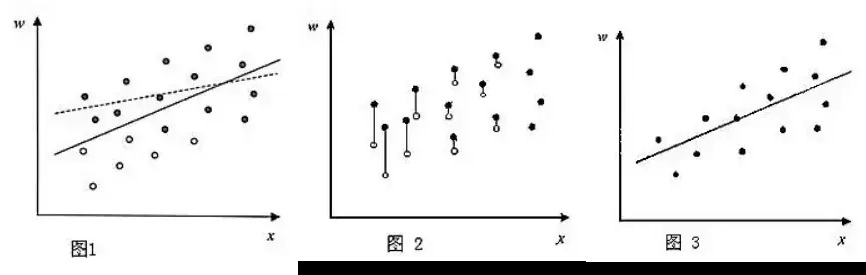

In [1]:
from IPython.display import Image, display

# png_data包含图片原始字节数据
png_data = b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03b\x00\x00\x01\x13\x08\x02\x00\x00\x00\xdb,"\x88\x00\x00\xd8KIDATx\x9c\xec\x9dw\x98\x1b\xd5\xf5\xf7\xeftiTw\xb5\xda\xde\x8bw\xdd{Y\xe3\x8eq\xa1\x99b\x03\x81\xd0K\x1cJ \xc9K !!\xe4GH%!\x84\x14B\t\x10:\x06\x1bc\xb0\r\xb8\xf7\x82\xbb\xbd\xaek{\x8b\xb7JZu\x8d\xa6\xbe\x7f\x9c\xf5x\xac-\xde*\xef\xda\xf3y\xf2\xe4Ydi4\x92\xe6\xce=\xf7\xdc\xef\xf9\x1eLQ\x14\xd4\x1a\x9d}\xbc-0\x0c\xeb\xd4\xf3{\xfb8::\xfd\x82V\x07ZgGA[\xa3U\x1fM:::::\x1d\x01\xbf\xd8\'\xa0\xa3\xa3\xa3\xa3\xa3\xa3\xa3\xa3\xd3\x17\xd1\xc3D\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x9dV\xd0\xc3D\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x9dV {\xfb\r.\x96\x96QGGGGGGGG\xa7;\xe8\xd9D\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x9dV\xd0\xc3D\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x1d\x9dV\xe8\xf5Mg\x1d\x1d\x9dN\x01:\x8d\x18\xb5\x06\x881\xe0A]\x98\xa1\xa3\xa3\xa3\xa3\x13\x1f\xf40QG\xa7\x1f\xa0\r\x10;\xae\xf7\xd5\x95\xc1:::::\xddA\x0f\x13ut.\x1a\xad\x86q\xcd\xd9D\xf9\xfcl"\xaeg\x13utttt\xe2\x8d\xaeM\xd4\xd1\xd1\xd1\xd1\xd1\xd1\xd1\xd1i\x85\xde7\xc49\x9b\x14\x81t\x88\x8e\x8e\x8e\x8e\x8e\x8e\x8e\x8eN\xbf\xa0\xb7\xc2D\x88\x0eeE\xc61\\Vd\x84\x90,\xc8\x92$\xb1,\x8b\x10\n\x87\xc3F\xa3\xb1\x97\xdeZGGGGGGGG\xa7\xfb\xf4z6QVdU\x80\xc5\xd0L\xcc\x1f:::::::::}\x93\x8e\x86\x89j\xa8\xd7\xa9Md5\x95\xa8\xbe$\x1a\x8d"\x84(\x8a\xea\xdci\xea\xe8\xe8\xe8\xe8\xe8\xe8\xe8\xe8\xc4\x97\xae\x97\xb0(\xb2\x82\xe3\xb8(\x8a\xa2(v\xb0\xf4\x92\xe38\xbf\xdf\xef\xf7\xfb9\x8e\xeb\xf2\xfb\xea\xe8\xe8t\x81\x98\xd2i\x1d\x1d\x1d\x1d\x1d\x9d\x0b\xd2f\x98\x88\x9d\x05!\xa4(\x8a"+\x8a\xacH\x92\x84\x10\x92\x15YVdI\x96\x10B\x92$I\x92\x84a\x18<\x01\xfe\x87\x10\xc2pLM7*\x8a\x12\x0e\x87y\x9e\x97$\xe9\xc8\x91#\x92$\xe1\xb8^a\xad\xa3\xd3:0\xe8`\x04\xa9\xffS\xff\xa9\xe3n8\x18\x86\xe18\x8e\xe38\xcf\xf3\x1c\xc7I\xb2tn\x90j\xe8\xad\x8f\xa1\xa3\xa3\xa3\xa3\xd3\xff\xe9z\xb8\x86a\x98$J0\x0f\xc9\xb2\xdc\xd6\x1e4EQ\x0c\xc3X\xad\xd6H$\xb2l\xd9\xb2\x85\x0b\x17\x1e=z\xb4\xcbo\xaa\xa3\xa3\xd3Y\x0c\x06\x83\xd1h$p\xe2b\x9f\x88\x8e\x8e\x8e\x8eN?\xa3\x13a"\xa8\x0c%YR\x14E\x96eI\x92$Y\xa2i\x9a\xa6iQ\x14!\xd1\x18\x03\xc4\x8e\x10MVUU\xbd\xfd\xf6\xdbg\xce\x9c\xd9\xbcysCCCO}\x00\x1d\x1d\x9dV\x91D\x89\xe7yA\x10\x14E\xc10Lw\xa4\xd2\xd1\xd1\xd1\xd1\xe9,\xdd\xca&\xf2<\x0f\xbb`<\xcf\xe3\xd8\xb9Ci7\xa0y\x9eo\xf26E"\x91\xea\xea\xea\xd3\xa7O\xfb|\xbe\xc5\x8b\x17\xaf[\xb7\xae\x07\xce]G\xa7K\\\x1a[\xae\xb2$\xcb\xd2\xf9\xfb\xc7\xe7\x7f(\x9c\xc0\x1b\x1a\x1a<\x1e\x0f\xa8\x81[]\xc8\xe9\xe8\xe8\xe8\xe8\xe8\xb4\xc3\x85+\x9d!\n\x0c\x87\xc3\xdb\xb7ow\xbb\xdd\xf9\xf9\xf9yyy\x0c\xc3\xec\xdb\xb7\xcf\xedv\xdft\xd3M\xa1P\xe8\xa3\x8f>*,,\x1c<x0EQ$I\x1a\r\xe7<\x11eY\xb6\xd9l;v\xec\xd8\xb6m\x9b\xd7\xebE\x08\x1d8p\xe0\xe8\xd1\xa3\xb5\xb5\xb5\xe9\xe9\xe9\xf0\x04\xbd\xf9\x98N\xdchn\x85\xd7Z\x80\xd8w\xaeCQ\x14i\x9a\x86\xbf\x05A\x08\x85B\x04AX,\x16\x84\x10\xcf\xf34MWVV\xa6\xa5\xa5!\x84p\xf9\xdc\xf2\x0c\xf2\x85\x18\x86\t\x82@\xd3\xf4\xa1C\x87V\xae\\\x19\x0c\x06\x7f\xf2\x93\x9f\xd04\xad\x87\x89:::::\x9d\xa5C\xd9D\x9a\xa6\xcf\x9c9\xb3|\xf9\xf2\xa7\x9f~\xfa\xae\xbb\xee\x92e\xf9\xe4\xc9\x93o\xbf\xfd\xf6\x07\xef\x7f\xe0\xf1x6n\xdc\xf8\xee\xbb\xef\xae]\xbb\x96\xa2(\x82 \xccf3\xd4\xb8\xc0\xff8\x8e\x13\x04a\xcd\x9a5\x1f\x7f\xfcq$\x12A\x08a\x18VVVVYY)\x08\x02B(\x14\n\xf5\xeeG\xd4\xd19\x1f(\xc9:\xf7w\xdf\xcb)\x8a\xa2\x18\x0e\x87a\x80\x84\xc3a\x84\x10A\x10\xe8\xacW@0\x18LJJ\x823\xd7\x8e5\xc8\xdfc\x18\x16\n\x85\x82\xc1\xe0\x81\xfd\x07~\xfb\xdb\xdf\xbe\xf3\xce;\x16\x8bE/\x1a\xd3\xd1\xd1\xd1\xd1\xe9\x02\x1d\x9a<0\x0cKKK\x1b>|xrrr8\x1c&\x08b\xf7\xee\xdd\xbbv\xed\xc2p\x8c$\xc9\x9c\x9c\x1c\x83\xc1@\x92$\xcb\xb2\x18\x86A\xcaP\xc5n\xb7\x07\x02\x01\x8e\xe3\xbc^\xaf\xd9lf\x18F\x96\xe5\xa3G\x8f~\xf1\xc5\x17\x14Ey\xbd^\xc8\x91\xe8\xe8\xe8\xa8\xb0,\xcb\xb2,\x8e\xe1\x81@\xc0f\xb3\xd9\xedv\x83\xc1\x10\x08\x04h\x9aNJJ2\x9b\xcd\xd0\xcd\xa8U$Q2\x1a\x8dMMM5\xb55^\xafW\x10\x84\x17^x\xe1\xe0\xc1\x83\xf1<\x7f\x1d\x1d\x1d\x1d\x9dK\x83\x0e\x85\x89\xc1`\x90e\xd9\x91#G\x0e\x1f>\xdcd2y<\x9e\xa6\xa6&Hxp\x1cWUU5t\xe8\xd0\xa4\xa4\xa4P(d6\x9b\xedv;\xd2\xc8\xbf8\x8e\xfb\xf3\x9f\xff\xbc|\xf9r\x8e\xe3\xea\xea\xea`W\xba\xbc\xbc|\xfb\xf6\xed[\xb7n5\x99L\xbd\xfb\xf9tt\xda\xa5\xa5AL_\xc8/z\xbd^EQ\xea\x1b\xea\xd7\xae]\xab(J4\x1a\xad\xaa\xaa\xda\xbd{\xf7\xb6m\xdb|>\xdf\xbe}\xfb\x96.]\x8a\x10\xc20L\x96\xe5\x96/g\x18f\xd9\xb2e\x9f|\xf2\tA\x10\x91H\xe4\xd3O?U\xb3\x89\xb2"\x8b\x92\x18\xd7\x0f\xa3\xa3\xa3\xa3\xa3\xd3o\xe9P\x98\xc80\x8c\xd1hLOO\x1f7n\\ \x10\xd8\xbau\xab\xc3\xe1\x182d\x88\xd7\xeb\xf5x<\xdf|\xf3\xcd\xb0a\xc3&O\x9eLQT8\x1c\xf6\xf9|\xda\xa9\xcb\xe7\xf3\x1d<xp\xdf\xbe}\x04A0\x0c\x03GcY\xf6\xf4\xe9\xd3+W\xae\x94$)\x1a\x8db\x1d\xa0\xb7\xbe\x00\x9dK\x97\xa6\xa6&\xd0<D"\x11Y\x96\xcf\x9c9s\xf0\xe0\xc1\xca\xcaJ\x8e\xe3\x04Q@\x08\xd5\xd5\xd5i\x9f\xaf\r\x10/n\xc8H\xd3\xb4\xdf\xef\xdf\xb2e\xcb\xc7\x1f\x7f\xbco\xdf>\xaf\xd7\xbbg\xcf\x9e\x8f>\xfah\xfd\xfa\xf5G\x8f\x1e\xfd\xc7?\xfe\xf1\xf6\xdbo\xabj\x8dh4\x8ac\xb8ZC&\x88\xc2\xf1\xe3\xc7\xcb\xca\xca\xca\xca\xca$I\x12\x04\xe1\xe8\xd1\xa3\xb0B\x8bp\x11\x84P\xab\x91\xa5\x8e\x8e\x8e\x8e\x8eNK:\xd4\xacOQ\x14A\x10$I2\x1a\x8d\x1c\xc7m\xdb\xb6\xed\xa9\xa7\x9e\xaa\xa8\xa88t\xe8\xd0\xd2\xa5K\xd3\xd2\xd2F\x8d\x1aUTT\x84a\x98(\x8a\x14EigV\x9a\xa6\xa7L\x99b\xb3\xd9(\x8a\xaa\xad\xad-++\x1b;v\xac\xd3\xe9$\x08"33\x13\xc7qU\xaa\xaf\xa3\xd3\xb3\x18\x8dFEQp\x0c7\x1a\x8d\x9f}\xf6Yyy9\xc7q\x14E\x15\x16\x16\x0e\x1c80333%9\x05l\x9e\xb4\x85 \xb0t\xba\xb8+\x13Q\x14\xfd~\x7fuu\xf5\xb7\xdf~\x9b\x9a\x9a\xfa\xe3\x1f\xffx\xcf\x9e=\x9b6m\xba\xe6\x9ak\xc2\xe1\xf0\x97_~\x19\x0e\x87\xfd~\xbf\xc1``\x18\x86a\x18I<W\x9e\x82\xe3\xf8\xd7_\x7f\xfd\xddw\xdf%$$D\xa3Q\x83\xc1\xe0\xf7\xfbkkk\x03\x81\x00\xa8\x87eY\x16E\x91${\xbd\x9f\xbb\x8e\x8e\x8e\x8eN\x7f\xa7\xa3ab4\x1a\x95e\xd9l6\'%%]\x7f\xfd\xf5)))\x90\x938q\xe2\xc43\xcf<\x93\x97\x97\x87\x10\x12\x04\x01\xe6\x1em\x98h0\x18\x9e|\xf2II\x92jjjV\xacX\xd1\xd4\xd4\xf4\xc8#\x8f\\q\xc5\x15\x8a\xa2H\x92\xa4\xcfU:\xbd\x07A\x108\x86\xf3\x02\x1f\xf6\x85\x7f\xfb\xdb\xdf\x1e;v,!!\x81 \x88p8|\xeb\xad\xb7\xdes\xcf=\x05\x05\x05f\xb3\xf9b\x9ff+\x18\x0c\x06\x13k\x1a1bDrr\xf2\xfb\xef\xbf\x7f\xe7\x9dwn\xd9\xb2%\x1a\x8d\xb2,+\x8abnn.T\x83\xb5J(\x14Z\xbf~\xfd\xde\xbd{\xc1C\x00\n\x9c\x97/_>|\xf8\xf0!C\x86\xc0s\xf4q\xa7\xa3\xa3\xa3\xa3\xd3\x11:Z\xff\xc8\xf3\xbc\xa2(\x06\x83a\xe4\xc8\x91#F\x8c\xa0(*;;{\xd8\xb0a\x0b\x17.t8\x1c\x1c\xc7A\xda\x86\xc0\x89\x98=b\xa3\xd1\x88\x10\x92e\x99a\x981c\xc6\x84B!\x8b\xc5b6\x9bi\x9a\xb6\xdb\xed \x99\xea\x0bj0\x9dK\x0fQ\x14\t\x92\x08\x87\xc3\xbbw\xef\xe68\xce\xe1p\x0c\x1b6l\xec\xd8\xb1>\x9f\xef\x9dw\xde\xd9\xb0a\x03\x8e\xe3}\xf3\xc2\x8bD"\xa2$\x12\x04\xd1\xd0\xd0\xe0\xf5z\xbf\xf9\xe6\x1b\x9b\xcd\x96\x91\x91\x91\x91\x91\x11\x8dFq\x1c\xff\xcf\x7f\xfec\xb5Zi\x8a\x16\x04!\x18\x0cj_\xbb|\xf9\xf2\xa3G\x8f\xd24\rm\xfa\xbc^ozz\xfaW_}u\xe4\xc8\x11\x84\x10\xcf\xf3z\xd5\xb3\x8eN\x8f\xd3\xd7\xf4\xcd::=E\x87&\x0c\x1c\xc7-\x16Kbb\xe2\xd8\xb1c\x7f\xf5\xab_\xa5\xa7\xa7S\x14UZZ\xfa\xf4\xd3O\x0f\x192\x84\xa6iA\x10\x04Ahv\xe5P\x14\xa4i\t-\xcb\xb2,\xcb$I\x1a\x0c\x06\x9e\xe7}>\xdf\xf1\xe3\xc7\x03\x81\x00I\x90\x92(ieR\xfa\xd0\xd2\xe9Y\xc0D\xc6\xe7\xf3544\xd4\xd4\xd4\xd8l6\xa7\xd3\x99\x9c\x9c<|\xf8p\x8a\xa2\xa0\x00\x1f\x9e\t[\xcf\xda\xee\xc9\x17\x17\x9b\xcd\x06\xaa\xca\x82\x82\x02\x8b\xc5\xb2z\xf5\xea\'\x9f|r\xe0\xc0\x81/\xbf\xfc\xf2\xa1C\x87^{\xed\xb5\x91#G\xdal6\x9c\xc0q\x1cgYV\xdb\xfd\xb9\xb8\xb8855\xf5\xaa\x99W-\\\xb8\xd0l6\xe7\xe5\xe5}\xf6\xd9g\x85\x85\x85\x06\x83AQ\x14\x9a\xa6\xb5N\xf8:::]\x06\x92\xfa\x92(A\xcdY\xcc\xfc\xa5\xcfh:\x97\x06\x17\xde{R\x14\x85 \x08EV\x8c\x06\xa3\xd1`LHH\x80\xc9\xb5\xb8\xb8\x18\xc30\x92$EQD\x08\xc9\xb2|\xc1,E$\x12!\x08\x82\xa1\x19m\xbaQ\x8d\x14\xf5:\x15\x9d\x9e\x05\xae(\x83\xc1\xe0t:\xcdfsBB\x02\xc30\x10\x1dJ\x92T<\xa0\x98a\x18EQ\xfa`\xb3cEQX\x96\x1d5j\xd4O\x7f\xfa\xd3[n\xb9\xe5\x87?\xfc\xa1(\x8a\x1c\xc7\x85B\xa1\x86\x86\x86\xd4\xd4T\x18506c^[PP\xf0\xd3\x9f\xfe\xd4j\xb5\xee\xda\xb5\x8b\xa2\xa8\xa6\xa6\xa6\xe4\xe4\xe4\x1f\xfe\xf0\x87\x99\x99\x99 \x1d\x96\x15\x99@}\xee#\xeb\xe8\xf4;\xc0\xdf\x8d \t\xbb\xdd\xde\xac\x0f\xd6\xcc\x81\xfa\x8c\xa6\xd3\xb3\xa89\xb88\xbfo\x87$J\x18\x86!\x1c)\xb2"\xc9\x92,\xcb\x06\x83\x01!\x14\x8dF\xe1_\xd56*\xad\x9e\xbd\x9aV\xc4q\xdc\xef\xf7\xe38n0\x1a\xf4m/\x9d8\x00!\x94\xc9d\xca\xce\xceNNN\x8eD"\xc7\x8e\x1ds\xbb\xdd\xe5\xe5\xe5c\xc6\x8c\xc9/\xc8\x07E\x04\x80\xe1}\xa8\xa0\x1e\x8a\xc6p\x1c\x1f6l\xd8\x0f~\xf0\x83\xa2\xa2"\x83\xc1PZZZRR2p\xe0@\x87\xc3\xd1N\xa2\x82 \x881c\xc6X\xad\xd6\xbd{\xf7655%$$$\'\'_{\xed\xb5,\xcb\xea\x8dXtt\xba\x80v\xac\xc5\xdc%\x8e\x1c9\x92\x98\x98HQ\x94\xddfW\x9f\xa0\'\x11u\xbaC;\xd7\x1bj\xad\x85Xo\xcf\\\x9dV\xb2C9\x0bBH\x92$\x98\xab`2\xeeH\xe4\x17\x89Dp\x1cg\x18\xa6\xef\xcc\xc7:\x970p\xbf\x86lbii\xe9\xfe\xfd\xfbkkk\x83\xc1\xe0\xa0A\x83\x9e{\xee\xb9\xb4\xb44I\x92\x08\x82\xe8#\x1b\xcdZx\x9e\'\x08\x82$\xc9\xd4\xd4\xd4\x87\x1f~8//\x8f$\xc9\xd9\xb3g\x8b\xa2\x98\x98\x98(\x89R;\xe7l\xb1X\xbc^/\x86a\x16\x8b\x85a\x18\x9a\xa6\xa1L\x87a\x18Q\x14\xf5\x1ag\x1d\x1d\x84\x90$J\x04\xd9\xdd\x9c:\xc7q\xa5\xa5\xa5\x16\x8b\xe5\x7f\xff\xfb\xdf\xd4)S{\xe4\xc4tt\xda\xa2\xeff\x13a\xae\xc50\x0c#0\x9c\xc0)\x8aB\xe7\xc7\xb3\x8a\xac`8\xa6v?k\xf9r\x0c\xc3p\x0c\xc70,11\xd1\xef\xf7C\x94\xa9\x9d\xe7\xf4\xa8Q\xa7\xc7Q\xf3m$A\xdam\xf6\xdf\xfc\xe67\x1c\xc7\xc1\x8esfffs\x9b\x13\x1cGge\x0f1\x17\xe1E\xbc&\x15E\xa1H\n\xe4\x92F\xa3\xb1\xb8\xb8\x18\x1eOMM\x85\xb3\x92\x15\x19IH+1\x8c\x19M,\xcbB\xd1\x18\xf4\x86\xe68\x0e\xc7q\x8a\xa2dY&\tRm\xfd\x1c\xd7O\xa5s\x89\xc2\xf3<\xcf\xf3eee\x87\x0f\x1f\x0e\x04\x02\x93\'O\x1e8p`\xdf\xb79\x13DA\r\x13eY\x16\x04\x01\xa6\xb6\x98\x12L\x9f\xcfg\xb3\xd9\xb4/\x8cD"F\xa3Q\x96\xe5`0\x08\xe2\x90\x86\x86\x86H$\x12\xe1"f\xb3Y\x12%\x9c\xd4\xf7\xcat\xba\x0eL[j\x88\x15\x08\x04\xacV\xab\xdf\xef\xb7Z\xad\xda\'\x00p\xad\xb6\x9f}\xec>=\x90Wh\x9eu\xda\x8e\x14ut.\x16\xea5\xe9t:\xa1\'\x10\xcf\xf3F\xa3\x91\xa2(u8]>\x01\x13\x84\xc5\xfa\xa6\x98N\x0f"\xcb\xf2\xe6\xcd\x9b?\xfd\xf4\xd3\x95+W\xd6\xd7\xd7?\xfc\xf0\xc3w\xdduWIII;\xfd$/:\xaa \x1ef_\xb7\xdb\x9d\x94\x94\x14\x89D\xa0IX4\x1a%\t2\x10\x0c\xd8\xedv\xb3\xc9\xcc\xf3<D\x90\x008\x8f\x86\xc3\xe1\x93\'O\xde{\xef\xbd\xe1p\x98a\x98\xdf\xff\xfe\xf78\x8e\xcf\x981C\x10\x84\xbe\xe9\xb1\xa5\xd3Oq\xbb\xdd\x82 \xc0\xba\x0b\xa6\xb3\xf8o\x7fuX\x9b\xd8\xda\x8ex\xec\xd3\xda8{\xbc9\x99x\xb9L\xc6:}\x07\xf5\x9a\x14\x04\x01\x92\xe24M\xb7\xda\xd7\xa7\xaf]\x9fj\xb2PF\xddj\x9a\xa2\x1d\xb60\x12Q\xdf\xfb\xb0:\xfd\x97\x9a\x9a\x9a\x7f\xff\xfb\xdfk\xd6\xac\t\x85B\x0e\x87\xe3\xdf\xff\xfe7\x86aO>\xf9$\xcb\xb20\xe2.\xf6\t\xb6\x82(\x8a`\x86\xd5\xd4\xd4\xf4\xea\xab\xafVVV\xfe\xf5\xaf\x7f\x95e\xf9\xcd7\xdf<q\xe2\xc4u\xd7]w\xe2\xc4\x89\x03\x07\x0e\xcc\x9e=\xfb\xca+\xafD\xe7\x0f"\x9a\xa6\x1b\x1b\x1bI\x92\x94$\xe9\xf0\xe1\xc3\x18\x86\xf1<\x0f\x82\x16\x0c\xc3 g\xdf7?\xb5N\x7fAQ\x14\x88\x08q\x02\xcf\xcd\xcd\x850Q\x10\x04\x84\x10\x8e\xe1\xda|\x1cF\xc4\xe3J\xd3\xd3\xe3:\x97\x05\x04AP\x14e0\x18 \x95\xa8\xf56\xbb\xb4\xbbA\xca\xb2\xac\xe7\x0euz\x8f\xc6\xc6\xc6\xca\xcaJ\x9e\xe7Y\x96\xf5\xf9|,\xcb\xbe\xfa\xea\xabO<\xf1\x04\xea@f\xe1\xa2\x00\x03\x1f\xc30Y\x92\x03\x81@}}\xfd\xca\x95+_{\xed5\x82 \xbe\xfa\xea\xab-[\xb6\x1c>|\xb8\xa1\xa1a\xd5\xaaUG\x8f\x1em\xd96\x1d\x92\x8b\xf5\xf5\xf5\xaf\xbc\xf2J4\x1aU\x14\x85a\x18h\'\x06\xb6\xc10\x9d\xeb\xe8t\x1fY\x92=\x1e\x8f\xc7\xe3\x81\xffT\x14E\x92%\xd0#\xc5\x13=L\xd4\xb94\x89\t\xfe\xd4\x8cx\xdf73\x031o\xab\xff\x04\xbd\x9b\xb5\x1d\x9c\xdbGQ\x14\x98\xe4`\x07\x10\x92\xfaz\xe7t\x9d\x1e$111;;\x1bj\xc5\x08\x82\x00i\x07l\xcbB\x99\xe3\xc5>\xc1\xf3\xd0\x16\x01H\xb2TTT4c\xc6\x8c\xbc\xbc\xbc\xaf\xbe\xfa*\x1a\x8d\xfa\xfd\xfe\x11#F\xe4\xe6\xe6\xd6\xd4\xd4ddd8\x9dNI\x92\x0c\x06\x83v\x8c@c\x88\xa3G\x8f\xbe\xf3\xce;\x0c\xc3@\xb7\x08\x8a\xa2>\xff\xfc\xf3\x8d\x9b6\x8a\xa2\xc80\xcc\xc5\xfe\x94:\xfd\x98\xb3\xd60\x18A\x12\x04Ih\xed8\xd4\xc9K5\xfa=\xef%\xbdv\x0f\xd7k\x1eut.e\xb4\xd9D=\x10\xd4\xe9q<\x1e\x8f\xcb\xe5\xe2y\xde\xe5rQ\x14\x05\xae\xba\xa1P\x08\xf5\xe1l"\xc8s\xe1\xf4\x12\x13\x13%Ijjj:|\xf8\xb0\xd5j\xcd\xce\xce\x86Z\xb7\xc2\xc2\xc2q\xe3\xc6\xb5\xea\xe0\xb1u\xeb\xd6\x8d\x1b7Z\xadV\x96e\xbd^\xaf$I\x82 ,_\xbe<++k\xda\xb4i\xf1\xfe<:\x97\x1c~\xbf\xdfl2\x0b\x92 \x8a\xa2\xc1`\x90$\t\xaeI\x8b\xc5\x82\xce^\xc0\xf1<\x9f\xb8\x86\x89\x04A\xe8\x13\x95N<\xe9\xbf\xd7\x9b\xbaR\xc4\xe5n\xa5\xfc{\xbb\x08N\xe72\x87e\xd9c\xc7\x8eY,\x96@ \x00\xfb\xadEEE\xb7\xddv[_\xbe\xd8p\x0cW%\xbfUUU\xa1P\xa8\xac\xac\xac\xa6\xa6\xe6\xc6\x1bo\xac\xa8\xa8\xf8\xf2\xcb/SRR&O\x9e\\TT\xd4\xd6\x0e\xf2\xfa\xf5\xeb\x93\x92\x92\x06\x0e\x1c\xb8r\xe5J\x87\xc31p\xe0\xc0\xca\xcaJ\x86a\xa0\x97\xa6\xee9\xa5\xd3\x1d\xe0\xaa\x13\x04\xa1\xba\xba\xfa\xe4\xc9\x93\x8a\xa28\x1c\x8e\x92\x92\x12\xf5\t\xeanR|FY\\\xaff\xf5#\xe96\xbf\x97<\x1dtx\xd2\x13]qC\x8f\x17uz\x03Y\x96\x1f~\xf8aQ\x14%I\xa2i\x9a \x88\x01E\x03\xae\x98tE\x7f\xb9\xc6\xae\xbc\xf2\xca\xca\xca\xca\x8a\x8a\x8a\xdc\xdc\xdcS\xa7Nm\xd8\xb0\xc1l6\xcf\x9b7\xef\x9ak\xaeQ3\xa3ZO\x9cp8\\ZZ\xfa\x97\xbf\xfc\xe5\x0f\x7f\xf8\xc3\x7f\xff\xfb\xdf\xdc\xdc\\\x1c\xc7\x9fz\xea\xa9\xfd\xfb\xf7\x87B\xa1h4jbM\xda\xbb\xdf\xc5\xf2\xba\xd3\xe9\xbf\xd8l6A\x146n\xdc\xf8\xbf\xff\xfdo\xf9\xf2\xe5\x0c\xc3L\x9b6\xed\x99g\x9e)**\x8ayf|\xae\xaeN\x84\x89]\xbe\xe8\xb5\x8a(\x1c\xc7a\x17\x0c\xdc\x16;{\xba:\xfd\x02\xd5\xf9\xa9\xfd\x1a\x91\xf3\xdc7{!\x88\xe9\xbf\xb7\xe6\xf3\xce\xbc\x17\xf4\xc3z\xc8\xa8\xd3#(\x8a2t\xe8\xd0!\x83\x87\xb4\xfc\'I\x96b\xac\x97\xfa\xc2\x95\xd6<\x8b\xa1s\xb3X0\x18t\xbb\xddiiiIII;w\xee\x8cD"\xc3\x87\x0f\x87\xf2R8y\x93\xc9\xa4=\x82\xd1hT\x14e\xf2\xe4\xc9\x93\'O\x8eD"\xe0\x9b(\xcb\xf2\x8f\x7f\xfcc8\xa6\xac\xc8\xcd;\x00\xb8\xe6\x1d\xf5`Q\xa7\xc3\x10\x04q\xec\xd8\xb1\x15+V|\xf0\xc1\x07F\xa3\xd1\xeb\xf5\xae\\\xb9\xd2l6?\xf3\xcc3999-\xbd<\xfb\x81ob\xc7Q?@\xdf\xd4\xac\xe8\xf4 jI?B\x08\xe1\x1dpS\xd2o\xa0\xbdL_\x9b\xb0u.m\xda\xba\xdb\xf7\xb5k/--\xedg?\xfb\xd9\xaf\x7f\xfdk\x0c\xc3n\xbf\xfd\xf6\xeb\xaf\xbf\xde\xe1p\xc8\xb2\x0c\xf57\xe0\xa4\xd8\xd9cB\x85\x01tN\xd7\x03D\x9d\xee\x00\xad\xc2|>\xdf\xd2\xa5K\x13\x12\x12\x16.\\XPP\xa0V\xdf\xf7\xb9lb\xf7\xd1\xb5\x89\x97\x15\xe0\xb8.\xc9\x92"\xc5\x16\x17\x9f\xcb.\x9fu\xf2\xd3\xe9q\xfa\xf8\xf4\xacs\xc9\xa0\x0ea\xad\xa3[\x07\x8b\xf1/\n\x18\x8eA\x0c\x87\x10\x82\r.\x83\xc1\x10\x89D\xacV\xab\x895\xe1\x04\xae6U\xd7U\x86:\x17\x17\x9e\xe7i\x9aNHH\x08\x06\x83\xd1h\x14\xda\xff\x90$\x19\xcfFG\xfa\x18\xd0\xe9u\xc0\x96%\xc6~\x0c\x9dui\xd1\xe9%\xf4\xaeH::\x17\x04bDI\x94\x8cF\xa3\xda\xe8\xd9\xef\xf7\xb3,\xab\xc7\x88:\x17\x05\xed\xad\xdb`0\xf0<\x0f>S)))`\xc0\x14\x8dF\xb5\x1dYz;\xa7\xa8\x0f\x03\x9d\x9eG\x95\xe3`8F\xe2d \x108s\xe6\xcc\x9e={\xaa\xaa\xaa\xa2\xd1hzz\xfa\xd8\xb1c\xd5V\xc5HOt\xb5Kg\xbf\x1c\xb8e0\x0c\x03\xe2\xb0V\x85\xa1\xfa\x17\xae\xd3#h\x85w\xa8\xedF\\}\xeaz\x8b9g\xb0\xbc\x81\xe8\x10\xf2\x88\x08!\xab\xd5\xda5e\xd4y\xc5+-\xbae\xe8\x1b\xd0:\x1dD\x96e\xb3\xd9L\xd34\x8e\xe3\x89\x89\x89\xa2(>\xfa\xe8\xa3\xd7_\x7f\xbd\xcdf\xe3y\xfe\x9c\xa2\xa3E\xb0\xa8\xa5\xa7\xae4=L\xd4\xe9E\xe02=s\xe6\xcc\x9a5k\x96.]\xbaf\xcd\x1a\x96e\x8b\x8a\x8a\x1a\x1a\x1a\x18\x86\x81HQ\xbfi\xf6\x12\xba\x02XG\xa7\xcb\xe8\xf7%\x9d\x8b\x85\xac\xc8\xc9\xc9\xc9\xb3f\xcd"I\xd2b\xb1\x18\x0c\x863g\xce\xdcw\xdf}\x19\x19\x19\xe0`\x0f\x95R\xe8\xac\xb4\xa3\xb7{=\xeba\xa2N/\x02\x91\xca\xda\xb5k\xdfx\xe3\x8d\x9a\x9a\x9a\x9c\x9c\x9c\xe4\xe4\xe4\x8a\x8a\x8aW_}\xd5\xe5r\xfd\xe5/\x7f\xd1\xef\xc5\xbd\x87\xa2A}P\xff\xc2uz\x9c\xfeX\x9b\xd8\xce@\xe8Z\xceO\xfb|\x98\xbcu\xd5\xb5N\xd7\x90$)11q\xca\x94)\xe3\xc7\x8f\x87\xe6\x90\xaa\x7fg\x8c\xb7v|\xae1=L\xd4\xe9uv\xed\xda\xd5\xd8\xd88j\xd4\xa8q\xe3\xc6\x85\xc3a\x9a\xa6\xcb\xcb\xcb\x0f\x1e<\xa8\x87,::::::Z\x18\x86\x91%\x19\nV\x1a\x1b\x1b\x1d\x0e\x87 \x08\x89\x89\x89\x82 \xa8\x93f<K\xc4:\x1d&vajWd\x05,Q\x9a\x1d\x13\xa1\xf3:~N2\xa5\x87\x0b\x97\x181\x19\xac\xac\xac,\xb3\xd9|\xfc\xf8\xf1\xa1C\x87F"\x91@  \xcb\xb2\xfe\xa3\xa3^\xbb\xf2\xe1\xb0\x17\xf4\xaa\xd4\x7f\x02\x9d\xee\xd3\x1f\xaf\xa2\x96\xe7\xacZ\xbd\xc6<\xd2\xd6\xf3\xd5\xc7U?`\xed\xb4\xdd/4\x9a:}\x16\x9e\xe7\xe1\x0f\x1c\xc7322\x10B\x06\x83A\x1b#\xa2\xd6\xae1\xbd\x84E\xa7\x1f3k\xd6\xac\xa3G\x8f\xaeX\xb1b\xed\xda\xb5<\xcf{<\x9e\xa4\xa4\xa4k\xae\xb9\xe6b\x9f\x97\x8e\x8e\x8e\x8e\x8eN\xdfB\xdbI\xbce\xd60\xfeb\x86x\x87\x89\xe0\xcb\xaf/\xaa.\x07\xd4B\xbf\t\xe3\'TWW\xd7\xd5\xd5\x85B!\x84\xd0\x88\x11#&M\x9a\xa4\x87\x89q\x00\xd2\xba`E\xa4WY\xea\xe8\xf4\x1e\xda\xc9[\x1fe:\xdd\x81\xa2\xa8\x8e<-nR\xe0\xb8\x86\x89\x10 \xf6#\x99s?\xa5#\xdfp<od\x11.r\xddu\xd7\r\x180\xe0\xeb\xaf\xbfNLL\xcc\xc9\xc9\x192dHFF\x06\x84/={&-\xb7\x8dt;\x18\x1d\x1d\x1d\x1d\x9dK\x89x\xc6Q\xf1\xce&\xe28\xaeg\x13{\x95s\xfd\x94\xdb(\x92\x8f\xb1\rC\xbd\x106\xc1\xbbC\xc5>B\xc8h0J\xb2TRR\x92\x95\x95\xc50\x0cI\x924EK\xa2\xd4\xb3\xd6\xa0-\x03\xc4\xe6t\xa6&g\x1f\x87\xcf\xae\xa3\x137dY\x8eF\xa3\xd0S\xee\x95W^\xd9\xbe}{nn\xee\x8d7\xdeX\\\\l\xb7\xdb\xfd~\x7fL\xef\xd7\xde\xa6\xff\x8e&\xed\x99\xebyw\x9d\x8bK\xfbW`\xfc\x13mz6\xf1\x12D\xdbOY\x92$\x14\xa3o\xd04\xa4\x8f\x0f\xb2"c\x18FS4a%\xb4o\xdd\x1bnO\xda\x00\xb1\xd9YJ\xbe\x98\x9f]G\xa7\xf7\xe0y>\x1a\x8d"\x84\x96,Y\xf2\xc1\x07\x1fTTT\x90$\xb9c\xc7\x8e)S\xa6\\s\xcd5\x03\x06\x0c\xd0\xd7\xe4:::\xdd$\xaea\xa2^\xda|\xf9\x80\xe1\x98\x1a\x9fA\xb8\x06\xc1\xe2E=)\x1d\x9dK\nh=|\xe4\xc8\x91\xb7\xdf~\xbb\xa2\xa2"\x1a\x8d\x06\x83\xc1]\xbbv\x85\xc3\xe1\xd2\xd2R\x9a\xa6\xf50\xb1\x0b\xe8\xdf\x98\x8e\x8e\x96xo:\xeb\t\xc58\xa0m\x12\x85c\xb8\xba\xf9\xdb\xe6\xf3\xfb\xf9\\\xd2\xd2\xcc\xa2\xb7\xdf\x0b\xe8\xd7_\x9a\xce%\x004\x1d\xde\xbau\xebw\xdf}\'\x8ab4\x1a\x15EQ\x10\x84`0h\xb3\xd9\x18\x9aA\xfa\x15\xab\xa3\xd3\x13\xf4^+\xbc\xbeO\xbc\xc3D0\xcc\xd3\xc3\xc4\xde\x03\xae\xdd\x98\xd0P\x10\x050^\x12E\xd1h4j-\xdd\x11B\x14E\x9d\xeb\xca\xda\x13\x97~\xccO\xdc\x96\x11h\x8fl7\xc7\xc4\x881!r\x0f\xbeWK\xedc$\x12aY\x16!$\x89\x12\xf4\x84m\xf9\xe4\xcb\xe7V\xa2\x137\x14E\x11EQ\x92$\x83\xc1@\x92dbbbZZ\xda\xe1\xc3\x87\x11B8\x8eC\x99$\xc7q^\x9f\xd7\xe1p@\xa1XK\xf4+\xb3%\xfaw\xa2\xd3*\xea,\x13\x1f\rk\xfb\xc7\x8c\xffU\xaag\x13/A\xb41\xa2,\xcb8\x8eS$\xe5r\xb9\x10B.\x97\xeb\xd8\xb1c\xd3\xa7O\xa7i\x9a\xa2(\xd5\x9f\xa9_\xff"Z-f\x1c\xde\x0b\x9d\rF\x8dF#<H\x90\x04\xc7q\x0c\xc3\xb4,\x91\xd1\xd1\xe9=\xbc^o4\x1a\xcd\xcc\xcc\x0c\x87\xc3\x0c\xc3\xc8\xb2L\x10\x04\x86a\xc9\xc9\xc9\xa9\xa9\xa9\x0e\x87\x03\x9d\xaf\x00\xd6\x8b3tt\xbaF\xf3,\xd3\xa2 \xf2r \xde\xda\xc4\xfe\xbe\xbf\xd9/\xd0f\xd1$E\x12\x04!\x12\x89\xac_\xbf~\xc9\x92%G\x8e\x1ca\x18\xe6\xddw\xdf\xbd\xeb\xae\xbbF\x8d\x1ae6\x9b\x19\x86a\x18\xa6\xc7\xcf\x01\xc30uD\xc5-\x86\x8b3>\x9f\xcfn\xb7+\x8a\xe2r\xb98\x8eKMM\x85\xe6\x9b\xb0\x15\xa8\xa3\xd3{\xe0\x18.!\xc9n\xb7#\x84\x86\x0c\x19\xf2\xce;\xef\xfc\xedo\x7f\xdb\xb2e\x0b\xc7qW\\q\xc5\xef~\xf7\xbb\xe2\xe2\xe2H$\xa2\xaedtttt\xba\x86>\x9f]\xe2\xe08\x1e\x0c\x06\xeb\xea\xeaV\xaf^\xbdw\xef^EQH\x92\xfc\xf2\xcb/y\x9e\x7f\xec\xb1\xc7&N\x9ch0\x18\xfa{\xf6\x0b\xc30A\x12H\xa2\xbd\x8b\xb97r*n\xb7{\xe9\xd2\xa5\xfb\xf7\xef\x97$i\xca\x94)s\xe7\xce\xa5(J\x92$=L\xbc\x1c\xe8\x0bZ%I\x94\x9a\xbcM\x0e\x87\x83$\xc9\x7f\xfc\xe3\x1f/\xbc\xf0\xc2\x993g\xae\xba\xea\xaa\xc2\xc2B\x84\x90\xdf\xefG\x08\xd1\x14\x1d\xe7\xb3\xd2\xd1\xb9\xf4\xb8T\x93\x1d\x1dA\x9f\xcf.5\xa0_\xb6zM\xd34\x1d\x08\x04\xf6\xee\xdd\xbb~\xfdzA\x10\n\n\n\x9cNgmm\xed\xb6m\xdb\xa6O\x9f>h\xd0 \x83\xc1\xd0\xe3\xd3[l\xda\xb87{\x947k1e\x19\xa30\x1c\xc7\xc3\xe1\xf0\x81\x03\x07\x12\x12\x12$I\xca\xca\xca\xa2i:\x12\x89\xe08\xce\x1aY\xd4Z\xb0\xd8\xf2P-\x81\xac\x0c\xfc+\xc7q<\xcf\xef\xd9\xb3\xa7\xa6\xa6\xe6\xe0\xc1\x83\xdf}\xf7]CCCVV\xd6\x9c9s\x04A\x80\xe4\x8d6\x0c\xd5\xb7\xf9.I\xe2\xacUj\xf9\xd6\x18\x8e\xd14\x8d\x10J\xb0\' \x84\x9cINA\x14222\xa2\xd1\xe8\x80\x01\x03p\x1c\xf7x<\x89\x89\x89\x8a\xa2\x88\x92\x88\xe38\xd8\x0et\xf6\xca\xd7\xd1\xd1A\x1a\xc5\x7fK{\xb5\x96O\xbb\xf4\x88k\x98\x88\xe3\xb8,\xcb\xfa\xbes<\x81\xd8\xa5\xbc\xbc\x1c\xc3\xb0\x92\x92\x92\x9c\x9c\x1c\xbf\xdf?r\xe4\xc8o\xbe\xf9&\x12\x89\x08\x82 \x08\x02\xcc7\xfd\x17H\x91\xe28\xeer\xb9\xf6\xec\xd9s\xe0\xc0\x81\xad[\xb7\xe6\xe4\xe4\xcc\x993g\xf8\xf0\xe1\x0e\x87#\x1a\x8d6{(b8\xea\x98_\xa3v*5\x1a\x8d\xb2,\x07\x83A\x8e\xe3\\.\xd7\xf1\xe3\xc7?\xfa\xe8\xa3\xbd{\xf7R\x14\xe5p8\xee\xba\xeb\xae\x1bn\xb8!))\xc9j\xb5\xa2K\xf7N\xa1\x13C_\xd3*q\x1c\x17\x0c\x06\xcb\xca\xca\x96,Y\x12\x8dF\xa3\xd1\xe8\xfc\xf9\xf3\x83\xc1 I\x92\xb2,#\xbc\xcdJ\xb2\x8e\xa3\xdf\xbau.[.h\x18r\ts\xd1\xb2\x89\x8a\xac`\x84~\xc7\xe9\x15\xb4\xba@\n\xa7L&Sii\xe9\x1bo\xbc\xb1q\xe3F\xaf\xd7;`\xc0\x80o\xbe\xf9\x06!\x94\x99\x99\x99\x9d\x9d\xad\xbe\xaa\xff\xe6\x18\xa0\x0b\x05Bh\xfd\xfa\xf5\xbf\xfb\xdd\xef\x0e\x1d:\xc40\x0c\xc7q\x9b6mz\xf4\xd1G\xbf\xff\xfd\xefk\x8b\xbb;r4EQ$I\x82?\x10B\xb2,\x8b\xa2\xb8a\xc3\x86E\x8b\x16-_\xbe<\x1a\x8dfgg\xdfz\xeb\xad\xb7\xdf~;EQ\x89\x89\x89F\xa3Q\r\xb5)\x8aRd%\xfe\xdd\xd9u\xe2\xcfE\xfc\x95\xd5\\\xb5z\x0e\x92$\xd14\xed\xf1x6o\xde\\UU\x05\x01\xe2\xb4i\xd3\x10Bj\xa4H \xa2\x9dc\xb6\xc39\'\x81~{\x97\xd0\xd1\xb9<\x89\xd9\xe5hUc\xd6\xfe(\xbe\x08%,\xfa\x924\x9e\x80\x1d\xc6\xe8\xd1\xa3o\xbe\xf9\xe6\xd5\xabW\x1f;v\xec\xcc\x993III\xd7_\x7f}NN\x0e\xc7q\x97\x806\x11\xea\xb5\x03\x81\xc0\xea\xd5\xab+++333KKK\xcb\xcb\xcb\xcb\xcb\xcb7l\xd80{\xf6l\x83\xc1`0\x18Z}\xad,\xc9\x04I\xc4x\xcba\x18\xc6q\x9c\xfa\xc8;\xef\xbc\xf3\xcd7\xdf\x1c;v\xccn\xb7\xcf\x9d;w\xce\x9c9\xf9\xf9\xf9f\xb3955\xd5l6\x83Y\x9dj-\x84a\x18F\xe8\xb5\xfc\x97\x17\x92$\x11D\x17#\xb0\x9eb\xd7\xae]\xa2(\x96\x94\x948\x9d\xce\xaa\xaa*EQ\x9e{\xee\xb9\'\x9f|\xb2\xb4\xb4\xd4\xe9t\xaau\xd0\xddy\x0b\xfd\xd6\xad\xa3s\x19\xa2k\x13/5bt\x81<\xcf[,\x96h4z\xfb\xed\xb7\x0f\x1e<\xb8\xae\xae\x0e!\x94\x9a\x9a:l\xd8\xb0\xe1\xc3\x87#\x84\x04A \xf0s\x93\x876\xc5\xdb\x1dc\xde8O\'\xb2,755UWW\xe7\xe7\xe7gee\xe5\xe7\xe7[\xad\xd6\xea\xeaj\x8f\xc7\xb3{\xf7\xee\t\x13&4\xe7\x05\xd1\xb9\x8d\x03\\\xc6A\xb6E \xe2\\n\x06\xc38\x8e\xa3i:\x18\x0c~\xf5\xd5W\xa7O\x9f\x0e\x85B\x9b6m\xca\xcc\xcc\x9c;w\xee\xd8\xb1c\x07\r\x1a4h\xe0\xa0P8d\xb5Z\x05A\x88)X\x81p\x01;K<\xbf\x81\x0e\x02\xdf\x83j\x84\xa4\xd35\xb4\x17\x0cBH\x96e0\x1f\r\x85B\xa2(\xda\xedv0\x88\xed=O\xb5\x96\xfa\xd7?\xff\xf9\xcf\x15\x15\x15\x8f?\xfe\xf8\xc3\x0f?\xec\xf7\xfbC\xa1\xd0\x90!C>\xfc\xf0\xc3\xac\xac\xac\xa4\xa4$\xa8\xc1?O\x86\xdf\x81K\xa0\xa5\xf2\xb2\xe5=A\xb7\xef\xd6\xb9\xe4\t\x87\xc3p\xcf\x94\x90\x84\x10b\x18&\x12\x89P\x14\x05\xbbX}\x96\x96^\xbf\xda\xff\xec\xb8\xaeZ\xcf&^\xe20\x0c\x13\x8dFeY\x1e>|\xf8\xf0\xe1\xc3}>\x1fB\xc8f\xb3\xa9\x97\x85\xa2(\x92,!\x84\xb4\xc1b\xff"\x18\x0c\xd24\rY\xbd@ \xe0r\xb9\xaa\xaa\xaa\x9cN\xa7\xd9l\x96$\xc9\xe1p\xb0,\xdbjz\x0f\x06y4\x1aU\x14\x85\xa6iEV**+jkk\xab\xab\xab\x03\x81\xc0\xae]\xbb\xc0\xb2x\xec\xd8\xb1\xa5\xa5\xa5S\xa6LIKM\x13%\x91 \x89\xb6\xc2,\x1c\xc3A\xaf\xa6_\xe1\x97\x15$Az\xbd\xde\x1d;v\xac_\xbf>33s\xde\xbcy\t\t\t`hO\x10m^-=\x8b \x08\t\t\t,\xcbB\xc5\x15\xc7q\xb2,\x17\x15\x15Y\xadV\xb8\x1a\xbb?\xc0u5\x85\xcee\x05\xcf\xf34M\xc3"PkS\xcf\xf3<\xcb\xb2m\x19\xd7_z\\\xb4l\xa2\xac\xc8x\xafV\xc0\xea\x9c\x05\xc30\x1c\xc7\xc1\x1c\xd1\xe9t\xc2#\x1c\xc7\xa9\xd9\x0emL#K2:+\xba\xea/\xb1\x0e\xc30$I\xe6\xe7\xe5;\x9d\xce#G\x8e\x9c:u*\x12\x89TVV\xca\xb2<j\xd4\xa8\xa2\xa2"Q\x14[\xddnk\xaee\xc1\xb0p8\\__/\x8a\xe2\xae]\xbb\x16-Z\xb4u\xeb\xd6\xd4\xd4T\xa7\xd39c\xc6\x8c\x993g\x0e\x1c8\x10\xda]\x08\xa2\x80\x10\x92D\x89$IA\x10:\xd2\x08Q\xe7\x12F;@\xa0\x99\xf2\x7f\xff\xfb_\xa3\xd1\xf8\xc6\x1bo,X\xb0\xa0\xb0\xb0\xf0\xca+\xafd\x18\xc6`0\xf4x\xa4\xd82\xa7x\xe7\x9dw.Z\xb4\xe8\xa3\x8f>Z\xbat)\xc7qv\xbb=77w\xfa\xf4\xe9N\xa7\x93 \x08Q\x14)\x8a\x92D\xa9\xcb\xef\x08\x83\xa5e>\xb2\xbf\xdc%tt:\x0b\x81\x13 L\xaf\xab\xab\x0b\x85B\xda\x7f\xca\xca\xca\x8aF\xa3\xe0`\xdfe\xe2\x93\x89oU\x9b\xd8\xa9\xf2\xbbxg\x13\xd1\xd9\x12\x81x\xbe\xef\xe5\x0c\xac\x87\x10B\xd1hTUP\xc12\xa8\xcb\xd7eG~\xbexN\x1eP>\x1f\x0c\x05\xff\xf4\xa7?\xbd\xf4\xd2K\x7f\xfa\xd3\x9fjkk\xd3\xd2\xd2\xee\xbb\xef\xbe\xfb\xef\xbf\xbf\xadT\xa2\n\xc7qk\xd7\xae\xfd\xe4\x93O\xb6n\xdd*I\x92\xcdf\xfb\xe5/\x7f9i\xd2\xa4\x8c\x8c\x8cP(d\xb5Z\xc13\x08\xc7p\x9c\xc4EI\x8c\xf2Q\x82 $IR\xf06\xf3\xe2z\xb3\xbe\xcb\x8a\x08\x17Y\xb4h\xd1\x07\x1f|\xe0\xf5z\x9b\x9a\x9a\xea\xea\xea^\x7f\xfd\xf5\xa1C\x87\x16\x16\x16\xe6\xe4\xe4h\xdb\x1d\xf5\x08\xad^\xcf\xd7^{-EQ\xabV\xad\xda\xb9s\'EQ.\x97\xeb\xd9g\x9f\x9d={6\xcf\xf3`1\x81`q\xde\x8dz\xe7n\xbe\\G\xa7\x7f\xc1\x0b\xbc\xd1h\xf4\xf9|\xb7\xddv\xdb\xb6m\xdb\xd4\xc7\xe7\xcc\x99\xf3\xc1\x07\x1f\x98\xcd\xe6@ `\xb1X:uL\xednj\xef\x85\x8915g\xedT\x0c7\xe7J\x88\xf6\xec\xdb\xe2\x9dM$I2\x10\x08\xc0=K\xdf}\xee%\xb4\xdf\xaa\xda\xaf\x99\xa2(\x92 \x9bo\xf4\x04B\x08I\xb2\xd4\xf2\xfb\xbf\xe0\xa6\x92*Qj\xcbV&\xfe\r\xeb@\x9e\xcf0\x0cA\x10\x0f>\xf8\xe0\xd5W_\x8d\x10\xca\xc8\xc80\x1a\x8d\t\t\t\x08!Q\x14\x11B8\x8e\x13\x04\x01\xdaA\x97\xcb\xe5t:\xcb\xca\xca\xdex\xe3\x8d\xad[\xb7B\xf4<\x7f\xfe\xfc\xd9\xb3g\xd34=h\xd0 xrRR\x92\x9as\x85\xady\x0c\xc3H\x92T/\xddV\xc3A}o\xeer@\xfb\x8b744l\xdf\xbe\xfd\xe4\xc9\x93\x1c\xc7\xd9l6I\x92|>_ \x10\x08\x85B\xd0\xf5\xbb\xa1\xa1!99\xb9G\xde\xb7\xad\x91\x95\x90\x90p\xd3M7\x8d\x1b7n\xcb\x96-\x90>\xbc\xf1\xc6\x1bAA\x05\xa7\xca\xf3<\x86aZg\xa8N\x11\xe1"\x82 \x9c9s\xe6\xd8\xb1c^\xafw\xf2\xe4\xc9\xc9\xc9\xc9\xaa|\x05\xe9+"\x9dK\x0e\xa3\xd1\xa8(\xcaUW]u\xf2\xe4I\xb8\xcea\x06\xd9\xb8q\xe3\xdc\xb9s\x97/_\xde\xe5#\x83\x8e\xd9h8\xd7$\xc9\xeb\xf7\x1a\x8d\xc6@ \xc0\xb2,\xdc4\xbaLs|u6\xf1\x0fC>\xe0\x0b\xd8\xedv\xaf\xd7K\x92\xa4\xd9lvy\\,\xcb\x12\x04\x01m)\xfa\x906Q=\x8f\xcbgS\xbf/\x03\x192\xd4yG(m\x0feI\x92P\xcc\xacs1\xb6\xa2\xe0|p\x1c\xcf\xcc\xcc\xcc\xcf\xcfG\x08\xc9\x92,Jb8\x1c\x96e\x19\xcc\xb1\xa1\xbd5B(\x18\x0c~\xfd\xf5\xd7\'O\x9e\xac\xad\xad\xdd\xbbwoBB\xc2\xd4\xa9S333G\x8c\x18QTT\x14\x8dF-\x16\x8bvS\xbek\xe7\xd3\xfe\xfaL\xe7R\x82$\xc9H$\x12\x89D\xd0Y3v\x9e\xe7ah\x80O\rt\xd5\xeb)ZFf\xb2$c\x18F\xd3t~~~ff&\x84\x89\xad\xbe\xb0\xcb\x97\xa2\xc9d:y\xf2\xe4{\xef\xbd\xb7m\xdb6\xb7\xdb\xbd\x7f\xff\xfe\x993g\x8e\x1b7N\xd5\xb1t\xed\xb0::}\x96`0\x88\xe38\xac\x85l6\x1b\x86a~\xbf_\x10\x04Q\x14\xbd^o\xd7:aj\xc7\xa0v\xe6\xb5\xd9l\x91H$))\x89\xe7\xf9\xee\x9c\xf3\xb9=\xe5\xb3\xc7\x87G\x18\x86\xe1y^5\xfd\xb0X,\x0c\xc3\x08\x82\x00\x99#Hm\xc0\xb9\xb5\xbcK\xe8\x95\xce\x97\x11\x18\x8eiM\xe4q\x0c\x87\xa4\xd7y\xce\xf2\xfd\x19Y\x96\x05A\x00\x15f0\x144\x18\x0c\x10\x1aB1rccceeecccyy\xf9\xf2\xe5\xcb\xddnwJJ\xca\x8c\x193F\x8d\x1a5{\xf6l\xb3\xd9,\x08\x02\x14\xb5(\x8aB\x91T\xab\xd9\xd6\xb6P\x87VL\x1eQ\x9f>/\x07\x18\x86q8\x1c\x0e\x87\xc3\xe7\xf3\x81\xf07\x1a\x8d:\x12\x1d\t\t\t\x10\xb1\xf5l\xff\xc6V7\x01p\x19\x97\x91\x0c\xc5X\x04\xde\\7\x13\xa3?\x86\xff\xefB*\x11\xc3\xb0\xe3\xc7\x8f\xbf\xff\xfe\xfb\x7f\xfc\xe3\x1f\x1d\x0e\x87\xdb\xed>t\xe8\x90\xdb\xed\x1e6lX\xab\xe7\xa3\xa3s\t\x00\xf5g\x7f\xfc\xe3\x1f_x\xe1\x85m\xdb\xb6y<\x1e\xa8qf\x18&;;\x9b"\xbb[\xe6\xac\xdd\x19\x08\x04\x02\xb0\xce\x0c\x87\xc3III\xdd<rK0\x0c\xe3y\x9e \x88\x86\x86\x86\x15+V\x14\x16\x16\x0e\x1b6\x8c\xe7y\xe8\n\xd1>z\x98\xa8\xd3!\xb4Z\x07\x1c\xc7a\x07\xb6#\xcfG\xbd3\x8b\xb4u|\x82 \xc0\xf2\x10fk\x10\x8e\x84B\xa1\xfa\xfa\xfa\xed\xdb\xb7\x7f\xb1\xf4\x8bm\xdb\xb79\x9dNQ\x14\xe7\xcd\x9bw\xf5\xd5W_q\xc5\x15\x08!\xe8F\x13\x89D\xa2\xd1\xa8\xd9lF\x08\xc9\x8a\xac\x1e\xb6#\xa5*\xcd\xe7\xa3O\x97\x97%$I\x16\x14\x14\x14\x14\x14\xec\xdf\xbf\x1fV&\xf9\xf9\xf9\xbf\xfc\xd5/322`^\xe18\xced2\xa1\xf3\xc3\xb5\xde\xa6\xa7T=p\x9c\xcf>\xfb\xec\xff\xfe\xef\xff\xacVkSS\x13<\x18\x8dF\x0f\x1d:\xa4\xb5\xe8\xd7\xd1\xb9\x94\x80ya\xc2\x84\t?\xfe\xf1\x8f_}\xf5\xd5\xbd{\xf7"\x840\x0c\xcb\xcd\xcd}\xf8\xe1\x87EI\x94$\x89%\xbb\xb5A\xacB\x92drrr \x10\xb0\xd9l\xda\xc7\xdb\xd9\x8f\xea\xd4V\x15ER.\x97k\xdf\xbe}\xef\xbd\xf7^UU\xd5\x82\x05\x0b\x86\x0c\x19b\xb7\xd9;\xb2\x97\xa8\x87\x89\x978\xadx#\xb5T\x13v@\x8f\x08\xb9h\xf5\x91P8\x04\xadMH\x92\xa4iZ\x12\xa5@0\xa0:uCw\xbb\x98\xf7my>]&\xc6\xc2MQ\x94p$\x0c\xf6\x90\x0c\xc3\xc0\xd9\xe28\x1e\x8dF+**<\x1e\xcfK/\xbd\x04\xbe\xe2&\x93\xe9\x86\x1bnx\xec\xb1\xc7\xd4\xdez\xc1`\x90 \x08\x86ap\x1c\x07\xd7\x0301A\x08E\xa3Q\x82 \xc0\xd6\x84\xe38\x8a\xa2\xe0s\xc1\xbd#\x18\x0c\xfa\xfd\xfe\xac\xac,\xa8"\x87\xce\xd1\x18\xdeG\xed\x12uz\x15\x87\xc3\xf1\xa3\x1f\xfd\xe8{\xdf\xfb\xde\x96-[\xb6l\xd9\xb2t\xe9R\x98Q\xc0\xa7\t\xc30\x86a:"\x15\xef\x08\xda\x91\xa8\xd5\xc2CB\xb1\xf9\xf8\xb2\x02\x92#\xc8&vS(\x8ca\xd8\xc7\x1f\x7f\xbcv\xedZ\xd8[\'\x08"!!\xc1\xe3\xf1\x18\x0c\x86\x9e\xddL\xd7\xd1\xe9S\xa8\x99\xb6\x193f@\xbfV\x8f\xc7\x13\x08\x04F\x8e\x1c9n\xdc8u\xebI}~GF4<\'\x14\nA\xd9\x00\xd4\xb7\x05\x02\x81\x9d;w&\'\'\x93$\x99\x9a\x9a\xca\xb2\xacj_\xa5\xed\xc3\xae.2\xb53`\xcc\xe8\x86\x925Q\x14Y\x96\x8d\x86\x9b\xebV\xf7\xef\xdf\x7f\xe8\xd0\xa1\x83\x07\x0f\xee\xde\xbd\xbb\xba\xbaz\xf6\xec\xd9#F\x8c \x08\x82 \t$\x9e{\x97\xb6\x16\xb1z\x98\xa8\xd3!\xb4zD\x05S\xa0z\xda\xe5r\xbd\xf7\xde{\x9b6m\n\x87\xc34M\x0f\x1d:\xf4\xf9\xe7\x9f\x97e9\x10\x08\xb0\xc6sk\xac\xde\xa8\xe7\xd0\x9e\x8f 6\x07vpV\x82 x\xbd\xde\xda\xda\xdaW^y\xe5\xf0\xe1\xc3,\xcbb\x186{\xf6\xec\x9c\x9c\x9c\x01\x03\x068\x9dN\x10oI\x92\x04\xa2~\x92$\xa1\x07.A\x10\x16\x8b%\x1c\x0e\x1b\r\xc6`0\x08\xe5/Pqu\xfc\xf8\xf1\xea\xeajQ\x14\x0f\x1e<x\xdbm\xb7\x11\x04\xf1\xed\xb7\xdf\xae]\xbbv\xec\xd8\xb1\xb7\xddv[vv\xb6\xb6~\xbf\xfb\x13\xb3N\xff\x82\xe38\xb3\xd9l\xb1X0\x0c;t\xe8\x10EQ\x92$\x81\xf8\x01\x9d53\x87U;\xa6\xb4^\xf2\xd5\x1b(r\x0fd\x13%Q"Hb\xd2\xa4IV\xab5\x1a\x8d\xae_\xbf\x1e\x9d\xb5\x1a=s\xe6\x8c\xfa\x19ut.mf\xce\x9c\t\x7f(\x8a\x02\xdd\xcb\x10B\xb0\x18\xeb2\x14E\xf9\xfd\xfe@ \xb0y\xd3\xe6\xc5K\x16[,\x16Q\x14\xef\xbe\xfb\xee\xe1\xc3\x87\xab\x95g0\x93j\x83E\xf5\x0fU\x80\xa8\x9d} L4\x1a\x8c\x81@`\xd3\xa6MPv\xb6s\xe7\xce\xcd\x9b7[,\x96\xc1\x83\x07\xdfx\xe3\x8d\xf3\xe6\xcdKOOW\x14%\x18\x0cj\xcbh\xdaB\x0f\x13/#0M\xaf\xe7\xce\xbe\xb0\xb9\x8b\x89"\xe3\x18.\x08\x02\x86a\xf5\xf5\xf5\x1b7n\\\xb4h\xd1\xd1\xa3G\x15E\x01\x1f\xef\xbf\xfd\xedo\xf7\xdcs\x0f\x04X=BG\xd6j\xaa\x9f\xb0\xc1`8s\xe6\xcc\xd6\xad[\xd7\xad[W__\x0f\xa1\xde\xd0\xa1C\x07\x0c\x180t\xe8\xd0\xb4\xb44\xa7\xd3)I\x92*=&\x08\xc2\xef\xf7\xc3\xec\x1e\x8dF!\xcad\x18\xa6\xae\xbe\xae\xa2\xa2b\xf7\xee\xdd\x90/\x9c5k\xd6\xce\x9d;W\xae\\\xd9\xd8\xd8h\xb5Zo\xbf\xfd\xf6\xd4\xd4\xd4\x81\x03\x07\xba\xdd\xee\xbc\xbc<\xd8\xd7nU\x04\xa6s\x99\x00\x02DY\x96=\x1e\x8f\xdf\xef\x87\x18\x11\nYz\xe3\xedZ\xd1&\xc2#-F7\x81\x131\xf2\x89\xce\xbe\x0b\xccO\x19\x19\x19^\xaf\xb7\xa8\xa8h\xf7\xee\xdd\x8a\xa2@u\xce\x88\x11#zCD\xa5\xa3\xd3\xd7\x90eY\x92$\x1c\xc3q\x02\xc70Lm\xfd\x8a\x13]\x97\xf5\xc3\x96W \x10X\xbcx\xf1\xbf\xfe\xf5\xaf\xe3\xc7\x8f\x1b\x8d\xc6H$"I\xd2\xb3\xcf>\x9b\x92\x92\xd2\x91IDVd\xf0\x83\x93e\x19v\xf0\xacVkcc\xe3\xae]\xbb\xfc~\xff\x1bo\xbc\xd1\xd4\xd4\xc4\xf3|vv\xf6\x981c\xc0\x0683#S\x10\x05\x92 \t\x92@\x08)\x8a\x02f\xc9\xed\xa0\x87\x89}\x85\x98\xfcS\xdf\x8c3\x14EA\x18\xc20L\x14\xc5\xca\xca\xca\xb5k\xd7\xd6\xd4\xd4L\x9e<Y\x14\xc5\xa6\xa6\xa6\xbd{\xf7\xd6\xd5\xd5\xddp\xc3\r)\xc9)\x1d?&\xd6no\x9e\x8e\x84\x89\x14E\xf9|\xbe\xdd\xbbw\x07\x83\xc1#G\x8e\xec\xde\xbd\xdb\xe7\xf3edd\x8c\x1d;v\xd4\xa8QyyyF\xa3\xd1\xe1p\xc8\xb2\x0c\x81 B\x08\xaa\xd5DQLLL\xc40\xac\xa2\xa2b\xd7\xae]\x8a\xa2X,\x96I\x93&\xd5\xd5\xd5\xbd\xf7\xde{;w\xeedYv\xc6\x8c\x19\x1c\xc7\x89\xa2h\xb1X,\x16\xcb\x80\x01\x03\x12\x13\x13I\x92\x1c=ztqqqZZ\x1a4\xb99o\xfb\xaf\xb5b1\x9dK\x18\xa8\x06#I\x12\xbc\x99@\xbf\xdbK\xef\x15\xb7\xe6x\x90l\xb0X,\x92(E\xf9\xa8\xddn\xbf\xfe\xfa\xebSRR\x12\x12\x12B\xa1\x90\xc3\xe1\x985k\x16\xe4\xd1\xf5K]\xe7\xd2\x06\xc7qEVDI\x94xI\x96e\x92$)\x92\x82\x90\xb1\xad\x8d\xa3\xb6\xc6\xa9v\xbc\x04\x02\x81\x8d\x1b7\xfe\xeb_\xff\xf2x<p\xd3\xc00l\xd9\xb2e7\xddtSVV\x16I\x92\x17\\\xd7A\xe4\x1a\x08\x06\xd4G\xca\xca\xca6m\xda\xf4\x7f\xff\xf7\x7f\xa0\xbf*))\x197n\xdc\xfc\xf9\xf3\xb3\xb3\xb3!!\x82\x10\x12DA\x94DQ\x121\x0c\xebHs&=L\x8c\x13\xea\xc5\x11\x0e\x87UW$\x08V\x10B8\x8e\x93\x04\xa9U\xb6\xf5\xf8d\xd0\xcd\xd8\x05\xc30\x05)\xa0\x02\x84\x9d\xa6\xaa\xaa\xaae\xcb\x96566\xa6\xa4\xa4\xe4\xe6\xe6\x9e<y\xb2\xb1\xb1\xb1\xa6\xa6\xc6\xe7\xf3\xf1\x02OSt\xfbGC\xe7\xfbz\x88\xa2\xd8\xeax\xd3^\xc4\x82$\xe0\x18N\x90\xcdM\x93\xa3B\xd4\xef\xf7\x93$YYYYYY\xf9\xf1\xc7\x1f\x1f<x\x10!\x94\x9c\x9c\xfc\x83\x1f\xfc`\xcc\x981\xe9\xe9\xe9MMM \r\x8eD"\xa1P\x08R\x9e\x1c\xc7\x9d<y\x12\xba0A\xf1\xc1+\xaf\xbc\xf2\xcd7\xdf\xb8\xdd\xee\xd2\xd2\xd2\xd2\xd2Rh\xe5\\PP0l\xd8\xb0Y\xb3feee=\xf2\xc8#\x8f<\xf2\x88\xf6\xc4\x18\x861\x9b\xcd\xca\xd9.\x7fZ\xf7\x1c\xaddD\x9fA/\x07`\xc2\x10\x04!\x1a\x8dF"\x11Q\x14%I\xf2\xfb\xfd\x90u\xd0\xd6\x17k\xddF[^\xf01WK\x8c\x06Q\x12%A\x14\xd4\xa5NK\xce\xbd\xfc\xec\xe4\xa2\xc8J\xd7z\x05\xc1[C\xd9\x8d\xac\xc8\x0c\xcd\x98L\xa6\x91#G\x8e\x1c9\xd2l6\x83{\x00\x8e\xe3\xa0N\xd6\xad\x13u.y\x08\x92\x80\xf4\x1bj\xb1\xf9\xdb\x92\x18\xd5\xa0\xd6\x9d\n\xc7pA\x12 \x863\x99L\x92$\x9d8q\xc2\xe1p\x18\x8d\xc6p8l2\x99x\x9e\x17\x04\x01\xb6\xbcT\xa1<\x00\x93\xb8 \x08<\xcf3\x0c\x83cx\x84\x8b@\x9f\x18\x92$\xc3\xe1\xf0\x9bo\xbe\xf9\xf2\xcb/C9\xdd\xf0\xe1\xc3\x07\x0c\x18\xf0\xe0\x83\x0fr\x1c\x87\xe3\xb8\xc1`\x10E\x11\xeeBp\x0f\x81\xd1*K\xf2\x05%\xf5q\n\x13\xb5\x93\xe8\xe5\t\x98\xad@\xc3\x1f\x8e\xe3B\xa1\x90\xdf\xef\xcf\xcb\xcb\x03\x1d\xab(\x8a\x92,a\n\xa6^\x13}\xf6\xeb\xc20\x0c\xb6\x9cRSSKKK\x97.]Z[[\x1b\x0e\x87O\x9e<Y]]m6\x9b\xc1\x9f\xa9\xfd01F\x81{^\x07\xb0\xf3i9\xc3A\xea.\x1a\x8dR$u\xfc\xf8\xf1%K\x96\xacX\xb1\xa2\xa1\xa1\x81 \x88\xef\x7f\xff\xfb?\xfc\xe1\x0fSSSa\x07\x10"9\x8e\xe3\x1a\x1a\x1aX\x96\xf5\xf9|\xb0b[\xbcx\xf1\xef\x7f\xff\xfb\xc6\xc6\xc6Q\xa3F\xddz\xeb\xad8\x8e\x9f>}:33\xf3\xc1\x07\x1f\x9c7o\x1eM\xd3W_}\xf5\xcd7\xdf,\x89\x92\xac\xc8`e\xd2\xbe\xd6\x10\xc31L\xc6Z\xc6\xbe\x1d\xf9>u.\x01\xb4\xbf\xb5\xc7\xe3\x11E\x11\x84\x10\xe7=\xa73\n\xdd\x96EZ\x8a\xacH\xb2\x84\xe38l~\xb5\x14\xb6\xf7\x12\xb2\xdc\xdcy\x85$\xc9\xcc\xccL\x84P0\x18\x84\x18\xb1g]~tt.%\xda\x9a\xd7\xb43\x9a"+#F\x8c\xf8\xc1\x0f~\xf0\xce;\xef \x84\x9ae\xfd,\xeb\xf3\xf9|>\x1f\x8e\xe3\x16\x8bE[\x0c\n5\x9a$IB\xefM\x84\x10T^^q\xc5\x15\xa7O\x9f\x0e\x87\xc3\x89\x89\x89W\\q\xc5\xd4\xa9S\x7f\xf2\x93\x9fTWW[\xadV\x86ah\x9a\x96%\xb9\xad\xb5bG\xeeK\xf1\x1b\xe71\xf7\xb2\xe6\xa2\xd0\xcbf*\x85\x9aG\x8a\xa2\xa2\xd1\xe8\xef\x7f\xff\xfb\x8d\x1b7\xf2<\xaf(\xca\x13O<1a\xc2\x04\x9b\xcdf6\x9b\x15YQ\x1bx\xf4\xa9\\\x94\xb6\xb4\n\xaa\xa8\x08\x82\xc8\xcf\xcf\x9f7o\xde\xda\xb5k\x0f\x1e<\xc8q\x1c\xc7q\x03\x06\x0cx\xe2\x89\'\xf2\xf2\xf2\x0c\x06CG\x9a=\xb4\xea\x00\x1c\x836>S\x14ER$\x10a\x1c:t\xe8\x9dw\xde\xd9\xbbwozz\xfa\x82\x05\x0b\xa6M\x9b\x86\xe3xJJ\x8a\xd3\xe9\xac\xaf\xaf\x17\x04\xa1\xbe\xbe\xdel6\x17\x15\x15\x1d<x\xf0\xaf\x7f\xfdk4\x1a\r\x04\x02w\xdcq\xc7\x03\x0f<\x90\x90\x90p\xe3\x8d7\xa6\xa7\xa7\x8f\x1e=z\xc8\x90!6\x9b\xed\x0f\x7f\xf8\x03\x88\x14\xedv\xbb\xa2(\xa0td\x18\x86\xc0\x08h\x83\xab\x8e\xa5\xb6~\x11\x982\xfb\xc8\xefuY\x11\xb7M\xd8\x0e\xc2\xb2lBB\x82(\x8a\xb0\x85\x84Z3\xa6\xe9\xecy\x86\xc3a\xb0p\xc3\xceZ\xe2\xb7\x7f\x1c\xf5q\x8c\xc0\x14E!P+\xfbJ\xed\x9f\x83v\xcd\x83\xe1\x98"+j\xb5\n\xb4;\xea\xc2\xa7\xd0\xd1\xe9q\xfa\xf2\xb2\\\x9d5\xb4\xce\xc4j\xb8\x86a\x18A\x12\x05\x05\x05\xd3\xa7O\x7f\xeb\xad\xb7\xa2\xd1hBBB$\x12y\xfc\xf1\xc7\xa7O\x9f\x0e\xb68-\xb3\x89\x81@\x00*T\x8e\x1f?\xfe\xee\xbb\xef\xbe\xf7\xde{f\xb3955u\xfc\xf8\xf1\x1c\xc7]q\xc5\x15\xd7^{-\x8e\xe3\x8a\xa2ddd`\x18\x16\x89D:\xb2y\xdd>\xbd\x1e&\xaa\xe1N\x1f\xfc\x15\xe3\x0c\xe4\x99\x9f}\xf6\xd9\xff\xfd\xef\x7f\x08!\x82 \xc0\xa2%))i\xfc\xf8\xf1\x90$\xb8\xd8\xe7x\x01\xb4\xfe\x1a)))\x13&L\xf8\xc3\x1f\xfe\xb0k\xd7\xae\xba\xba\xba\xec\xec\xec\xf1\xe3\xc7O\x992\xc5j\xb1\xf2\x02\xdf\x11m\x16\xa8\xb8:^\xf9Q]]]QQ\xb1\x7f\xff\xfe\xd3\xa7O\xbb\\\xaeP(4c\xc6\x8c\xd4\xd4\xd4A\x83\x06\x91$Y^^\x9e\x9b\x9b\x8b\x10\xaa\xa8\xa8\xf8\xdf\xff\xfe\'\x08\xc2\xe4\xc9\x93\xd3\xd2\xd2\xd2\xd2\xd2\x06\x0c\x18\x00\x967\xc5\xc5\xc5MMM#G\x8e\xb4\xd9liii\x19\x19\x19,\xcbR\x14UXX\x88\xce\x9f\xce)\x92\x82\x84%l4\xe8}\x83t:H~~~CC\x03\x86a\xb2,\x13\x04\x81c\xb8\xa44\xb7y\xec\xf21\x05A\x00em\xefI\x1e/\x08I\x92\xc1`\x10\x9d\xdd\x89\xd6\xd1\xd1\xe9&<\xcf\xb3,;b\xc4\x88\xdf\xfc\xe67N\xa7\x13\xb6\x86\x8b\x8a\x8arrr\xe0_A\x19\xa5>\xdf\xe7\xf3\xb1,{\xec\xd8\xb1U\xabV}\xf4\xd1G<\xcf\xdbl\xb6\xd1\xa3G\xdfw\xdf}\x16\x8b\xc5\xe1p\xd04\r\x1b\xd9\xb2$\xf3\x02\xaf(\n\xcb\xb2<\xcf\x8b\xb2\xd8\x9d[G<\xb2\x89\xb2"\x13\x88\xb8\x887\xb8\xbe\x00\xcf\xf3<\xcfs\x1c\xb7n\xdd:\x9a\xa6\x07\x0e\x1c\x98\x90\x90\xb0e\xcb\x96\xdd\xbbwo\xdd\xbau\xe0\xc0\x81V\xab\x95\xa1\x19\xd4I\xf5R\xa7\xe8\xf2k\xb5\xf5\xf6\xe8l\xe6L\x14\xc5\x9c\x9c\x9c\x85\x0b\x17\xee\xd8\xb1\xc3\xe5r\xa5\xa6\xa6\x0e\x192\x04\x9d\xdf*\xba9\xa7(\xc7\xb6\xf2Cg\xeb\xbc \xa5\xaa\xca\x9b\xb4\xbe6\x8a\xa2\x80\xdfu$\x129q\xe2\xc4\x89\x13\'jkk\xf7\xef\xdf_^^~\xf0\xe0\xc1\x9c\x9c\x9c\xfb\xef\xbf\xff\x86\x1bnp\xb9\\\xabW\xaf>u\xea\x94\xd9lv8\x1c\xc5\xc5\xc5\x95\x95\x950~\x10B\xc1`0??\xff\xce;\xeft8\x1c&\x93\t4\xbc\xa2(\xa6\xa7\xa7\xabg$\x89\x92Z\xb0\xa6F\x8a8\x813\x04\xa3>r\xc1\xaf\xae\xcd\xe2S\x9d\xde\xa4U\xe70 \x9e\xdf\xbf\xd7\xeb\xb5\xdb\xed555\xdf|\xf3\xcd\x7f\xff\xfb\xdf@ \xf0\xe4\x93O\xfe\xe3\x1f\xff`YV\x96eER`\x87\xa8UZ=O\x0c\xc3\\.\x97\xc3\xe1\xc00\x8c\xe7\xf9\x8f>\xfah\xf3\xe6\xcd\xaf\xbf\xfe:EQMMM.\x97\xcbh4fff\xb6\xb5\xe7\xd05/\xb7\x96G8\x97\r\xc51EQ\xc0;\x03\xc4L\x9d:\xfe\xa5\x8ar\x16Y\x96[\xf6\xb8\xbf\x9c\xbf\x99\x9e\x056[\xc1\xb6\xcc`0P\x14\x052\xbb^U\xf3\xb7C\x07\xa7\x83V\xefK\xdadPT\x88"\x84rrr\xae\xbb\xee\xba\xa4\xa4$\x8a\xa2`C\x19!\xe4v\xbbA\xd7\x01\xff\t\xd3Vmm\xed\'\x9f|\xb2o\xdf\xbe\x8a\x8a\x8a\xe4\xe4\xe4\x1bo\xbc\xb1\xa8\xa8\xc8n\xb7\x8f\x19=\x06\x0e\x08\x13.A\x10\xaa\\J\x10\x84\xb6\x8aT:\xee\xda\x16\xa7l"\xba\xec\xc7\x0c\xdcdkkkq\x1c\xcf\xc8\xc8(**r8\x1c\x14Em\xdd\xba\xb5\xa9\xa9\t\x1a\xc7]\xb0.\xfd\xa2\x83\x9d\x05\x968$Ib\x186f\xf4\x18Q\x12!\xd1\r?wG\x96\x04\x10\x1d\x825w8\x12\x96e\x99eY\x1c\xc3\xa3|\xb4\xa9\xa9\xc9`0\x80\x00Q\x96\xe5m\xdb\xb6\xadZ\xb5\xea\xb3\xcf>\xb3Z\xad\xd0\xbc<;;\xbb\xa0\xa0`\xd6\xacY\x03\x06\x0c\xf8\xf6\xdbo\x97/_\xce0\xcc\xacY\xb3\xf2\xf3\xf3\xb3\xb3\xb3\xb3\xb2\xb2\xae\xbb\xee:\x96e\xd5m\xb2aC\x87A\xf0\nw\x16m\x1a\xbf#\xe8&\x88:\xedc2\x99v\xec\xd8\xf1\xd1G\x1f\x85B\xa1\xc5\x8b\x17\x8b\xa2\xf8\xca+\xaf\xfc\xf8\xc7?\xbe\xff\xfe\xfb\xc7\x8f\x1f\x8f\x10\xe28N+U\xec\xc8\x15\xe5p8\x04Ax\xe9\xa5\x97\x96,Y\x12\x08\x04\xdcn\xf7\x9dw\xde\xf9\xfa\xeb\xaf[-\xd6\x84\x84\x04Y\x96#\x91\x88j\xcc\xa1\xa3s\t\x031"\xc30pK\x07\xcbzQ\x16q\xa5\xdf\x0bdeY6\x18\x0c\xc5\xc5\xc5\x92$\xc1\x04\n\xeeZ\xf0aq\x1c\xe78\x8e\xe7\xf9\x13\'N,]\xba\xb4\xb1\xb1q\xcf\x9e=\xb99\xb9w\xdey\xe7\xb8q\xe3F\x8c\x18\x01\x85)\xbd}\x92\x17M\x9bx\xb9\xf5\xab\x80\x8b\xa0\xa8\xa8\x88e\xd9\x1d;v\xc0\x06\xe8\xce\x9d;\x9b\x9a\x9a\xd2\xd3\xd3\xf3\xf2\xf20\x0c\xd3\xea\xf9Z\xaeM\xfb\x08\xcd\xc96\x1c\x87\xca\x1bQ\x14\x19\x9aa\x18F\x12%Q>w\xbdvD[\t\x06\xd7\x14I\x81\xf5 \x0c\x12\x96ekjj\xa0\xfek\xfd\xfa\xf5\x1f\x7f\xfcq]]\x1d\xe8p\x17-Zd6\x9bO\x9c8\xe1\xf1x e(\x08\xc2\x1dw\xdcq\xeb\xad\xb7\x9aL&\x982\x05A\xc0q<!!\x01\xca\xc1@"F\xd34EP=\x12\xed]V\x17m\xbf\x00\xa4\xe2\x17W\xd1K\x92\xa4 \x08\r\r\rv\xbb}\xe8\xd0\xa1<\xcf\x1b\x0c\x86U\xabV\xdd|\xf3\xcdp\x85\x0b\x8a\xa0}~\x07\xcf\xf0\xa5\x97^z\xe9\xa5\x97\xea\xeb\xeb\xe1%\x9b6mZ\xb8p\xe1s\xcf=\x97\x95\x95e6\x9bi\x8a\xbe\xa06\xb1\xcb\x9c\xa7M\xd4\xe4\x14\xbbyX\x1d\x9d\xae!\x08\x02\xc30^\xaf\xf7\xc0\x81\x03\x14E\r\x1f>\x1c\xc7q\x82 \xfar\x1e\xaa\xa5\xf3\x00:;\xb3#\x84\xa0"\rD\\\xd03\x0c\xc7q(I\xc1q\\\x96e\xb7\xdb\xedr\xb9\xd6\xae]\xdb\xd8\xd8x\xe2\xc4\t\x9a\xa6I\x92\x9c?\x7f\xfe\xa4I\x93\xd2\xd3\xd3\xedv\xbb\xd5j\r\x04\x02q\xf8\xe0\xbd\x9fM\x94\xfb\xee\xaf\x18OX\x96\r\x06\x83\x82 \xcc\x9c9S\x10\x84\x83\x07\x0f\x9e:u*\x14\n\r\x1f><??\xdfh4z\xbd\xdex\x8a~bJCP\xc7\xb6Mcr\xe9$I\x128\x11\xe5\xa3BH\xe8\x82p\x8a\xa2\xa8\x03\x07\x0e\xd4\xd7\xd7;\x9d\xce\xac\xac,\x9a\xa6w\xed\xda\xf5\xc5\x17_\x1c<x0\x14\n\xc1\x92q\xc8\x90!\x0f<\xf0@zzzrr\xb2\xd3\xe94\x99Lv\xbb]\x92\xa4`0\x98\x96\x96FQ\x94\xc5l\x11D\x01!\xc4q\x1c,\xc5\x1a\x1b\x1b\x93\x93\x93%I\xe28\xceb\xb6\xc4\x88\x0bU\xe7\xfa\xf3\x94\xa0\x97\xb5 \xa2\x7f\xa3-\'\x84\xdb\xeb\x05\x9e\xdf\x0b\x9bS\x82  \x84x\x9e\x8fD"\x16\x8b\x05\xca\x9c\xa3\xd1(,\x84h\x9a\xeeB\xdaO\x10\x84%K\x96\xd4\xd7\xd7\x1b\x0c\x06\xb0\x8e\xf7\xfb\xfd\x9f|\xf2\xc9\xd3O?\rm\xc7U{\x0e\x1d\x9dK\x1b\x8e\xe3`\x0bh\xcf\x9e=\x7f\xf8\xc3\x1f\x86\x0c\x19\x92\x97\x97\x97\x92\x92\xd2\xb2%l\xcb\xe5\xcdE\xa4\x83\x89\t8O\xe8\xef\x001"\xc7qUUU\xeb\xd7\xaf\xdf\xb4i\xd3\x92%KJKK333\x9f~\xfai\xd8\x8a\xa4(\nR\x8c\xa2(b\x18f\xb5Z\xa1\xce\xb2\xf7\xe8\xdf\t\xdb\xfe\x85\xc9d\x12\x04\xe1\x96[nIJJ\x82\x0e\x1f\xd9\xd9\xd9c\xc7\x8e---\r\x85B\xe7\x154\xf5\xf2\xaa=\xd6nCV\x10B\n:\x97\xbflUZ\x81\xe1\x18\x81\x080\xe6\x80G\xc0w0\x10\x08\x98L&\xc8\x90\xc3\x83\xb0\xf2\x0b\x06\x834M755AY~8\x1cnhh\xd8\xbd{\xf7\xe9\xd3\xa7\x07\x0f\x1e<f\xcc\x18\xab\xd5\xfa\xe9\xa7\x9f\x96\x97\x97\x17\x17\x17\x8f\x181\xc2\xe9t\xfe\xe7?\xffY\xbf~}rr\xf2\xc0\x81\x03\x8b\x8b\x8b\xf3\xf2\xf2\xf2\xf2\xf2\xb2\xb2\xb2rrr@\x8f\xa2\x9e\x7fBB\x82\xa2(\xd0\xe5\x02\xbe:\x08\xfb0\x1cKKK\x83\x07A\xe3\xd82n\x80\xeeF\xda\xc2\x82VKAu\xfa>\xcd\xd6_\x8a\x8c$\x84\xce\xba\xe0\xe2$\x0efFp?\x85\xb47I\x924EK\xb2D\xe0D\xab\xe3\xab;\x93\n\x81\x13\x99\x99\x99\xf9\xf9\xf9\x87\x0f\x1f\xfe\xe0\x83\x0fB\xa1PCC\xc3\xa4I\x93\x06\x0e\x1c\x08\x06R\x82\xd0\xa6\xdfa;\xef\x0b[\xd5\x8a\xa20\x0c\x03\x1eO,\xcbB\x00\x1a\x9f.yZ\xe1\x17\xd6Z/i\x1d\x9d\xdeF\x12%\x83\xc1\xe0r\xb9\xf6\xef\xdf\xff\xdak\xaf}\xfb\xed\xb7\xdb\xb6m\x1b5j\xd4\xd8\xb1c\x9dN\'l\x1c\xa9\xea\xf6>\x12,\xc6\xa8\xf9q\x1c\x87$\x91\xd1h\x14E\x11\x96y\xfe&?4\x92E\x08E"\x11\xbb\xdd.\x08\xc2\x91#G(\x8a*//_\xb2d\xc9\xc9\x93\'EQ\xbc\xee\xba\xeb^~\xf9e\xa3\xd1h4\x1aC\xa1\x10T\xb3\xe18\x0e"\x16\x13k\xd2\xc6\x88`\x92\xaa~\xe4\x9e*\x8a\xd5\xc3\xc4\xf8\x81a\x18EQYYY\xb3g\xcf\x1e;v\xec\x89\x13\'&M\x9a\xc40L\xb3\xce\x1dT}g\x1d\xd1z\x1b\xad\xabS\xcb\xcdn\xc8\xaeu\xc42\x03|d [\x8e\x10\x82\xa2\x13p\n\r\x87\xc3\xfb\xf7\xef?u\xea\x94\xc5b\xc9\xc8\xc8\xc8\xce\xce\xde\xbau\xeb\xbb\xef\xbe\x8ba\x1842\x01\x07\xc4\xc6\xc6F\xaf\xd7\xbb{\xf7\xee\xa1C\x87\xd6\xd6\xd6N\x9b6\xad\xa0\xa0`\xd4\xa8Q\xe3\xc6\x8dKHH\x80$|\xb3GT\x97\x8c\x82cP;`jo%\xe7\x19\\u\xe0\xb3\xeb\xf4\x1d\xb4\x97\x04\xb8\x93J\xa2\xb4v\xddZ\x9f\xcf\xe7p8\x14Eq:\x9d\x03K\x06\xba=\xee\xe4\xe4d\xe8s\xdf\xe3\x9b\xd4\x92,\xe5\xe4\xe4\\s\xcd5v\xbb\xfd\x8d7\xde\xb0Z\xadEEE\x0f=\xf4PJJ\n\x18\xa3\x82\x02]\x1d\xdd\x1dyG\x9a\xa6\'M\x9a\x04=\'\xa3\xd1\xa8 \x086\x9b\xed\x9ak\xae\xb1Z\xad\xe8\xec\xe2\xe72\xaf\x0b\xd4\xb9\xe4\x91eY\x92%>\xc2\x9f8q\xe2\xf5\xd7__\xb5j\x95\xc1`\x08\x04\x02w\xdey\xe7\x9bo\xbey\xd5UW\xb1,\x0b\xdb\xb5P_\xd5\xa7\xec\xe4\xd4i\x85\xe39A\x10\xa0\x9b\x86\xc3\xe1\x80\x96\xe8P\x83l\xb1X\xa0.\xc7\xedvS\x14u\xe7\x9dw\x9e<y\xd2d2=\xfa\xe8\xa3\xff\xf9\xcf\x7fx\x9e\x97e\xd9\xef\xf7C)\x1b\xcc\x83\x1dq\x05\xe9Y\xf401\xae@\xa4h\xb3\xd9\xb2\xb3\xb3G\x8c\x18\x01y8I\x920\xb5a\x1d\xd1\x0f\xa2\x13m\x8e\xc1h4b\x18F\xd3\xb4 \x08\xa7N\x9d\x82<\xa2\xd5j%\x08\xe2\xf4\xe9\xd3\xff\xfd\xef\x7f+**\xac\x16\xeb\xbc\x1b\xe6!\x84\xd6\xad[\xc70LVVVZZ\x9a\xdb\xed\xe6y~\xc0\x80\x01$I\x9e:u\xea\xd8\xb1c{\xf6\xec\xb9\xe6\x9ak\xe6\xcd\x9b\x97\x9b\x9b\xcb\xd0\x0cA\x12\x90\x07Bg\xfd\x1a1\x1c\x83\xa4\x11\xd6\x81\x8e2\xadV\xc0\xe9\\zh\x17\x0f\xe0:K\x90\xc4\xc2\x85\x0bO\x9e<\xa9(\x8a\xcdf\x9b7o\xdes\xcf=\x07\xc2&\xbb\xdd\xde\x1b\x1b4\x90)\x9c<y\xf2\x84\t\x13\x9ex\xe2\t\x8a\xa4\x04Q0\x18\x0c \x9c\xc04]X:\x8e$J/\xbe\xf8\xa2$I\xaf\xbe\xfa*A\x10V\xab\xf5\xca\x19W\xbe\xff\xfe\xfb\xe0J\xa3]\xce\xc5\x81\x8e\x8c8\x1d\x9d\x1e\x07\xae\xf3p8\xccq\x9c\xcb\xe5\x02\xd7^P%z<\x9e\x8b}v\x1d\xc5`0\x18\x0c\x06(\xd6<}\xfats)\x82,c\x18&\x08\x02\x86aG\x8e\x1c\x19=z4\xec\x18,_\xbe|\xec\xd8\xb1\x90q\x84\xd5`rr2$#cv$\xba0\x1e\xdb\xaf\xc4o\xeb\x80z\x98\x18\'\xb4\xfb5\xb0a$\x89\x92\xc9d\x82|\x80Z\xf4~\x11\xcf\xb0\x0b\x80mGEEEaa\xe1\xc6\x8d\x1b_|\xf1\xc5]\xbbveee}\xff\xfb\xdf\x87V\xc8N\xa7\xb3\xa0\xa0`\xcc\x981\xb0\xa7\xfc\x97\xbf\xfc\x05!D\x92dMM\xcd\xe2\xc5\x8b_~\xf9\xe5P(4}\xfa\xf4)S\xa6<\xf5\xd4S\x83\x07\x0f\x86\xac\tA\x10\x82(D\xb8\x08\x82\xbdc\xaa[vq\x1d)\x06\xd2f\xa4`\x03\xba\x8f\xacGu:\x82\x1a)\xaa\xd5\xc4,\xcb\x9a\xcdfh`\xb5n\xdd\xba?\xfc\xe1\x0f/\xbd\xf4\x12B\xe8\xcc\x993\xc9\xc9\xc9\xe8\xacI\x93\xf6\xaa\xe8\xce/\xeev\xbb-\x16\x0b\x81\x13 \x84\xc00\xcc`0D"\x91\xee\\\xb7\x92,\xf1<\xff\xef\x7f\xff\x9be\xd9\xbf\xfe\xf5\xaf\xa3G\x8f~\xeb\xed\xb7@\x04\xa9(\n\xec\x9e\xeb\xa1\x9b\xce\xa5J\xb3\xd3\x90"\x87\xc3a\x8b\xc5\xc20\x8c\xddn\x07si\xa8S$\x08B\x15;\x91$\xd9Y\x9f\x90\xee\x98\xcdu\xe4\xb58\x8e\xab\xea\xac@ \xc0\x1aY^\xe0\x03\x81@~~>:\xdb\x89\xed_\xff\xfa\xd7\xbb\xef\xbek6\x9b\xeb\xeb\xeb\x1d\x0e\xc7\'\x9f|\x92\x9e\x9e\x9e\x90\x90@Q\x14A\x10\x1c\xc7AL,\x08\x02\xcb\xb28\x8e\xf7\xb6\x06\xb1-\xf401\x1ehe\x13\xb2$S$\x05\xbf\xb7"+\x82\xd4\\\x02\tv-\xe7*~zy\xeb\x19\xc305\x15!p\x02\xcb\xb2\x8a\xa2\xf8\xfd~\xb0\x9b\x0e\x87\xc3F\xa31\x12\x89\xb0,\xebv\xbb\x8dF#h\x10O\x9d:U^^>t\xe8\xd0p8\xfc\xf9\xe7\x9fo\xdc\xb8\x11\xb6\x00\x1e~\xf8\xe1\x81\x03\x07\xce\x993\xe7{\xdf\xfb^qqqqq1\x94\xecddd\x08\x82`0\x18\x18\x86ijj2\x99L\x7f\xfb\xdb\xdf\xb6n\xdd\x1a\x0c\x06EQ\x1c7n\xdc\xed\xb7\xdf^PP`\xb7\xdb\xd3\xd2\xd2"\x91\x08\x86a`p\xa0n"h\xbf@t6%\x03\xf2\x8bs\x1e\x87m\xe4i\xd4\xa1+\x88B4\x1a\x05\'E\x8f\xc7c\xb1X@)\x8c\x10\x82\xfc?\xfc\xdd\xbc\r\xdd\xc2\xb7R\x9f\x89\xfb,j\xf9-\x857\x1b\x13VTT\\w\xddueeejoLQ\x14A\x17\x11\x89DT\xff\xc2\xf3\x1c=52\x83\xae\xfd\xe2V\xabU\x10\x04\x19\x97\xc1 \x17!\xc4\xf3\xbc\xd6\xaaC\x15\xcev\xfc\x98\x04N\x18\x0c\x06A\x10\x1e}\xf4Q\x9b\xcd\xb6i\xd3&\xd8n\x86H\x11\xc3\xb08\x9bE\xe8\xa3@\'nh\xb5@\x16\xb3\xc5\xeb\xf3\x0e\x1a4h\xc1\x82\x05\xa7N\x9d\xda\xb3g\x8f\xa2(?\xf8\xc1\x0f\xae\xbc\xf2J\xab\xc5*\x89\x12\x8e\xe1j\x8c\xd8A\xd7auF\xd6^\xd5\x1d\x1c\xfb\x1dym\xb3"+\xe0OHH@\x08\xc1\xce2B\xc8l6\xc3\xee3\xcb\xb2\xbf\xfb\xdd\xef>\xfa\xe8\xa3q\xe3\xc6=\xf6\xd8c0\xf3B\xf96\xbc\x1c\xb2\x8c\x14E\xc1L\'I\x92\xda\x80\xa3\xf9\xd3\xb5\xd1\xe1\xf6\xbc.Mm\xdcp:;\x96\xf501Nh\xb5\x80\x17\x1d\x0c\xc3"\x91\x88\xfa\x9f\x04A\x80=,L\xa2\x91HD\x92\xa4\xf2\xf2\xf2m\xdb\xb6a\x18\x06\xddVV\xaf^\xfd\xf9\xe7\x9fs\x1c\x17\x0c\x04\xb3\xb3\xb3\x93\x92\x92\x8a\x8b\x8b\x1b\x1b\x1bG\x8e\x1ci\xb5Z\x07\x0f\x1e\x9c\x94\x94t\xe3\x8d7\xb2,\x9b\x92\x92\x02\ts\xa7\xd3\tG\x0b\x87\xc3\x07\x0e\x1cX\xbe|\xb9\xc7\xe3\xd9\xbcy\xf3\x981c\x86\r\x1bVPP\xe0p8@\x86\x0c\n\x8cvN\xb8\x15\x05a\x87\x91\x15\x19\xfaa\xc0\x0e \xb8\xb3B\xad4\xc30\xad\x14\xeb`\x08u,\x07\xa9s\xd1Q\xeb*\x04AP\x14\x85\xa2(0c\x87\xce\xa7P#\xec\xf7\xfb\x8f\x1d;f0\x18\xa0\xd4I{Cov\xa3\xedv\xfeXu\xb2E=\xd7q\n,\xdfy\x81OKK\xb3\xd9l`\x1d\x07\x07\xc7A\x81\xa1\xc7m:\x97.\xaaX\x1f!d\xb1Xx\x9e\x9f0a\xc2o\x7f\xfb[\x8f\xc7\xe3\xf3\xf9F\x8c\x18QRR\xd2\xcd\xe3+\xb2\xa2\x95mt*\x9b\xd8\x91\xd7\xaa\x9b\x1b\x92(\x91\x04)\xe3\xb2\xdf\xef\xbf\xfb\xee\xbb\xa1\x8ae\xf4\xe8\xd1\xbf\xfb\xdd\xefrssKJJ\xc0\xd9\x87eYt\xb6\xe5R\xab\xef\xdbJ\xbb\x8a\xb8\xa0\x87\x89}\x82x\xde\xf1!\x99\x0f\xa5a0\x14\x19\x86\xa9\xaf\xaf\xaf\xa8\xa8\xf0z\xbd\x91Hd\xec\xd8\xb1n\xb7{\xd3\xa6MK\x97.E\x08\xcd\x993\xa7\xa0\xa0\xc0\xedv\x87\xc3a\x9a\xa6\xcd\x163EQiiis\xe7\xce\x9d4iRFF\x06\x81\x13\xe1H\x18!d\xb1XH\x92$I\x12\x1a"\xf3<\x7f\xea\xd4\xa9#G\x8e@\xf7\x94\xfd\xfb\xf7\xa7\xa5\xa5M\x9b6m\xfe\xfc\xf9\x03\x07\x0eLJJ\xf2z\xbd`\xd0\r.\x8c\xea\xf7\xa0\x9dh[\r\xd4b\xea\xb9ZE[\xed\x85\xe3x(\x14R\x14%\x14\n\x9d9s\xa6\xbc\xbc\x1c\xc30\xb7\xdb]PP0l\xd80(\x9aVs\x8a:\xfd\x0b\xd8\x94\x01H\x92\x84\nw\xe8V"I\x12B\x08zXq\x1c\x87\xe3\xb8\xd7\xeb\x85\xf5}\xf3k{\xa8\x12\x10\xd6\xfdH\xa3\x1e\xd1\xe6\xb9;\xbb\xd8P\x14E\x96dX\xde(\x8a\x02y\x88s\xe7\x8c\xe3\x90J\xec\x913\xd7\xd1\xe9\xb3\xa8\x179M\xd2<\xcf[\xad\xd6)S\xa6\x80\x96C\x15n]\xd4\x13l\x0f(L\x81\x0cH4\x1a-++\xfb\xf8\xe3\x8fI\x92\\\xb3f\xcd\xbd\xf7\xde\x9b\x92\x922e\xca\x941c\xc6(\xb2\x12\x0c\x05%I\x82O\xd4\xdbJz\xed\xa4\xd9\xf1\xa8\xe3\xb2\x08\x13;\xeb\x94\xd6\x1dg\xb5\x96~\x84\xdd\xe7\xbc\xfc\x87,w3]\x01/?}\xfa\xb4\xfa\x88\xc5b\xd9\xb0a\xc3\xca\x95+\x8f\x1e=\xca\xb2\xec\xdf\xff\xfe\xf7\xb2\xb2\xb2\r\x1b6p\x1cg\xb5Z333\xadV\xeb\xfc\xf9\xf3\xbf\xff\xfd\xef+\x8a\x12\x08\x04$I\x82\x84\\^^\x9e \x08\xbc\xc0\x9b\xcd\xe6@ @Q\x14\xac\x9f\xdcnwmmmuu\xf5\x97_~\xb9x\xf1b\x9b\xcdf6\x9b\xaf\xbc\xf2\xca\x9f\xfd\xecg\x08!\xc85"\x84`\xc3\xdab\xb1@:\x13\xf5h\xb8\xac\xdd\x14\xc00\x0c\xaa\x85\\.\xd7\xbau\xeb~\xf1\x8b_\x98L\xa6`08u\xea\xd4\x07\x1f|p\xea\xd4\xa9\x10:4\xab\x02\x90\xaeS\xecg(\x8a"\x08\x02\xd8\xc4dee\xfd\xe8G?\x12\x04\xe1\x7f\xff\xfb_mm\xad\xcdf\x9b<y\xf2-\xb7\xdc\x02\xdd\x0ez\xf5.\x0c9\xc5\x9ez\x0bI\x92dY\x86\xfa6\x9f\xcf\xa7\x9a\xe0\xf0<\x0f+\x1f\xbd6K\xe72A\x12%\x86a`\x98\xc3\x14\x03\xa60\x9d=\xce9\x0f\xb8\xb6\xc7N[3\x91v\xc3Z\x91\x15Y\x91[\xea\x9b\xb50\x0c\xc3q\xdc\xfa\xf5\xeb\xcb\xcb\xcb9\x8e;s\xe6\xcc\x07\x1f|\xf0\xc8#\x8f\xdcq\xc7\x1d\xcf<\xf3\x8c\xa2(v\xbb\x1d\xc7q\x19\xc96\x9b\xcd\xeb\xf5"\xe8\r\x81\xf5\xc5q}\xe9\x87\x891\x1e\x81\xf0c\x83]-B\xc8\xeb\xf5\xdal6\xf0\'\x03\xc1\x9c\xc1`\x80z\xa2\xcej\x95Z\x06\x88\x1d\xd9$\xbd`>\x03\xcc;\x14Y\x01_Cp\x83Cg\xdb\xc8\xc2>\x14\xd8\x13\x82\xc5\x1a\xf8K\xa7\xa6\xa4B6\x02\x0c\x0b\x11B\x95\x95\x95\xd1h\x94\xa2(pw\xfb\xd9\xcf~v\xfc\xf8\xf1\xcc\xcc\xcck\xae\xb9\xe6\xde{\xef\xfd\xec\xb3\xcf\xdcn7A\x103g\xce,*,\xca\xcd\xcd]\xb0`\x01X$\xaaf=\x1c\xc7!\x84h\x9a\x06\x87\x0e\x83\xc1\x00N\xf1\xe0\x07\xa9\x9e\xf0\x89\x13\'\xde{\xef\xbd\x03\xfb\x0f|\xf9\xd5\x97<\xcf?\xf2\xc8#\xb7\xdf~{vvvfff\xcc\xd7\xc50\x0cM\xd1Zk\x0fUz\xd8\xea\xd7\xa2\x1d\x90\x1dI\xbc\x9fS4\xe2xff&\x81\x13+W\xae\xfc\xdd\xef~\xc7\xb2lQQQ}}\xfd\xda\xb5k1\x0c\x1b=zt\x92#I\x10\x85\x96\xbfr\xfbJ\x97\x8e\xa0\x07\x97\xbd\r\xc8\'h\x9a\xa6i\x1a\xae\xff_\xfd\xeaW\xd0\xf0j\xc9\x92%YYY\x0b\x16,\x98?\x7f>BH\x96e\xa7\xd3\t)F-=\xd5E\x1d\x94\xb5\x90\x08\xecf\x9e\x12\'pL\xc2\x02\x81\x00\xcb\xb2\xabV\xad:p\xe0\x80\xc7\xe3Y\xb3f\xcd\x8c\x193h\x9a\xee\xf15UO\x11\xb3\xc0\x8e\x9b\xbf\xa3\xce%F\x8c\x16\x08,{\xe1ouFV:\xd3\x16H;\x8f\xab\xb33\x86c~\xbf\x1f!d0\x18(\x92\x12$!\x1c\x0e[-V\xd4\x01\x17atv\x0b\x98\x0bqf\xb3\xd9\xeb\xf5Z-\xd6`(\x08\xa1E$\x12\xd9\xb1cG4\x1a}\xf1\xc5\x17\x03\x81@jj*\xcf\xf37\xdf|\xf3\xd3O?\xad\x1d\xb60oJ\x92\xa4v\xd6hk\x97\xac\xa5T\xa6\xa7vB:\xc2\xa5\x1f&\xa2\x18] \x8e\x1a\x1b\x1bw\xef\xde\xbdf\xcd\x9a\xbd{\xf7F\xa3\xd1\x01\x03\x06\xfc\xecg?KNN\x06\xe1\x1a\x14\xae\xc33QW\xb3\x89j\xab\x0f\xf5\xf1\xee\xfc\xa8\xb0v\x81\xbfU]\xbc\xc5l\x89D"P\xf3\x85a\x98\xd5b\r\x85C$I\x82\x99\xbb\xcb\xed*//\xe7y>33\xd3\xe9t.]\xbat\xe9\xe7KEI\xbc\xe2\x8a+\xe6\xce\x9d\xcbq\\FFF~~~II\xc9\xc8\x91#\x1d\x0e\xc7\xcf\x7f\xfes\x8e\xe3L&SBB\x82(\x89\x04A\x80fV\xdd\x98\x06 \x13\xa9\xf6\xd6\xe3y\xded2A\x98x\xe4\xc8\x91/\xbf\xfcr\xc5\x8a\x15\xe0Y\x90\x97\x97\xf7\x97\xbf\xfce\xf4\xe8\xd1,\xcb\xa6\xa6\xa6\x829\x08BH\xad\x1d\x89A\xbb=\xd7#\xda\x0b\xedi\xe3\x18.\xcab\x94\x8fB\xafL\xd0D655\xed\xdd\xbb\xd7\xe3\xf1\xec\xdd\xbb\x17\xda\xae\xb7\xf2[\xeb:\xc5>\x8f\xf6r\x82\xfaG\xb8J\xef\xb8\xe3\x8eC\x87\x0eeee\xdd~\xfb\xed\x17l\xcd\xd2\x83\xa8\xb6M]?\x02\x86!\x84\xa0\xb4s\xdd\xbau\xabW\xaf\xf6\xfb\xfd\x1c\xc7\xfd\xe1\x0f\x7f0\x99L\x83\x06\r\xb2X,]\xcb\xa6\xf4\x06\x17L\xcc\xe8\xe8\xf4\x11\xb4\xb3\xb3\xd7\xe7e\x18\xe6\xe8\xd1\xa3eeeS\xa7N\xcd\xca\xca\x826\xca\x10\xba\xb5\xe3"\x0c\xd3\xb1z\xd9\x83n2!!\xa1\xae\xae\x0e\x14M\xe0u\xf0\xd8c\x8f\xe5\xe5\xe5Q\x14\xf5\xd4SO\x15\x15\x15\xed\xd9\xb3\xe7\x91G\x1e\x01K\x84\xf8\x7f\xf0nrY\x84\x89Z\xc2\xe1\xf0\xee\xdd\xbb\xdfx\xe3\x8dM\x9b6566Z\xad\xd6#G\x8e\x18\x0c\x86\x9f\xfe\xf4\xa7)))4M\xabr\x87\xe6\xe0\x80\xe8J\xfdcL\xb8\xd3}Sh\x15\xb0\xe8\xc40\x0c:\xbaZ\xad\xd6\x86\x86\x86\x9d;w\xaeZ\xb5\x8a \x88\x193f\xe4\xe7\xe7\x1f9r\xe4\xb3\xcf>\xab\xac\xac\xc40\xccl6\xe7\xe5\xe5\x15\x14\x14\x0c\x1f1<11q\xf0\xe0\xc1\x0e\x87\xc3f\xb3=\xf8\xe0\x83,\xcbZ\xadV\xa3\xd1(\xcb\xf2\xf0\xe1\xc3\x03\x81\x00\xcf\xf3\x0c\xc3\xf8|>\xb3\xd9\xac\xde\xe2cf#\xd8\xcc\xd5\xea\xe8_{\xed\xb5\xb2\xb2\xb2\xc6\xc6\xc6\xaa\xaa*\xb3\xd9<w\xee\\\xab\xd5\x9a\x9b\x9b[\\\\\x9c\x9b\x9b+K\xb2(\x89\xe0Y\x10\xf3\x05j\xab\xad\xcf\xb3\x1d\xee\xc0\xf4\xd7\xf1\xa0\xad\xf9\xb7Pp\x97\xcbUSS\xe3\xf1x\xccf\xb3$IjQ\xaaN\x9c\x89I\xedw\xf3P\x90D\xd4\x1eP\xfd\xff\xc4\xc4D\x87\xc3\x11\xf3\x92\xb6*\x01{09\xa7\xed\xa8\xd4\x1d\x9a\x9a\x9a`\xad\xf5\xc1\x07\x1f0\x0cSYY9r\xe4\xc8C\x87\x0eY,\x160Q\xeb\x0b\tE\x90cj\x97y\xe7\x1c\x06\x04\x81$I\x1c\xc3\xa1\x1c\x07\xe8\x0b\xe7\xac\xd3/P\xe5U=&\xdf\xd2\xa4o"\x91\xc8\xd7_\x7f\xfd\xe3\x1f\xff\xd8\xef\xf7O\x9c8\xf1\xe5\x97_\x1e2dH\xd7\x0e\xdb\xd8\xd8\x08\x8d4_{\xed5\x8f\xc7\x93\x9c\x9c\x0c"\xe9\x7f\xff\xfb\xdf#G\x8e\x84\xdd\xbf\xd2\xd2R\xe8=\x11\xff0\xb1\xfb#\xee\xb2\x0b\x13kkk\xf7\xec\xd9\xb3l\xd9\xb2\xf4\xf4\xf4\xa1C\x87BM\xc3\x17_|q\xe3\x8d7ffd"\x84<M\x9e\xc4\x84\xc4\x9e}S\xe8\xbe\xd0,h\xd0\xccR\xa2$\x92D\xe7~\x02Y\x96\x8f\x1e=z\xec\xd81\xbf\xdf\x9f\x9c\x9c<f\xcc\x98\x86\x86\x86U\xabV-[\xb6\xccb\xb1\x0c\x1d:\xb4\xa4\xa4\xa4\xa9\xa9\xe9\xb5\xd7^\x83(P\x14\xc5\x95+W^}\xf5\xd5\xcf?\xff|QQ\x11B\x08\x8c\t\x9dN\'\x14\xb2\x803\xb6,\xcb\x16\x8b%\x1c\x0e\xf3<\xeft:\xa1\x87f\xcb\xed9@Q\x14(yihh\xa8\xae\xae\xfe\xf0\xc3\x0fY\x96\xa5i\x1a\x1a(\x8d\x1f?\x1e\xba-\xe3x\xb3O\x81\xdf\xef\xa7i\x9ae\xd9\x96\x91b\xdc\x88F\xa3$I\xe6\xe6\xe6N\x9c8q\xdd\xbau&\x93)\x1a\x8dz<\x9e\xe1\xc3\x87\x8f\x181\xc2l2Cch\x9d^%\xe6v\xdf}\xdb?m\\\x18s|Y\x96#\xe1H$\x12\xe9\x83Z\x9f\x0e\x92\x9a\x9a\x9a\x9e\x9e\xeet:eY\xae\xac\xac\xdc\xb4i\x13\xe8\x14Q_J\xd4)\x8a"\xcb\xb2\x84$\x0c\xc3h\xe2\x9c\xfd\xaf|\x16\x05S\xb4a\xa2\x8eN_\xe0\xc4\x89\x13K\x97.\x05\xe3\xee\xcd\x9b7\xff\xe2\x17\xbf\xf8\xe7?\xffi0\x18\xecv;BH\x92%m\xce\xa8\x1d$Qz\xf3\xcd7\x17/^|\xf0\xe0A\x9a\xa6\xa7N\x9d\xfa\x7f\xff\xf7\x7f\x05\x05\x050\xd9A\x13&U9\x9d\x9e\x9e\x0e\rf\xfb\x17\xbd\x1e&b8\xd6\xac\xf4<\x1fEV\x14Li\xb9V\xe8\xf10B\x15\x9c\xc2\x7f\xd6\xd4\xd4\x1c;v\x0c!TTT\x94\x91\x91QQQ\xc1q\x9c\xc7\xe3\xf1\xfb\xfd\xb2"\x13\x880\x1a\x8d\xe75\xafk\xa1ih\xeb<\xb5\x8f\xc4\xccL\xb0\xc8\x96\xe4\xe6m\\\xa8{\x07+i\x86adY\x8645\xc30\x92(a8\x06W\x12\xe4\xba\xaak\xaa\xfd~?\xcf\xf36\x9b\xcd\xe1pTTT|\xf9\xe5\x97o\xbc\xf1\x86\xc7\xe3\xb9\xfb\xee\xbb\x9dN\xa7\xdb\xed>}\xfa\xb4\xd3\xe9\x1c<xpVV\x16A\x10\x90AIMMMHH\xa0i\xfa\xc8\x91#\xabV\xad\xfa\xe5/\x7f\t\xe2B\x84\x10\xe4\xd2\xe0ox/H\t@\x9drs\xd6\x1d\xc7A\xf2\x0f\xd6\xf0<\xcf\xd34\xed\xf3\xf9\x04Ap\xbb\xdd\xeb\xd6\xad\xdb\xb6m\xdb\xde\xbd{\x11B\xc9\xc9\xc9\x93&M\xba\xe5\x96[ \x0cUgn5\x8b\x00\xce811\x01v\xd6\xca\xa4\xfdo\xb2\x9d\x9f\xb5\xd5\xc7\xdbz-HF\xae\xbf\xfez\x9b\xcd\xd6\xd4\xd4\x04\x82\xb6\xb4\xb4\xb4\x89\x13\'fff\x12$\x11\xa3Ml_\x05\xa2gD:\x08\x88\x16\xd4\xf5\x06|\x93\xda\xa0\xa1\x9b\xe5Ap|\xb5\xf9^\x8c\x9e8\xc2Eh\x9a\x86.y1/\xecZ7\x82\x0b\x12\xab\xa9\xea\xc6u\x02\xb7\x82\x17^x\xe1\xddw\xdf\x9d?\x7f>\x8e\xe3)))\x9b7o\x1e8p\xa0$J=\x95\xb0\xec>\x04N\x88\xa2\x08=\xd3`P\x8b\xa2H\x10\x04\x8e\xe3v\xbb\xbd\xa9\xa9\x89$I\xd5\xae\x12\xf5\xf2\xdd\xfe\xa2\x03\xf9*\x9c\xd4\xc3\xe2\xae\x10\xe3w\xa1>\xae]\x07b\x9d\xef-\xdeR\t\x06\xc7\xb1\xdb\xed\xd0\xd3(\x1a\x8dn\xda\xb4\xe9\xae\xbb\xeez\xe1\x85\x17&N\x9c\x18\x89D`|E\xb8\x08\xf8Z\x87\xc3a\x98\xb5\x11B\x04I\x10\x88\x90DI\x10\x85g\x9eyf\xcb\x96-`\x9d\xf1\xd0C\x0f\xcd\x9d;733333\x93$I\xd5\xdd\x06\xce\x13fspC\xbc\xe0\tw\x7f\\\xb4\xd5\x14\xb4kG\xbe\xec\xb2\x89iii\xd9\xd9\xd9,\xcb\xee\xda\xb5\x8b \x08\x8b\xc5\x12\x08\x04\x14E\x01\xebZEVz\xef\xfe\x1b\n\x85\xa0\xe9\x16\x94\xf7B\x80\x88\xce\x06d\xb2,\x87\xc3a\x83\xc1\xa0\xc8\n\x94\x00G\xa3Q\x82 \xf6\xee\xdd\xfb\xe6\x9bo\xee\xd8\xb1#\x1c\x0e\xbf\xf2\xca+yyy\xb2,\x97\x94\x94dff\xce\x9a5k\xc0\x80\x01\x14E\x15\x16\x16\xe6\xe4\xe4@\x9a\xf0\xf4\xe9\xd3\x1b6l\x80OZPP`\xb1X0\x0c\xdb\xbe}{yyyaaa\x07O\x15\x86\xa2\xd6[\x91\xa2(\x08jW\xae\\\xf9\xec\xb3\xcf\xfa\xfd\xfe\xcc\xcc\xcc\xc9\x93\'C\xe3\xda\xe4\xe4d\xf0uk\xff\x98\xdd\xf8\xf2\xba\x0b\xa4\xfa\xf3r\xf3\xacV\xeb\x88\x11#\xb6l\xd9\x82\x10\x9a8qbQQ\x11\xd4\xd0\x81y\xc1E<\xc3K\t\xf5v\xaf\xea\x13\xd4\xc7{5\xb7\xd7\xfd\xf4d\xdf\x81 \x89p8\x9c\x9e\x9e>\x7f\xfe\xfc\xa4\xa4\xa4\xc4\xc4D\xbb\xdd>t\xe8P\x02\'\xd0\xd9\xf6\x80}\x015\xe8\xc70,\x1c\x0e34\xa3\xda\xaf\x1a\x8dF\xad\x87\x80\x8eN\xdf\xc1\xe9tB\x7f\x97@ \x00\x9eh\xeb\xd6\xad{\xef\xbd\xf7\x92\x93\x93\x9dN\xa7\xd5j\x856i\xa1P\xc8l6\xbb\xdd\xee`0\x08.\xfa\x8d\x8d\x8d\x8b\x16-jjj\xaa\xab\xab\xdb\xb9s\xa7\xdb\xed\x9e1c\xc6u\xd7]7r\xe4H\xbb\xdd\x0e\xb5t\x17\xfb\xc3\xf50\x97K\x98\xa8\xa6\x13\n\n\nn\xbe\xf9\xe6\x95+W\xee\xdb\xb7\xef\xbb\xef\xbe\x83\xa0p\xde\xbcyIII\x04A\x80\x98\xa6\xe5\xcb;\xadM<_c\x07\xff\t*@h\x05\xc1\xf3\xbcr\xb6a\xb1\xdb\xednll\x8cD"#G\x8e,++{\xe3\x8d7\xca\xca\xca\x04A\xb8\xf1\xc6\x1bg\xce\x9c\xe9\xf1x\x06\x0f\x1e\x0c\xbb\xa5\xd3\xa6MS\x14%\'\'\xe7\x9ak\xaeIMM\xb5Z\xad&\xd6\x14\n\x87222X\x96\x05\x8bl\x83\xc1\x00Y\xbd\xd3\xa7O\xa7\xa7\xa7\xd7\xd5\xd5\x1d8p\x00!\x94\x9a\x9a\xda\xa9o\x0c\xf6\x92\x10BP\x13\xb0h\xd1\xa2O>\xf9\xc4\xef\xf7\xd7\xd5\xd5\x95\x96\x96\xce\x9e={\xe8\xd0\xa1\x04A\x14\x15\x15\x81\xc1\x8d\xbaN\xc2:\xdc\xc1\xb6;3zg_\x0ba7\xc30\x8eD\x87:{A\xdd+\x14\xfd\x80\xd3P\x97\xcfG\x07\xd0z\xfe\xc1#\xad\\\x15]\xb2\xb4m\x0755\xd8\xd9\xa3\xb5\xcc[\xf4\x08=u@\x92$#\x91Haa!,\xf0`\x1d\xa8\xc8\nA\xf6\x95Tb\x0c,\xcb\xae[\xb7n\xeb\xd6\xad^\xaf711\xf1\xe6\x9bo\xce\xc8\xc8\x00\x07\x06\xf59\xfa(\xd3\xe92=x\xf1X,\x96\xec\xec\xec@ \x00\xdd\xde\xe1\x12MKKS\x05\x91\x08!h\x97\x82\x102\x1a\x8d\x18\x86\xed\xdf\xbf\x7f\xfb\xf6\xed\xfb\xf7\xef/++S\x14\xc5\xe1p<\xfe\xf8\xe3\xe0\x9b\x91\x9f\x9f\x8fa\x18\xcb\xb2\x90a\x01\xb9E\x1f)2\xd3\xb5\x89\xe7\xd1\x113\x8bh4j4\x1a\x7f\xf6\xb3\x9f\xbd\xfd\xf6\xdb.\x97\xcbj\xb5\x8e\x1c9r\xea\xd4\xa9V\xabU\x91\x15Y\x96I\x82l\xa7\xe2\xa4k\xe9\n\xb0n\x86\x1a\xea#G\x8f\x1c=zT\x14\xc5\x9c\x9c\x9c\xe1\xc3\x87\xff\xf3\x9f\xff<x\xf0 \x08\rsssM&Svv\xb6\xcdfKNN\x9e8qbjj\xea\xe4\xc9\x93\x07\r\x1a\x14\x0e\x87\x07\x0f\x1eLQ\x94\xc5bQ\x14%))\t!D\x10\x04A\x12j\xedpSS\x13\\\xfa\'O\x9e\xcc\xca\xca\n\x04\x02\x87\x0e\x1dr\xb9\\\x8a\xa2\xcc\x9d;\xd7\xe1pt\xdcs\x11\x9eV[[[UUu\xe8\xd0\xa1\xca\xca\xca\xb2\xb2\xb2\xfd\xfb\xf7\x8f\x19=f\xc1\x82\x05yyyS\xa7Ne\x18\x06\xb6\x96 \xaf\x0e\xb1o\xa7\xbe\x93xN\x18,\xcb\xf2<OQ\x14|cyyy\xe8l\xa7\xbesvt}cT\xf7GT\xdb)\x0c\xc3p\x02\x8f\x84"\xe8\xecJ\x036\x9d\xe1\t\t\xf6\x04\x10\xe9\xc2\xab\xd4\xf0\xae\x7f9S\xc6\xe7\xd2\x85=\x07EQ$Q"H\x02T\x1f\x08u\xa8\xc0+\x9eh\xef\xba\xcb\x96-{\xe9\xa5\x97\xd6\xae]k0\x18\x9cNguu\xf5\xef\x7f\xff{\xbf\xdf\xafZ\xa5\xea\xe8\xf4\x11\x9cN\xe7\xfc\xf9\xf3=\x1e\xcf\x9bo\xbe\xa9(\x8a\xd3\xe9\x9c5k\xd6\x8d7\xdeXPP\x10\x8dF\xa1\x9aS\xe0\x04\x1c\xc7\xbf\xfe\xfak\xbf\xdf_YY\xf9\xddw\xdf\x9d8q\x02\xc7\xf1\x11#F\x8c\x1c9\xd2n\xb3\xdfp\xe3\r0\xad\x83\x96\x11\x8e\x0cZ\xff\xfer7\xeb\x08\x97N\x98\xa8\x9d\xa8\xb4\x0fB9\xad:3\x05\x02\x81\xc2\xc2\xc2\xec\xec\xec\xd4\xd4\xd4\r\x1b6\x14\x15\x15\r\x1f><%%\x85 \x08(b\x80v\xdd\xad\xfe\xc6\xc1`\xd0l6\x07\x83A0g\xe6y^\xad\xa3\x84\x9b8(U\t\x820\x18\x0c\xb2$\x87\xc2!\xb0\\q\xb9\\\x83\x06\r\x1a:t\xe8\xc9\x93\'?\xfb\xec\xb3\xc3\x87\x0f\xa7\xa6\xa62\x0cSRR\x12\x0c\x06\x03\x81\x00\x86a\xe0\x1a#\xcb\xf2M7\xdd\x14\x0e\x87sss\xe1\xc8\xa9\xa9\xa9N\xa7\x93 \x08\x9a\xa21\x1c\x83\xa2\x10U\x02\xc5\xf3<$Dy\x9eWK\xa8F\x8e\x1cy\xeb\xad\xb7\xfa\xfd\xfe\xbd{\xf7fgg\xe7\xe7\xe7\xcf\x993\x07\x94\xb9\xa8\xb5\x0c\n|K\xd0\x856\x1a\x8dZ\xad\xd6\xb2\xb2\xb2#G\x8e\x94\x97\x97\x9f8q\xc2\xef\xf7[\xad\xd6\xac\xac\xac\xc2\xc2\xc2\x89\x13\'\xce\x9c9\x13^\xab\n\xce \xff\xdar`\xc4\x04\x01\xdaw\x8f1\xb3\x8c\x03\x92$\xc1\xf7\x13\x08\x04\xd4I\x8ba\x18\xc8#\xe28\x0e\x86\xe1\xea\xf3\xe3\xe9Jui\x00\x1aA\xf0\x1b3\x99L^\xafW\x14\xc5\xea\xea\xea\x9d;w\xda\xed\xf6[n\xb9\xc5\xedv\x8b\x92H"\x12!$\xc9\x12\x81\x13j\xc3\xab\x18Ma\xc7\xdf\xb4g\x0b!/\x88\xcf\xe7\xb3\xd9l\x18\x86\xb9\xddn\x18\xfb\xf0\x88\xdf\xef\x8fD"$I&$$\xf4\xd4\xf4`6\x9b\xa1\x8e\x1b!\xa4(\nh\xe1Q\xdf\x0b\xa6%I\x82\xac\xe7\x89\x13\'\xfe\xfe\xf7\xbf\xaf]\xbb\x16\xc6\x97\xdf\xef\x7f\xff\xfd\xf7\x9f|\xf2\xc9\x18\xc3T\x1d\x9d8\x83\x9d5YTdE\xdb\xc1k\xe4\xc8\x91\x8f<\xf2H$\x12\xf9\xee\xbb\xef\xe6\xce\x9d\xfb\xf8\xe3\x8f\xdbl6H\x15\xf1\x02\xdf\xd4\xd4\xb4c\xc7\x8e`0\xf8\xe6\x9bo\x06\x83\xc1`0\xe8t:\xaf\xb8\xe2\x8a\x89\x13\'\x16\x17\x17;\x9dN\xd8\x8c\x822\x17\x02\'@L\x8c\x10"\x08\xa2\x07\xa7\x8f(\x1f%\x08\x02N\xb2\xa2\xa2b\xea\xd4\xa9\x85\x85\x85\xeaV$\xd0\xdb\xb3\xd5\xa5\x13&\xa2\x8euZ\xb4\xdb\xedP\xfc8z\xf4\xe8\xb1c\xc7\xa2\xb39\x0f5K\xdcN\xaa\x00\xfe\x895\xb28\x8e\x83\'\x05<\x08I)\x84P(\x14:y\xf2\xa4\xcdf\x03\xb7\xcc`0\xf8\xd1G\x1f\xadZ\xb5\xaa\xa1\xa1\xe1\xc1\x07\x1f\xcc\xc9\xc9Y\xb3f\xcd\x9e={\x82\xc1 \xa8\x06i\x9a~\xea\xa9\xa7@\xd2\x079-\xa3\xd1h\xb7\xd9y\xa1["9\x92$\x7f\xf7\xbb\xdf\t\x82\xb0i\xd3&\x92$\x07\x0f\x1e\x9c\x92\x92\xa2\n\x07[~:I\x92 /x\xe6\xcc\x19(R\xf9\xe6\x9bo\x96.]\x1a\x8dFSSSo\xba\xe9\xa6\x9bo\xbe999\x19\x9e\x0ce\xcb\xad\x1a\xdc\xc0\x08l\xff\xdc\xb4\x01b|&<\xb8*@\x80\x08o*K2\x86\x9f\x97U\xed;u\xa3\xfd\x94\x98B\xb1&wSUUU}}\xfd\xfe\xfd\xfb\x7f\xfe\xf3\x9f\xa7\xa6\xa6\x0e\x1a4(\'\'\x07\xc30pG\x8a\xf9\xe9\xfbf\x00\xd4\x12H\xefa\x18f\xb7\xd9\x1b\x1b\x1b\x83\xc1\xe0\xd6\xad[KKK-\x16\xcb\xb6m\xdb\x0c\x06\xc3\xec\xd9\xb3/7\x1d\x1e\x8e\xe1\xa1H\xc8b\xb1<\xf6\xd8c{\xf6\xecA\x08AY\x80\xcdf\xbb\xd8\xa7\xa6\xa3\xd3&^\xaf\x17\x04Z\xbf\xfe\xf5\xaf?\xff\xfc\xf3\x87\x1f~\x18\xa6`\xaf\xd7[WW\xe7\xf7\xfbw\xee\xdc\xb9a\xc3\x86\x13\'N\xd8\xed\xf6\xec\xec\xec\xdc\xdc\\\xd8\xdc\x1b>|8Di\x90V\x80\x15o\xcc\xc1\xb5{&\xdd\x84eY\xb7\xdb\xbdz\xf5\xeaw\xdf}\xb7\xa2\xa2\xe2\xc8\x91#w\xdf}w\x97\xbd{\xbaF?\x0b\x13\xd5\x18\xae\xb3\xb5Njf\x8b\xc2)\xe8J\xc2\xb2,\xac\x03d\xd4\xac!\x88\x89\x15Z:\xf35\x17vp\x11\xc8&R\x14\x15\n\x85H\x92\xac\xa8\xa8p8\x1c\x1c\xc7\xed\xdb\xb7\xef\x87?\xfc\xa1\xdb\xed.--\xbd\xff\xfe\xfb\xadV\xeb\xf1\xe3\xc7\x19\x86\x997o\xde\xe4\xc9\x93\x13\x12\x12~\xf8\xc3\x1f>\xf8\xe0\x83\xa1P\xc8d2\x81\xd6U-\xa1R\xff\xc0p\x0c\x9a\xd7\xa9\x1f\xad\xe5\xb4\xaa\xad\xf6j\x89\xd9l\x06G\xc3Y\xb3f\xb9\\.\x8a\xa2\x82\xc1 I\x92\xf01[&`X\x96mjj\xaa\xae\xae^\xbcx\xf1G\x1f}T]]-\x08\xc2]w\xdd\xf5\xc4\x13O$&&\xaa\xe6\x82\x10h\x9aXSL\x8c\xa5\xfd\xc6T\xab\xc8\xbecF\r\xe9d\x12\'\xd5z\xd8\xb6\xd03\x88]\xa3\xe5\xa5\xc8\xb2\xec\x8b/\xbe\xb8x\xf1bI\x92`\xbb\x7f\xf4\xe8\xd1_}\xf5\xd5\xc4\x89\x13\x19\x9a\x01\x1f\xa8\x1e\xbc\x93\xc6-\xbe\xc4q\x1c\xb6\x80O\x9d>\xb5\x7f\xff\xfe\x9d;w\xfe\xf1\x8f\x7f\xb4Z\xad\xdf\xfb\xde\xf7jkk\xa7M\x9b6{\xf6\xec\xf8\x9cI\xdf\x81 \t\xab\xd5\xea\xf3\xf9\xe6\xcc\x99s\xf2\xe4I\xd8\xe2\xd0\x9b\xaf\xe8\xf4A\xb4~\xc6\xc9\xc9\xc9MMM\xd0i\xe2\x91G\x1e!I\xd2\xe7\xf3\x9d8qb\xd7\xae]\xcb\x96-;u\xea\x14B\x88\xe3\xb8\xd9\xb3gO\x992e\xc6\x8c\x19\xb2,\'&&\xaaI}\x1c\xc3\xcf\xf6\x85A\xb2"\xf7^\xe5\xab\xcb\xe5Z\xbf~\xfd=\xf7\xdc\xc30L(\x14:t\xe8P4\x1a}\xfa\xe9\xa7\xc1?$>\xf4\xb90\xb1}}\xa1\x1a&BB\xa8\xad\x17\xaa\xd3\x8f\xda\xe0N\xfd\'\xb5\xc7\xb6,\xcb\x04I(\x8a"D\x85f\x87\xd8\x0bI\xd3(\x8a\x8aF\xa3\x8d\x8d\x8d\x8d\x8d\x8df\xb3y\xef\xde\xbd\x1f|\xf0\xc1\x91#G\xfc~\xff=\xf7\xdcs\xcd5\xd7\x84B\xa1\xac\xac\xac\xab\xae\xbaj\xea\xd4\xa9\x03\x07\x0e,,,\x84\xfd\x17\xa3\xd1h\xb1XX\x96\x85\xaa\xea$G\x12\x88\xd0eYV/;\x92$y\x9e\'p\x02\xc31X\x9d\xc4\x84\xc2j\x13\xc9\x0b\xe2\xf7\xfb\xa1\xa4\xda\xe7\xf3\xd14m6\x9bU\x05a\xab\xacY\xb3\xe6\x9f\xff\xf8gm]mCCCJJ\xca\xf3\xcf?/\xcb\xf2\x94)S\x12\x12\x12\x18\x86\x81\xadvI\x94\xc0O\xbb\xdfY\xa0\x9d\x93cjN\xfcrK\xf9\xf4 \xe7\r4\xb5G\xea\xf9\x01\xdf\xb2e\xcb\xc2\xe1pbbbMM\r\xb4\xd2\xb6\xd9l\xf7\xdcs\xcf\xeb\xaf\xbf>m\xda4\x82 $YR\xbbo\xf5/`\xe4n\xde\xbc\xf9\xd9g\x9f\x85}\t\x8e\xe3\x16/^\xfc\xab_\xfd\xea\xce;\xef\x84r\xa8\x8b}\x8e\xf1\x03*\x96\xe0;\xf9\xe1\x0f\x7f\xb8b\xc5\x8a\r\x1b6P\x14\x05\xedO/\xf6\xd9\xe9\xf4\x03Z\xde\x8a\xdb\xdf[\xe8\xec\xad\xbb\xd5\xc0@\x92%\x91\x17!u\xa2(\x8a\xcb\xe5\xe28n\xfb\xf6\xed\x1f}\xf4\xd1\xb6m\xdb0\x0cKLL\x9c>}\xfa\x981c\xee\xb8\xe3\x0e\x08\x18\x9a\x9a\x9a\xfc~?I\x92\x0c\xc3P$\x85\xe1\x18\x89\x91-\xe3\x90\x1eA\x9b\xa1|\xe7\x9dw\x9e}\xf6Y\x10y\x1b\x0c\x06\xb04\xd6\x9a\x90\xc4\x81>\x14&\xb6uqh3\x88P\x97\x8a@\x0f\x07\x1d\xf54\xee\xffp\x11\xa8\x97\x82\x1a\x1dj/\x14\x9a\xa69\x8e\x83\xb6\xdc<\xcf\xdb\xedvP\x04F\xa3QH#S\x14\x05\x1d{\xc0;\x9a \x08\x97\xcb5a\xc2\x04\x97\xcb\xb5y\xf3\xe6\xe3\xc7\x8f766\x0e\x1e<\xf8\xaa\xab\xae"I\xd2\xe5r\r\x1d:4!!a\xcc\x981V\xab\xb5\xa8\xa8h\xe1\xc2\x85EEEyyy\x0c\xc3\xc8\x92\x0c\tj\x00j\x9c\x11B\xa2$J\xb2\xa4~R\x08R1\x0cS\x1b\x04\x81x\xa2U\x13)m\x0e\xa6\xd5\xfdqEQL&\x13l\x85\xd34m4\x1a\xa1t\x83\xe38\x92$\x8dF#\x08(%I:z\xf4\xe8\xe6\xcd\x9b\x0f\x1d:\xd4\xd0\xd0P[[{\xd5UWeee\x99\xcd\xe6k\xae\xb9\x86\xa6h\x82$`#\x1ej\xa8\xd5\xae\x9amm\xcac\xad5\xd9\x84\x8f\x00\xe9[Q\x14\xedv;\xf8\x17\xca\x92\xec\x0f\xf8U\xb9d;\xf4R\xa2\xa8\xf5\xc3\xb6\x1b\x00\xf7\xfd-\xd18\xa0j\x06b\xe2\xc2\x18\xb1\xc1\xc6\x8d\x1b\xb7l\xd9\xd2\xd0\xd0\x80\x10\x8aD"\x06\x83A\x92\xa4\x11#F\xe4\xe4\xe4\xc4\x1e\xb0\xdb\xfd\x94\xdbz\x0e\x18\xf1\xc0\xb0jug\xe0\x82Gn\t\x98\xbc\xacY\xb3\xe6\xf3\xcf?\xf7x<\xb2,\x83\xb7h8\x1cv\xb9\\\xc1`\x10\xb4M\xdd|\x97\xee\xbf6\xce\xa8\x05\xa1\x93&Mr\xb9\\4MG\xa3\xd1\xcc\xcc\xcc\xc7\x1f\x7f<\x9e9\x0f\x9d~G\xab"\xf5v\x94\xca\xed\x88\xda[\x1d/\x8ar^H\xa0Z\x04\x08\x9c`4\x1aY\x96\r\x87\xc3\xaf\xbe\xfa\xea\xd3O?\r:1\x8a\xa2\x9e~\xfa\xe9\x193f\x04\x02\x81!C\x86\x80\xec\x1e\x0eb\xb3\xd9T\xe7E0\xabbYV\x92%\x8a\xa0Z\xbe/B\xdd*5S$\x05\'pEQ6o\xde\xbci\xd3&\x8e\xe3dY\x16E\x11N\x12\xf60\xbb~\xf4\xce\xd3\x87\xc2D\xe0\x82\xd9D\xf8C\xdd\x93\x95\x91\x8cZt\x01V-4[\x1eS\x96e\xd6\xc8\x06CA\x9a\xa6\xedv;X\x15\xe28\xeev\xbb\xfd~\x7fcc\xa3\xd7\xebMHH\x188p\xe0\x91#G>\xff\xfcs\x82 \xce\x9c9c0\x18,\x16\x0b\xc7q[\xb6l\x196l\x18x\xf6\xda\xed\xf6\xb9s\xe7\xe6\xe6\xe6fgg;\x9dN\x9b\xcdf6\x9b\x0b\x0b\x0b!+\x19\x0c\x06{*\xaf\xa0\x0e\x1b\x19\x9dK(vp\x16\xf1z\xbdV\xab5\x14\nA(\\WW\xc7q\xdc\xb6m\xdb"\x91\xc8\xa1C\x87 \x83]XX8e\xca\x94k\xaf\xbd\xb6\xb8\xb8\x18&B\x84\x90\xcb\xe5JL\xec\x99n4f\xb3\x19:\x01\x1e>|\x98\xe3\xb8\xc4\xc4\xc4\x94\x94\x14\xb0\xaa\xea\x91\xe3\xeb\xc4\x93\x18\x19\xa2\xfa\xa0\xf6\x82\x9c2e\xcaw\xdf}\xe7r\xb90\x0c\x93e\x192\xd9\xf7\xde{obb\xa2V\xf9\xd0\xef\x00\xebS(\xf02\x1a\x8d\xd1h\x14\xfa\xaaG\xa3\xd1\xd3\xa7O\xd7\xd7\xd7\xa7\xa5\xa5]\xecs\x8c+1Cx\xfa\xf4\xe9\xc5\xc5\xc5v\xbb\xdd\xef\xf7\'$$\xcc\x981C\xdf}\xd6i\x1f\xed\x9aS\xbb\\l\xab:\xad\xd3\xd9D\xcd\xcdJ\xe2%\x0c\xc3\xa0\xec\xcc\xe7\xf3-_\xbe\xfc\xcf\x7f\xfes]]\x1d\x86a\x04A\xbc\xf2\xca+C\x86\x0cq:\x9dp\x8f\xd2\xcePP9\xdaRy\xdfR\x05\xd7#P\x14\x05I\xfa\x91#G>\xf5\xd4S>\x9fo\xff\xfe\xfd\xb2,\xfb\xfd~I\x92dY\xae\xa9\xa9IOO\xef\xc1wl\x9f>\x17&\xb6O\xcc\x86Ws\x06\x0b\xc3b\x9a\xe0\xb5\x0f/47\x149}\xfa\xb4\xa2($Ifff\x9e9sf\xf3\xe6\xcd\xbbw\xef\x0e\x06\x83\xf3\xe6\xcds8\x1c{\xf6\xec\xd9\xbcy\xb3\xda\x84\xb1\xa4\xa4$--m\xd0\xa0A\xa3G\x8f\x86\x99\xcf`0\xe4\xe4\xe4\xc02\x1a\xfa\x94\x18\x0c\x060\xd9Q\x85\x80\xadrAW\x9a\x96\xf6r* \x83 \x10\xa1\xed>\xde\x0e&\x93\xa9\xa9\xa9\x89eY\x86a\x0e\x1d:\x14\n\x85\xca\xca\xca\x96-[v\xf2\xe4I\x8a\xa2&L\x980w\xee\xdc\xeb\xaf\xbf\x1e!\xc4\xf3\xbc,\xc9\xb0\xc0bYV[H\xd5M$Q\x92ey\xcf\x9e=\xfb\xf6\xed\xab\xaa\xaa\x1a>|\xf8\xa8Q\xa3\x9cN\xa7^\x02\xd9OQE\xa8\xea}3\xe6z^\xb0`\xc1\xd1\xa3Gy\x9e?}\xfa4A\x10#G\x8elll\x1c0`@BBBs+\xf0\x9e\x13&\xc6\x19Y\x96\xd3\xd3\xd3\xd3\xd2\xd2\xce\x9c9\x03\xb5_\xe0\x12\x90\x98\x98\x08*\xcc\xcbj\xd3\x19\x9d\xafH\x1e9r\xe4\xf8\xf1\xe3-\x16\x0b\xcf\xf3\xaa\xbcGG\xa7\x8f@\xe0\x84$KIII\xff\xf8\xc7?\xbe\xfc\xf2\xcb\x9a\x9a\x1a\x9f\xcfWPP\xf0\xa3\x1f\xfd(+++??\x1f\xc7q\x86a\xc2\xe10\x18\xeb"\x84\xc0\x05\xb6\xe5\xa1bw\xf9z4X\xc40\x0c\'qI\x94\xccfsvv\xf6\xb0a\xc3\xb6m\xdb\x06:\xef\xe2\xe2\xe2\xd2\xd2\xd2\x8ew\xca\xe8\x11\xfaY\x98\xd8}\x1a\x1a\x1a\x1c\x0eG$\x12y\xe0\x81\x07\xa0\tcff\xe6\xa2E\x8b\x1a\x1b\x1b\xcb\xca\xca\xbc^\xef\xd0\xa1C\xa1\xc2\xf7\xde{\xef\xfd\xd1c?"H\x02vo9\x8ecYv\xe2\xc4\x89\xe0\xbcH\x10\x84\xa2(01@P\x08\xd6*\x0c\xc3P\x14\xd5V\x02\xbce1J\xa7h\x7f\xc3\xb7\xd5\x97\x80\xf6\x91\xe7\xf9\xbf\xfd\xedo\x1f~\xf8!M\xd3$I\x96\x94\x94\xcc\x9b7\xaf\xb4\xb4t\xd0\xa0A\xf04\xbf\xdfo0\x180\x1c\x834m4\x1aU\xc7I\xd7\xcf\xf6l\x1c\xc0\x0b\xfc{\xef\xbd\xf7\xe8\xa3\x8f"\x84\xa0H\xfc\xaa\xab\xae\xba\xe3\x8e;\xf40\xf1R\x05\xc3\xb0q\xe3\xc6\xc9\xb2|\xe8\xd0\xa1}\xfb\xf6=\xf4\xd0C\r\r\rq\xf8\xb9{\xdb\xd1\xd0d2Q$u\xe3\x8d7\x9e:u\xea\xe0\xc1\x83\x10 &$$\x18\x8d\xc6\xa9S\xa7\x96\x94\x94H\xa2\xd4r\x1b\xbdgO\xa9\xa5\xbdT\xdf\x81$IQ\x14\xddn\xb7\xd5j\xd5c\xc4K\x9b\xaeID.pL\xed\xd2\xb1\x8d4\x8b\xf69Z1\x89,\xc9\x17\xd4\xcd\xfb\x03\xfe\xf7\xde{o\xf3\xe6\xcdk\xd6\xac\x19?~\xfc3\xcf<\x13\x8dF\x93\x93\x93g\xcf\x9e\x1d\x89D\x1a\x1b\x1bM&\x13EQ\xb0\xfd\xc50L[\xb9\x12\xed}\xa67\xc6\xb8(\x8a\x14EE\xb8\x088\x90\xdct\xd3M\x83\x07\x0f\x86\xec\xa6\xcdf\x1b4hP\x9c\x8dH\xfbP\x98\xd82\x1eo\xa9K\x804\x1e\xe4\xed\x18\x86\xc11\\\x92\xa5p8\x0c\xe1\x97,\xcb\x92$%$$\x80\x8a\xae\xa9\xa9i\xdb\xb6miii\xb9\xb9\xb9\'N\x9cx\xf3\xcd7\xb7m\xdb6`\xc0\x80\xeb\xaf\xbf\xfe\xa6\x9bn\x9a;wnJJ\x8a\xd5j\x9d<y2EQW^y%\xb4\xe5\x06\xe3e\x10\x01\x08\xa2@\x90\x84jU\xc3q\x1c\xc7q\x10E\xc1)A\xeb\x11EV$\xb9\xd93\xc9b\xb1\xd4\xd4\xd48\x9dN(\x10\x06Y\x1e\x84\x8fP\xb0B\x10\x04\x14\xd2\xb7\x95\xfeT\x13-\xda\'\xc0\x82\x06\x84V\xea\xbf\xc2\x86;@\xe0\x84 \n\xb0\xbb\x07\x1aD\xb7\xdb-\xcb\xf2\xa7\x9f~\xfa\xcd7\xdfTTT\x9c:u*33s\xea\xd4\xa9W^yeaa!\xc30 a\x84\xef\xcdl6\xab\xdf\xb6\xc1`h\xde\xd0\xef\xa4G\xa8v\xe4h\x07\xf3[o\xbd\xf5\xe1\x87\x1f\xa6\xa7\xa7\x8f\x193\x066\xee\x97-[f4\x1a\xe7\xcd\x9b\xd7\xf1\x83\xf7\x12\x9d\x1d\xde}mb\x8e3\xea \xd5\xd6\x0c\xb6\xec|-\x89\xd2\xacY\xb3\xae\xba\xea\xaa\x8f>\xfa\xa8\xb2\xb2r\xfe\xfc\xf9\xaa\xdb\x94*\xfa\xee\r\xe9\xb7(\x8a\xe1p\xd8j\xb5F"\x11Q\x14q\x1c\xf7\xf9|\xd0\x98\xb5G\x8e\x0fz\x0cI\x94\x06\x0f\x1e|\xc3\r7\x88\xa2\xb8q\xe3\xc6\xa7\x9f~\xda\xe5r\r\x1e<\x18R\x89\xe0\x9f\xd0K\xc1b;\xda\xac\x8e\xd0\xe3Wo\xcc\x02\xd5l\xd2m\xb4/\x0b\xd4\xeb\xb0\xa5$\xac+\xbe\xa7H\xd1\xdeC\x9a\xffn\xa3^S\x9b\xdb\xd3>GVdY\x94A\xfd\x0f\nx0$6\x1a\x8c\x87\x0e\x1d\xfa\xe4\x93O\xa05\xf3\xff\xfe\xf7\xbfk\xae\xb9\xe6\xe1\x87\x1f.,,\xbc\xf5\xd6[\xa15\x17\xc7q8\x8eC\xa32\xd8\x80\x86\xfa\x84v>~\x8cx\xa6\xc7\x83f\xa8\n@\x089\x93\x9c\xce$\xe7\x15\x13\xaf@\xe7\xdf3\xe3\xb9\x1b\xd3\x87\xc2\xc4v\x80\xf8\x0fz9\xc0\x8e-t\xc5\xf1\xf9|\x04Ap\x1cg2\x99\xaa\xaa\xaa\x8e\x1e=\xca\xb2\xec\xa0A\x83L&\xd3\xf3\xcf?\xef\xf3\xf9\x02\x81\xc0\xb8q\xe3~\xfc\xc4\x8f!\xb8\x9c0a\xc2\x84\t\x13F\x8c\x18\xa1(\xcaUW]5v\xecX\x93\xc9\xe4t:!\xae\x1a2d\x88\xda\x8aCM)\xf3<\xafM,_\xf0\x06\xad(\x8a\xd5j\x85\xe6%_~\xf9%\xc30N\xa7s\xe0\xc0\x81\x93&M\xb2\xdb\xed\xb2,wJ|\xda\xc1\xbd9Y\x96EY\x04[oI\x92p\x1c\xdf\xb3g\xcf\xf2\xe5\xcb\xeb\xea\xea\xf6\xef\xdf\xefr\xb9\xe6\xcd\x9b7{\xf6\xec\x92\x92\x92\xbc\xbc\xbc\xa2\xa2"\x83\xc1\x006\xe0\xb0\x02k\xebsu\xf7B?;\x9eO\x9d:U[[\x8baX^^^SSSaaaUU\xd5\xe9\xd3\xa7\xbbsp\x9d~J\xaf:%\t\x82`\xb5Z\xfd~?\xc4s\x04A\x98L&\xb3\xd9\xdcS\xbe\x98\xc1`\x90\xe38\x9b\xcd6c\xc6\x8c9s\xe6\xec\xda\xb5\xeb\xed\xb7\xdf^\xb0`\x01B\x08\x9a\xc0\xaaS\x8bZ\x8e\x86z\xfa#\xc3\x1a\xac\xf7\xb2\x95::\x1d\xa19\x17\xd0\x13\x8d71\x1c\x83\x82TmQ\x816\t\x12\xf3\xbe\xea{i\x83Kp\xb4\xb1\xdb\xed\xaa5\x07EQ;w\xee\\\xb3fM0\x18|\xf1\xc5\x17\x11B\x0f>\xf8\xe0C\x0f=t\xc7\x1dw\xc0\xfe2\xa4{\xd4\xa4O\xc7Q\xe4f\xc1\x1b\x8e\xe1\xbd1\x06\xb5\xf6:}\xc1Z\xae\xd7\xc3D\x10\x90\x12\x88\xe8\xe6\xb6=\x8e\xe1\x04M@\x0c\xe7\xf3\xf9jkk\x1b\x1a\x1a\xa0\xd0\x98\xe7\xf9}\xfb\xf6\xadY\xb3\xa6\xa1\xa1!\'\'\xc7b\xb1\xe4\xe4\xe4\x9c9s\x06\x8c\x8eX\x96\x8dp\x11\xbb\xdd>o\xde\xbc\xec\xec\xec\xa4\xa4\xa4\xc4\xc4D\x82 \x06\x0c\x18 \x89\x12N\xe0\xb2$G\xf9(\xa4\t\x15E\x01oX\xab\xd5\x8a\xda]\xb5cmt.\x96%9\x14\n\xad\\\xb9\xf2\xcb/\xbf\xdc\xbcyszz\xba,\xcb\x05\x05\x05v\xbb}\xc6\x8c\x19\xe1p\x98\xa2\xa8\x0b\xca(\xcf\xebQ\x0b2\xc5v\xadp`\xcb[Q\x94\xda\xda\xda\xf2\xf2\xf2C\x87\x0e\xed\xd9\xb3g\xf7\xee\xddIII\x83\x07\x0fNJJz\xe8\xa1\x87,\x16\x0b\xd4~\x92$\t\xe9\xccVW\x84=\x85V\xb1\x94\x9d\x9d\x9d\x92\x92RQQQ]]\rV\xe4,\xcb\xaav\x8c:\xfd\x8es\x0b\'\x02C\x08aJ\x8br{\xcd\xda\xe6\\\xb1!~\xdek\xbbcl\xa1\x9eF;\x07Q\x14E\x14\xc5P(\x04ej\xb1\xe7v\xfe\xc9t\x10\xb0\x97Bg\x1d\xa4}>\x9f\xc1`\x88D")))\x08\\6D\x11\xc7\xf1\xde3Q\x03:;s\xc4Xk\xf5\xf0\xc9\x9c\xbdG\xa1\xf8f8t.\rz\xea\x9a\x14E\x11\x86\xb9\xd1`\\\xbat)$\x08\x17-Z\xb4e\xcb\x96\xe9\xd3\xa7\xdfz\xeb\xad\x92$\xfd\xfb_\xff\x06\x17\xbc\x9a\x9a\x1ahx\xdb\xe53\x81\x00\xf1"\xc6p\xed\xbfu\xcf\x8e\xf4\xfe\x91M\xc40\xac\xa2\xaa\x02\xacjh\x9a>u\xea\xd4\x96-[\xa0\x9d\xc9\x82\x05\x0brrr\xd6\xaf_\xbfe\xcb\x16\x10M\x8b\xa2h6\x9b\x7f\xf2\x93\x9f\x98\xcd\xe6\xa4\xa4$\x92$\xcdf\xf3\x80\xa2\x01\x03\x07\x0e\xf4\xf9|\x90Lfh\x06La }h0\x18\xc0\xc4\x01\x9d\r\x10Qk\xfdB:\xf2\xd5\xcb\x8a\\QQ\xb1b\xc5\x8a\x15+V\x94\x94\x94\x14\x14\x14\xec\xd8\xb1c\xf5\xea\xd5\x85\x85\x853g\xce\xec\xbdn\x1f\x1e\x8f\xa7\xa1\xa1a\xf5\xea\xd5+W\xae\xac\xae\xae\x96$i\xe0\xc0\x81\x0f<\xf0\xc0\xf8\xf1\xe3\xadV\xab(\x8a\x1c\xc7\xb1F\x16\n_DQ\xecm\x15\x97\x96\xd9\xb3g\x9f>}\xfa\xe4\xc9\x93_\x7f\xfd\xb5\xc9d\n\x04\x02\xa9\xa9\xa9C\x87\x0e\x8d\xcf\xbb\xa3\xde\x97\xac\xe9\xf4\x11H\x92\x84\xde\x92\x91H\xa4\xa8\xa8(==\x1d\xd4#=\x054\xe4\x14\x04\x81a\x98H$\x02\xdd\x8a\xa3\xd1(D\x8d\xe0m\xd6S\x1b\xdc\x1d\x01\x1a\xe5\xb5\xf5\xaf\xb05\xa6\xfb\t\xe8\xf4}\x08\x82\x00\xedV\x97\x8f\x00\x89\xa4\x8d\x1b7\xe28\xfe\xff\xfe\xdf\xff\xab\xac\xac\xcc\xcd\xcd\xcd\xcc\xcc\xbc\xe7\x9e{\x9e}\xf6Y\x84\x10M\xd3<\xcf\x0b\x9c@\x91TRR\x12M\xd3\xea\xa4\x00M\x99{\xe6\x93\\\x8a\xc45LT4\xc4t\xf2h\xf5^\x06\x0fVTT\x1c<x\xf0\xf5\xd7_/++\x9b3g\xce\xd4\xa9SO\x9c8\xf1\xcc3\xcf\x80l<\x10\x08\x0c\x1d:\xb4\xa8\xa8\xe8\xd9g\x9f\x85\x06\xc78\x8e\xe38>j\xd4(\xf58\x82 \xe0\x18\xae\x9a{\xa9k}\xd8\xa5Eg\x1b\xee!\x84 \'\x87a\x18I\x90\xaa\xc7\x12\x98\xe8\xa26\x8a\x9bP\x8cb@Q\xbe\xfe\xfa\xeb\xcd\x9b7ggg_y\xe5\x95&\x93\t:\xf8y\xbd^\x04\xfdQp\xbc\xfd+2F\xd5\xa4Uo@\x7f<\x08p#\x91\x88\xd5j\x05\xb3\xcd\xba\xba\xba7\xdexc\xf9\xf2\xe5\xfb\xf7\xef\x9f9s\xe6\xc2\x85\x0b\x17.\\\xa8\xea\xc0\x14E\x81\xdd7\xe8h\x890D\xd0\x04\x86cj\x0b\xe3\xb6\xf4\xa0\xdd\xac\xb6Q\xffNMM\xbd\xf5\xd6[q\x1c\x7f\xf9\xe5\x97eY.**z\xe8\xa1\x87\xee\xbf\xff\xfe^\x12\xe3\xc3\x9c\rY\x1f\xf8e)\x92\x82\xbd\xf5\xf6_\xa8\x87\x92\x1d\xa1-\rqG\xc2\x91.\x7f\xc3\xedh\xa1\x90f-GQ\x14EQ\x82 P\x14\xf5\xf7\xbf\xff}\xf3\xe6\xcdIII\x7f\xf9\xcb_f\xcc\x981z\xf4h\x83\xc1\x10\x0c\x06\x8d\x86n\xd9>755\xd9\xedvA\x10L\xac\xc9j\xb5*\x8ab\xb1X\xc0t7\x14\nA\x1dw\xec\xc9k\xf2\x97@\xd7\xb7\xe7\xb0s\xb7\x05u\x83\x1b\xc2A\xd0c\xa1\xb3\xfd\xe5\xa1\xb4\x0e\x84\x92\xa8\xd7JjT\xaf\x89\xe6\xffn\xed3\xc6x\xd7u\xb3\x8bw\x9f\x02;\x0b\x94\xef\xab\x8f\xb75\x16\xfa\xef\'\x8d\x01\xc3\xb0H$\x02\x8a,\xb8\xea(\x8a\xf2x<j\xe1\xe3\x05+\r.\x084\xb3\x80`N+\x13\x84\xe6g`"\x08:4\x82 <\x1e\x8f \x08\xf5\xf5\xf5s\xe6\xccaY\x16v\x14\x7f\xf9\xcb_\xdev\xdbm\xea\x0b\x05A\x80\x12\xab(\xdf<\x81\xaa\xffd2\x99\xb0\xf3\x8d\x8a;B[\x92\x92\xf8\xfc\xca\x1d\xf9n{\xeaL\xfat6\x11\xc7q\x9e\xe7\x0f\x1e<\xb8h\xd1\xa2\xa3G\x8f\x16\x14\x14\x0c\x1a4\xa8\xa4\xa4\xa4\xb4\xb4\xb4\xb4\xb4\x94eY\x93\xc9\xc4\xb2,I\x92V\xab\x15\xba\xe7\xe18N\xe0\x84*qP\xbf\xa6\x98\x9a\xf6\x98@M\xfbL\x18\xf6\xa2$\n\xa2\x00G#\x08\x82\xe7y\xd4Z\xd3\xbcV)*,*))q\xb9\\\x95\x95\x95III~\xbf\xdf\xe7\xf3A\xd4\x02y\x88N}\t0\x07D\xb8\x88(\x8a\x90\x17\x84#\x84B\xa1u\xeb\xd6\xed\xd8\xb1c\xf3\xe6\xcduuu\xc1`p\xea\xd4\xa9\xbf\xf9\xcdo\xc0\xaf\'\x12\x89\xe08N\x12\xed\xfd\xbe\xb0\x80\xeb\xd4\xc9t\r\xb3\xd9<`\xc0\x80\x1f\xfc\xe0\x077\xdcp\x03\xcb\xb2\x8a\xa2\xa4\xa4\xa4\x80\xd6\xb87 IR\x10\x04(lb\x18\xc6`0H\xa2\xa4\'\x14/y`\xa4D\xa3Q\x97\xcb\xf5\xcd7\xdfTVVfdd\xf0<\xbfu\xeb\xd6`0\xe8\xf5z\xc7\x8c\x19\x93\x92\x92\xa2FN]#99\x19\x16\x9ceee\xdf|\xf3\xcd\xf5\xd7_\xdf\xd4\xd4\xb4q\xe3\xc6\xac\xac\xac\xdc\xdc\xdcxJ)@=\x12\x8dF\xd5\xe8p\xe7\xce\x9d\x87\x0e\x1dJMM\x9d7o\x1e,#\xc3\\\x18J\xfd\xe2vV:\x97\t,\xcbB\xda\x05\xda7`\x18\xe6p8 #\xd3#[\xb1\xd1h\x14jF\xc1\x90NE\x96d\xf0-\x865a0\x184\x1a\x8dK\x96,\xf9\xd9\xcf~FQ\x14\xf4\xd1\xfd\xea\xab\xafF\x8c\x18\x81\x10\x82E\xa3\xfaZPgA\xb0\xd8\xbe;\xa3\x8e\x96^\x0f\x13U{\xbf.\xfc\x12MMM\x0c\xc3\x0c\x1c8p\xfe\xfc\xf9\xd3\xa6MKNN\xce\xcd\xcd-(( I2##C\x10\x04\xd8)\x86\xd8\x0bT\xab\xb2"w0{\x1c\xb3\x0e\x8e\xb9\\ \xa1(\xc9\x92 \n\xf0O\x90\xa2\xd0\xbe\xbc\xd5\xf1@\xe0\xc4\xe0!\x83\x0b\n\n\x8e\x1d;\xb6\x7f\xff~\xab\xd5\xda\xd8\xd8h\xb7\xdb\xc1:\'\x10\x08\xb4\x9ao\xb8 ,\xcb\x82.3\x1a\x8d\x1e;vl\xdb\xb6m\xc7\x8f\x1f\xdf\xbf\x7f\xbf\xd9l\xce\xcb\xcb\x9b4i\x92\xcdf\x1b:t\xe8\xb0a\xc3\x0c\x06\x03ER\x11\xae\xd9%\xbb\xfdm\xee\xde\x93V\xa8\x8a%\x08\xbb\xedv\xbb\xddn\xcf\xc9\xc9\x11E\x11J\xc9z\xe9}!\xa7\xa2\xce\xd6<\xcf+\x8a\x02w\xb1^Uh]n\xb4\xff\x1dB\x93L\x00\xb6bA\xa0\xdc\x9dwlU2\x1f\x93\xa9R\xb0\xe6[\xcd\xcb/\xbf|\xd7]w\xddp\xc3\r\x1c\xc7\x95\x97\x97\x1f<x\xf0\xb5\xd7^+**\xb2\xdb\xed0\x00\xa1\nD\xd1x\xafv\xe4\x1c \x83b\xb1X\xce\x9c9\xf3\xe9\xa7\x9f\xd6\xd5\xd5=\xfa\xe8\xa3\x92$\xbd\xfb\xee\xbb\xa3G\x8f\xfe\xfe\xf7\xbf\xdf\xb3{\xdcm\xa1nk(\x8a\x12\n\x85\xbc^\xef\x86\r\x1bN\x9f>}\xe0\xc0\x81]\xbbv\xe5\xe6\xe6r\x11\xee\xaaYWi\xaf\xf9\xae}^\x1d\x9dV\x81\xad*\xc8\xa4\xc0\x16\x9c \x08\x92$AS"u#\xab;\x97Y$\x12\xf9\xf0\xc3\x0f\xdfy\xe7\x9d\'\x9f|\x12\x9c}\x01\x82$\xfcM~\x96e\x05A\xe08\xee\x8f\x7f\xfc\xe3\'\x9f|\x12\n\x85\x8a\x8b\x8b\xdfz\xeb-\xa7\xd3\xe9\xf1x\xb2\xb2\xb2 @\x0c\x04\x02\xda\x95\x1b\xd8y\x8a\xa2\x08&\x1e\xea\xe9\xc1sZZ\x8b\xb4|\xa4\xef\xd0S\xfb~\x1d\xa1Og\x13\xcdf\xb3$I\x19\x19\x19YYY\x18\x86\x85B!\x93\xc9\x04\xc9\xc2H$B\x10D0\x18\x84\x9a\x8c@ `2\x99\xba//\x80\x1b(M\xd3MMM\xd5\xd5\xd5n\xb7;??\xdfn\xb7\xab\xcd\x1f/\xf8{D\xf9\xe8\xd0\xa1C\xe7\xce\x9d\xeb\xf3\xf9\x8e\x1e=\x1a\x0e\x87\x93\x92\x92f\xce\x9c\xb9`\xc1\x02HI\x8a\xa2\xa8\x95\x13\x9dg#\xa2\xe9\xe4x\xde1\xa3Q\x86a\xc0\xd9\xf1\xf8\xf1\xe3\x87\x0f\x1f>|\xf8pSSSFF\xc6\xe0\xc1\x83\xa7M\x9b6|\xf8p\xa3\xd1\x08Yt\x98\x18\xccf3\xf4\x87\x88\xb3\xc1R\x0c1_\x17\xac\xff\x10BpO\xe9\x8d`\x91")\x9e\xe7\xeb\xeb\xeb+++\xbd^\xaf\xcf\xe7\xcb\xc9\xc9\x998qb[\xa7\xa4\xd3\x97\x89\xd9V\xbe \xb0\x0b\x06\x02\x8f!C\x86\\u\xd5U>\x9f/??\xbf\xaa\xaa\xea\x83\x0f>\xf8\xedo\x7f\x0b\xbe<]>\x1f\xd8b\xc30\xec\x8d7\xde8x\xf0\xe0\xfd\xf7\xdf?r\xc4\xc8\x9a\xda\x9a\x82\x82\x82o\xbf\xfd\xd6n\xb7\xdfz\xeb\xadV\x8b\xb5\xcb\xc7\xef8j\xc0\x17\x8dF\x0f\x1d:\xf4\xdcs\xcf\x1d>|\x98\xa6iI\x92\xdcn\xf7\xb1c\xc7\x06\x14\x0f0\x9b\xcd\x0c\xc3(\x8a\xa2\xb6\xaa\xea\x0bU\x93:\xfd\x17\xed0<u\xfa\xd4\xe2\xc5\x8bW\xaf^\xed\xf3\xf9\xd2\xd2\xd2\x14Ey\xef\xbd\xf7\xd0\xd9\xbc\x80\x82)1c\xb6\x9d-]UX\xa5]\xd8\x1c=z\xf4\x9dw\xde\xf1x<6\x9b-\xe6\xf9\xd1h\xf4\x9e{\xee\xf1z\xbd\x81@ \x10\x08\\u\xd5U\xdf\xfb\xde\xf7\xccf\xf3\xa0\x81\x83\x08\x92\x00\xb3<\x90\xe0[,\x16m6Q\x8dh\xc1\xa2N=\xb1\x96m\xa5t\xb4\xf4\xdd0\x11\x84t\n~\xae\x19\x0e\x08\x08\xe0\xe7\x84hC\xfd\xa5\xdbr\xc2l\xeb\xd2T\x97\xd4\xea\x13\xcee&\x14\xc5\xe5r\xad]\xbb\xf6\x9bo\xbe\xe18n\xf8\xf0\xe1\xd3\xa6M+,,\x84~\xc4\xe8\xec\r\xba-\xc3\x0b\xd0\'\xdd|\xf3\xcdyyyPoURR2s\xe6\xcc\x8c\x8c\x0c\x84\x90\xd9l\x86\xc5\x96zV\xda\xabSQ\x14\x10D\xca\xb2\xec\xf1x\x92\x92\x92$Q\nG\xc2>\x9f\xaf\xa1\xa1\xa1\xaa\xaa\xea\xa5\x97^\n\x04\x02\x91Hd\xe4\xc8\x91\xf7\xddw\x9f\xba\xc6\x82c2\x0c\x03\x1fDVd$"\x86ab6\xb8\xe36Ih3\x16\xcdZT\xf9\xbc\xa20\x92${/\xa5q\xe6\xcc\x99\xed\xdb\xb6/\xf9|\xc9w\xdf}\'\x08\xc2\xd81c)\x8a*))1\xb1\xa6P8\xa4\x96(\xe9\\\\.\x90\x8f<\xbf\xdf\x12B\xe7ul\x17%\x11\xd4Q\xd1h\x94\xa2(\xaf\xd7k\xb1X\x0c\x06\x83\xd1`$H\xc2j\xb5\x82\xc1\xaa\xdf\xef\xb7\x98-0d\xccf3\xcb\xb2\x1e\x8f\xc7\xe9tB\xd8D B\x9bQ\xe8\x08\x90u\x90D\x89\xe38A\x10\xc6\x8f\x1f/JbRR\xd2-\xb7\xdcr\xfc\xd8q\x8f\xc7\x13\xabQ\xeb\x05Q\x07\x0c.EVx\x91G\x08y\xbd\xdem\xdb\xb6UWW\xab\x92\xfc\x86\x86\x06\xb3\xd9\\[[\x9b\x95\x95\xd5r\x8a\xed\x8d\xf3A\x17j\xb0\xa6\xd3\xdfi9\x1e\x97-[\xf6\xdak\xaf\xd5\xd7\xd7\xcb\xb2\xbc}\xfbv\x96e\xef\xbf\xff\xfe?\xfd\xe9Oj\xdf\xf6\x18\x19q\xf3u\xab\x99p\xb5\xff\n\x8f\xc3\x0e\xb2\xc1`8y\xf2\xe4O\x7f\xfa\xd3\xa3G\x8f"\x84\x9e{\xee\xb9\xcc\xcc\xcc\x1b\xe6\xddp\xdb\xf7n\xdb\xbd{\xf7[o\xbd\xd5\xd8\xd8\xb8q\xe3FA\x10\xe6\xcd\x9b7m\xda\xb4\xe9\xd3\xa7gdd@\xf7#Y\x96\xd5;\xbc\xc1`\x90e\x19\xc7pU\x84\x06\x9bK-?\x11\xd2\xe4k`\xfc\x92\xd8\xb9n\xce-m\x8c{\x9b\xb6nJ\x17kd\xf5\xdd0\x11\x88O\xee\x07\xc2>I\x910\x0c\x93$i\xf9\xf2\xe5\x7f\xfa\xd3\x9f*++I\x92\xfc\xe6\x9bo\xfe\xf7\xbf\xff\xfd\xedo\x7f\x9b1cFG"\x9b\xc4\x84D\x84\x10N\xe0%%%\x83\x07\x0f\x86~-\x10_\xaa\xef\xd5\x96\xf8\x14\x94\x168\x8e\x83\xe0\xd2\xedv[,\x96\x03\x07\x0e\xbc\xf5\xd6[\x9f}\xf6\x99\xd7\xebMIIY\xb8p\xe1\xcd7\xdf\x0c\xfe\xd8\xed\xf8\x7f\xf6}z\xe9\x97\x95\x15\xb9\xb1\xb1\xf1\xae\xbb\xef"I\x12b\x85\xaa\xaa\xaa\xb2\xc3e\xdf~\xfb-4\xef\xee\x8d7\xd5\xe9%b\xab\x1f\xce\x12\x0c\x06\xeb\xea\xea\x1ey\xe4\x91\x86\x86\x86\x94\x94\x94\xa6\xa6\xa6G\x1ey\xe4\xc1\x07\x1fD\x08566r\x1c\xa7\xaa\x94\xcc&sJJ\nI\x92,\xcb\xd24\rj\xc5\xee\x9c\x12\xc4\xa6\xd1h\xb4\xb1\xb1q\xdb\xb6m\xb3g\xcf\x86\xfeL4C\x0b\x82`\xb3\xd9z\xcf\xcd@\x0b\xcc|\xd0h\xa0\xac\xacLQ\x14\xf0\xff\x87\x7f5\x1a\x8d\x14E\xc1\x10Po82\x92\x19R\xef\x8c\xa2\xd3u\xb4\xe3q\xc7\x8e\x1d\xe5\xe5\xe5\x08\xa1\x84\x84\x04h4\xbc~\xfd\xfa\xa6\xa6\xa6\x9c\x9c\x1c5\x16\x8c\t.\xb5eL\xe7\xfd\x93\xac\x808\r\xb6\xec`\x19\xb6m\xdb6\xd0MA\x9f\xba\xda\xda\xda\x83\x87\x0e\x1e=zt\xeb\xd6\xad\x0b\x16,\xf8\xe5/\x7fI\x10\xc4\r7\xdc\x90\x98\x98h\xb1X\xda\xf7>\x84HQ\x95j\xa8o\x8a\xfa\x86+a\xdf\xa7\xaf\x87\x89HufG\xedi\x05\xba\xb0\x8a\x8d\xc9x\x11\x14!\x0b2\x86an\xb7\xfb\xa5\x97^\xaa\xac\xac\x1c3fL\x82=\xe1\xbb]\xdf\x95\x95\x95m\xdc\xb8111\xb1\xb8\xb8\xf8\xc2\x87\xc51EV8\x8e#I\xd2d2\xc1\xf2\x85e\xd9H$r\xc1\xc0\x08\xc4\x16\xb2,\xc3\xcd\xfd\xa5\x97^:t\xe8Pyy9A\x107\xdf|\xf3\xd4\xa9S-\x16Kqqqff\xa6 \x08\x8a\xa2\xb4\xf4\xc2\xe8lv$\x0e4\x7f\xcfZ\'\xc8\xde\xa4\xa6\xa6f\xc3\x86\r\x82 \x8c\x1c9\xb2\xa8\xa8\xc8\xef\xf7\xef\xd9\xb3\xe7\xcc\x993.\x97\xcb\xe1p@\xed\xa7Z\xc3\xae\xd3O)++{\xf1\xc5\x17w\xec\xd8AQ\xd4\x91#G\xecv\xfb\x1bo\xbcA\x10\xc4\xbd\xf7\xdek\xb1XL&\xd3\xc4\x89\x13\x9f}\xf6\xd9\xfa\xfaz\x93\xc9d4\x1a-\x16\xcb;\xef\xbc\x93\x99\x99\tZ%\xad\xaa\xb8SY\xedp8l4\x1a\x8dF\xa3\xd5j\xdd\xbbw\xef\x0f~\xf0\x83\xec\xec\xec\xc6\xc6\xc6\x84\x84\x84I\x93&\xcd\x993\x07\xea\x8b{\xeds\x9f\x03\xc7p\tI\x08\xa1\xfc\xfc\xfc\x17^x\x81\xa6\xe95k\xd6@\x98h\xb1X\x02\x81\xc0\xc9\x93\'g\xce\x9c\x19\x0c\x06\xfbN\xd3\xbc\xe6\xee;q\xd4T\xe9\xf4\x06\xf0;:\x1c\x0e\x96e\xa3\xd1(t\x17\x0b\x06\x83V\xab\xb5#?\xa8$K\x8a\xa4\xc4F\x90\x8a\x02\x82\x10I\x92\xc2b\xd8\xe7\xf3\x99L&\xb8\x9ea\x1a\xdd\xb8q\xa3\xdb\xed\x1e9r\xe4\xc3\x0f?\xfc\xc8#\x8f`\x18\x06F\x1f\x18\x86\xa9;\xc8\xed\xac\xd0\xce3\xacn#Zh\xf3\xfa\xc4\x11\xba\xbc=A\xfbA\x98\x187\x08\x82\x80\xa2\xfa\x8a\x8a\x8a\xb4\xb44\xa7\xd3\x99\x92\x92"\x88\x02\x84\x1a\xd3\xa6M\xbb\xe0\x11DQ\x84\x12\r\x10\xf6\xc2\xffG\xa3\xd1p8\xac\xbd\xf8H\x82\x14\xa5\xd6\xb7\xc8\xfd~\xff\xee\xdd\xbb\xf7\xef\xdf\x7f\xe6\xcc\x99\x9d;wfff^y\xe5\x95\xa3F\x8d*,,\xcc\xc9\xc9IMMmjj\x92$\xc9f\xb3A\x1b@\x9d\x18p\x1c\x077\xbb\xfc\xfc|\xa7\xd3\tv\xc7\x18\x86\xf9\xfd~\xb0N\xe8~-\x85N\xf7i\'8\xeb\xc8b\xef\xf0\xe1\xc3\xeb\xd7\xaf\x87,BRRRcccyy\xf9\xa6M\x9b\xbe\xf7\xbd\xef\xc1a\x17.\\\xb8r\xe5\xca\xa6\xa6\xa6H$\xe2p8JJJ&N\x9c\xd8\xfdE\x14\xcb\xb2\r\r\r\xc9\xc9\xc9W^yefff$\x129}\xfa\xb4$IEEE3f\xccHKKkllLKK\xeb\xce[t\nEQ\x82\xc1`jjjII\xc9\x96-[\xe0A\x83\xc10f\xf4\x98\xd9\xb3g755A>\xa6\xa7\xdeK\xfd\xbb\xfd\xdf\xae;\x06\xe6:\xfd\x85h4\xaa\xfa\xef\x86\xc3a\x8b\xc5\x92\x9c\x9cl\xb7\xdb\xdb\xda\xd5U\xf5\x7fjP\xa8Fu\xcaY(\x8a\x023c\x8e\xe3B\xa1\x10<A\x92$\x93\xc9\x94\x97\x97w\xcb-\xb7<\xfe\xf8\xe3f\x939\x18\nR\x14\x15\x08\x04h\x9a\x96e\x19\x9e\x19S\x10\xadE\x1b\xff\xc5lv\xb7\xff\x19\xdb\xda\xcd\xe8,m\xbd\xd1\xb9\xd4f\x1bV_\xa8o\x8c\xa0\xbe\x1b&BZNM\x1f\xc2\x1f\xcd\xee_\xb2\x82\xce\xae\x0f\xe0o\xb5\xe5q\xe7\xdeB\xf3|\xb5\xf4\xc9\xe9t\x82\x05\x9a\xcb\xe5\xc20L\x10\x04\x9f\xcf\x97\x9d\x9d\xad\xce1mM6\x8a\xac\x108\x81Q\x98\xda\nY\xed\xb0\xac\x0e\x03x\x1c\'p$5\xfb\x08\x88\xa2\xc8\xd0L\xf5\x99\xea\xbd{\xf7F\xc2\x91\xea3\xd5eee\x1e\x8fGQ\x94+\xae\xb8b\xdc\xb8q#G\x8e,,,\x84X\x07\xaa,1\x0c\x93D\t\xfa\xf2\xc5|\x16\xf5\xc4dE\x86&(\x17+\xa9\x1e3\x00\xe2&\xaa\x90e9//O\x92\xa4C\x87\x0e\x81n\xc6`0p\x1c\x97\x9e\x9e\x8e\xb5\xd18G\'n\xa8\x97\x81,\xc9\xa2\xd4<\xc7\xa8\x97.\x8c\xe8V\x94\xc4-\xae\xe1\x94\x94\x94\xc4\xc4\xc4\xca\xcaJp.\xc40\xac\xa9\xa9\xc9j\xb5B&\x0fz,i+\x1c\xa1K\n\x82\xaa\xb8\xb3=\x97\xbbP\x89)\x89\x92\xd5j\r\x04\x02\xc5\xc5\xc5%%%\x90\xfe\xe7y\x1e\x9c\x16\x18\x861\x1a\x8d\xbd\x9duh\xde\xd1\xc31h\x13\x0fS\xf5\xcd7\xdf\xcc0\xcc\xd7_\x7f}\xf4\xe8\xd1q\xe3\xc6\xddu\xd7]III<\xcfC\xbe\xa7\xa7\xdeT\x9d5\xc1\xc3U\x96dUK\xdd\xd6\xa7V\x7fq}w\xaf_\xd32\x88\x194hPVV\x96\xdf\xefG\x08\xb1,\x9b\x9d\x9d\xfd\xd0C\x0fegg\xb7Z\x0fp\xce\x8b@QTU1\xb8S\t\xa2\x10\x08\x04\x92\x92\x92\xc0\x01\xa7\xac\xac\xec\xc8\x91#\xdf}\xf7]jj*\xa4]\xc0\xf5\xe9\xb6\xdbn{\xe8\xa1\x87\x8cF\xa3\xac47;&I\x12\xc7pD \x9a\xa2\xdb;\xf3\x169\xc2V>T\x8b9\xa1\x07\',\xed\xd8i\xffi\xcd\xe5\n\xf2y\xc1L_P\xfa\xf6\xdd01\xce\x80\xd7\x06\xb4l\xb9\xe2\x8a+\xf6\xee\xdd\xbby\xf3f\xab\xd5\xeav\xbb\x07\x0e\x1c8k\xd6\xac\xf1\xe3\xc7\xabOn?\xd4h\xb5\xf3\x816T\x92%\x99$HA\x10\xbc^/I\x92G\x8e\x1c9u\xea\xd4\xa2E\x8b\xb6n\xddJ\xd3\xf4\xacY\xb3n\xbc\xf1\xc6\xf1\xe3\xc7\'%%%\xd8\x13\xbc>/\xf8\xb9\xa0\xb3\x97\x8e\x1e\xe8\xb4CZZZff\xe6\xc0\x81\x03\xcb\xcb\xcb\xab\xab\xabeYv8\x1c\x13\'N\xb4Z\xad\x10j\xe3\x84\xfe\xed]4\xb4A\x03\x17\xe2\xd4*+\xb0\xb2\x12E\x91\xc0\t\x84_x\xbd\xc70\x0c4n\x16E\x11\xd2\xea\xb2,\x83\xad:B\x08\xf6\x94\xf3\xf3\xf3c\xe7\xaa\xee\xddp\xe1\xe5\x14\xd9\xec\x8ae\xb1X\xb4\xbd\xe6\xc1\xd5\xbf;\xc7\xef\x02\x06\x83\x81\xe7y\x9e\xe7\xd3\xd2\xd2\x1e{\xec18\x8d\x01\x03\x06L\x992\x05\xf4\xfb\xc1`\x10<\xf9\xbb\xff^Zm\x19I\x92\x1c\xc7\xd1\x14\r+\xe1\x98;R\xb3\x99\xc8E]\xa6\xea\xf46\x0f?\xfc\xb0\xcdf[\xbat\xa9\xd5j\x15\x04a\xf2\xe4\xc9\x0b\x7f\xb0\xd0\xe7\xf3i\xfb\xdc\x9e\x97\x889k\x8d\x07\xffJ\xd3\xb4$J\xb0Ts:\x9d\x91Hd\xf5\xea\xd5[\xb6l9|\xf8\xf0\xda\xb5kM&\xd3\x8d7\xde\x089E\x8e\xe3&O\x9e|\xfd\xf5\xd7\'\'\'\xe38\xdeME~\xa7D&\xda$Tw\xa6\xdd\xf3t\x99\x08\xa1\x16v\xf7\xdaS\x82\xf8\xe1\xdc\xad\xf2r\xcb&\xaa\xb7\xd1N}r\xed\x8dF\xab\x158\xef\xc8\xa0_\xecFM;\xecEb\x18f2\x99>\xfc\xf0\xc3\xf9\xf3\xe7\x9f<y\xd2\xe3\xf1\xe4\xe4\xe4\xfc\xfa\xd7\xbf\x1e3f\x8c\x1a\xfcu\xf9gk\x0e\xf2p\\Vd\xa8\xc9\xb7Z\xad\xf7\xdcs\xcf\xae]\xbb\\.\x17I\x92\x0b\x16,\xb8\xfb\xee\xbbKJJ\xecv{cccbb"\x8e\xe3v\x9b]\x1b\xd9h\xaf\x1eUo\xa1\xbd\x9a\xfb\x1aX|}\xdah\x9a\x9e2e\xca\'\x9f|\xf2\xfb\xdf\xff\xfe\xbb\xef\xbeKKK\xbb\xee\xba\xebn\xbe\xf9f\xd0\xcd\x10\x04\xd1\x17F\x9d\x8e"+fSs\x9b\x1c\x0c\xc3\x08\x92\xc0\x15\\\x96:z\x01\xfb|\xbeQ\xa3F\t\x82\xb0n\xdd:xd\xf4\xe8\xd1\xc3\x87\x0f\x87\xbfeEV\xc4s\xf9{\x0c\xc3\x08\x9c\xc0p\x0c\x860N\x9cs\xb6\xea\xe0\x88V\xf3\x01p/\x02=\t\x18\xa9\xe28NQ\x14\xc4\x8b\xea\xbb\xa3\xde_\xcb\xa9\xebF(\xf0\xe4y>\x12\x89TWW{<\x1e\xab\xd5\n-\x04\x8dF#H\xc7z\\.\xe9\xf1x\x0e\x1d:\x94\x9b\x9b\x9b\x9d\x9d\xcd\xf3\xbc*\x1co\xff\x16\xd4r\xd7O\xa7?\x02\xbf EQ\xf7\xddw\xdfm\xb7\xdd\x06\xcb$\x13k\x12D\xc1n\xb7_\xb0\x84KQ\x14\xb3\xd9LQ\x14\x0cCI\x92V\xacXQ[[\xfb\xe9\xa7\x9f\xaeX\xb1\xc2f\xb3\xddp\xc3\rC\x86\x0cY\xb0`\x81\xc1`0\x99LF\x831\x1c\t\xb3F\xb6\x0b\xcd)\xfa\x0bp\x87\xa9\xaf\xafG\x08\xa5\xa4\xa4\xf4\x85\x0c\xa2\x96\x8b\x13&\xf6M \xa1\x08\n\xc5\x7f\xfc\xe3\x1f\x8f=\xf6\x18X\xf0\xa4\xa4\xa4\xa4\xa6\xa6"\x84\x9a{\xb1t`\x02h\xc7\x9e\r4\x19\xef\xbd\xf7\xde\x92%K\xa0S\xcb\xbcy\xf3JKK\x87\x0e\x1dj\xb3\xd9RSS9\x8e\xab\xae\xae\x86\x86`$A\xc6l\x8d\xf5\xec\x06\xae\xba\xc4\xb9\x94\xacwi\x9a\xb6\xd9l\xcf=\xf7\\]]\x1d\x8e\xe3\xe9\xe9\xe9)))\xd1h\xb4U\xe5r\x7f\xff\xb0\xfd\x14\x0c\xc7\x1a\x1a\x1a"\x91H0\x18\x0c\x87\xc3iii6\x9b\xcdf\xb3u\xf0\xda^\xb0`\xc1\x82\x05\x0b\xdcn\xf7UW]U^^n4\x1a\x9fx\xe2\x89\xf9\xf3\xe7k_\x0e\x03\xf0<\xb1J\x0f\r\x1c\x90\x97\x04CA\x9a\xa6\xc1FQ\x91\x95\x8b2p\xe0\x13A\xa4H\xd34\xc7q\x81@\x80 \x88p8\xccq\\RR\x12\x81\x13`\x1e\x84 \x8c\x93c\xeb=\xbb\xc6\xab\xaf\xbe\xbad\xc9\x92)S\xa6\xdcx\xe3\x8d\x19\x19\x19V\xab\xd5j\xb5B\xb0\xa8s\x89\xd1\xd6\xa8\xc1q\x1c\xec\x8a\x15Y!H\x02\xe4=\xaa\xfc\xa0\x9d\xe6\x90\xa0e\xf4z\xbd\x9b7onjj*++\xdb\xbe}{uuu~~\xfe\xff\xfb\x7f\xffo\xc2\x84\t\xc3\x87\x0f\xcf\xcf\xcf\x87D8I\x92\xb2"3\x0c#\x88\x02\xa4E.\xb8\x1a\xe9GhM\xef\xfd~?\x84\x19>\x9fO\xab\xb3\xec\x0b:\xc5\xb8\x86\x89\x18\x86\x05\x83\xc1\x8e\x7f\xd4V\xf2\x88-\xfe\xd6f\x16a\x9b\xa3;\xc0%N\x12dzZzzZ\xba\xfa\xf8\xb9\xd6\xa8g\x8d\x1b[\x06\x8b\x10\xcfa\n\x06e\xc8<\xcf\xc3\x9a\x1e\xda\r\xc1r\xff\xe8\xd1\xa3\x9f|\xf2\x89\xcb\xe5:y\xf2$A\x10w\xdcq\x87\xc5b)))\x19:t\xa8\x895E\xb8\x08B\x08J)\xa1\x9dC;\x8a\x8aVGo\xccYA\xe3f(\xe3\x80\x88\x13\x94L8\x8e\xc3\x90S\r\xc9\x9b\xab::\xb0\xdf\xd7\x05\xe2|q\xc3j\x95eY\x87\xc3\xa1j:1\x8d/\xa6\xf6\xac\xfa\xc2 \xbc|\xc0q<\x12\x89\x18\x8dF\xb7\xdb}\xf8\xf0\xe1\x9bo\xbeY\x92\xa4@ p\xcb-\xb7<\xfc\xf0\xc3%%%N\xa7\xb3\xe3\xc1\x9c\xc3\xe1\xd8\xbe}\xfb\xd5W_\xfd\xf8\xe3\x8f\xcf\x9a5+\x14\n\xb5\xbc\xbd\xc68Kw-R\xc4\xcewE\x80CA6\x142\xa0\xaa\xdd\x06\x8aW\x1e\x11i\x14\x81Q>j4\x1a1\x0c\xcb\xc9\xc9\x194h\x90\xcdf\x83\xca\x1eY\x961\x1c#\xcf\xde\xe4\xbb\xb3\xff\x0b*m\xbf\xdfO\x10\xc4\x17_|\xb1h\xd1\xa2S\xa7N\x81\x89\xdd\xd0\xa1C\x7f\xf1\x8b_\xcc\x993\x07\x94\x03\xdd\xff\x80:}\x87vtu\xb2$\xb3F\xb6y#K\x96\xd1\xd9\x0b\xb2\xf9\x1a\x90\x10B\x88\xa2\xa8H$\xc20\x0c\xec8s\x1cg\xb5Z\xf7\xed\xdbWUUu\xfc\xf8\xf1W^y%\x10\x08\xa4\xa5\xa5\r\x1e<x\xec\xd8\xb1\xd7_\x7f}NN\x8e\xddnOHH\xe0y\xde\xc4j\x1a\x1aa\x08\x1aO\xc0D\xdc\x85!\xa6\rX[\x95\x84\xb5\xfa\x08N\xe2\xc1`\xd0l6\x07\x02\x01\xd6\xc8F\xb8\x08l\x97\xb7\xdf\x05\xb7C\xe7s6A\x03^B\xb0\x93\x1e\x08\x04\x16/^\x9c\x9e\x9e^\\\\\x9c\x96\x96FQTL\xc8x\xb1\x88w\x98\x18\xcf\xb7\x8b?\xd0\x0b\x88 \x08\x9a\xa2E\\\x04\xd9\x10\x8e\xe3\r\r\rG\x8e\x1c\xd9\xbe}\xfb\xf1\xe3\xc7\x8f\x1d;\xe6p8JKK\xd3\xd3\xd3\x1fx\xe0\x01\x82 \xe0\xaa\x8d\xf2QP\x11\x01\xddov\x84\x10Rd\x05\x1a\x9f\x84\xc3\xe1\xb2\xb2\xb2={\xf6X\xad\xd6\xa2\xa2\xa2\x01\x03\x06\xc0Z\rv\xcd\x90\x1a/\xca\xcd\x99\x89K\x95\xf3\x04"z%f\xdc\x81\xd2\xab@ \xb0c\xc7\x8e\x1f\xfc\xe0\x07\xc1`\x10\x9a\x12-[\xb6\xcc\xef\xf7/\\\xb8p\xda\xb4i\x9d\xea\x1b\x04E`\x90\xbco\xbfKxL\xa3\xbfK\x03Y\x91)\x8aB<B\x08\xbd\xf5\xd6[\x9b7o\xde\xbcys4\x1a-**\x1a;v,\xcf\xf3v\xbb\xbd\xfb\xbd\xa9\x80H$b\xb1X@\x8b\x19\x08\x04T\xfb\x92@  \x08\x82\xda4\xb5G\xdeK\xa7\xef\xa0\xd5\xd5up\xa5\xa1\xc6apI\x80\xfea\xdb\xb6m\xbbw\xef6\x99LG\x8e\x1c\xd9\xb0a\x03\x86a\xc3\x87\x0f\xcf\xc8\xc8\x989sfZZ\x1aA\x10999f\xb3\x19\xeb\xcdV\xae\x1d\x04>2\xc4\xbb4M\x87\xc3a\x83\xc1\xb0e\xeb\x16\x92$G\x8f\x1e\x1d\x8dFIc\xcf\x04N\xb2"C\x1e\x87\xa2(\x8f\xc7\xf3\xfc\xf3\xcf\xaf[\xb7\xcef\xb3]{\xed\xb5999\xa3F\x8d*))\xb9`v6\x0e\xf4Qmb\xdf\x9c\xbc/xV\x14EAu\xa1\xa2(\x01o\x80 \x88\x9a\x9a\x1a\x97\xcb\xb5n\xdd\xba\xcd\x9b7\x97\x97\x97ggg\x97\x94\x94|\xef{\xdf\x9b:u*\xcf\xf3\xd0\xee\x16\xa2IY\x96\xd5z\xcc\xce\x9e\x0cF`\x8a\xa2\xa8>/\xda\nh1*F\xa3\xd1\xe3\xc7\x8f\xbf\xf7\xde{_}\xf5\x15\x86a\xb3g\xcf\xbe\xef\xbe\xfbrssU\xdb\xfa\x8b>,{\x8f\x18u\xb0\xce\xc5E\x94D\x86d8\x8e;}\xfa442q8\x1c\x04A\xb8\\\xae\xfa\xfa\xfa3g\xceX,\x96\xce&\xfc\xa2\xd1\xa8$I$I\xc6\xf6\x1c\xd2\xd4{\xf5`!E<\xcb\xf6\xdb\x07\xc7q\xa8\xe0\t\x87\xc3\xcf?\xff|uu\xf5\xd5W_\xfd\xf0\xc3\x0f\xd7\xd6\xd6\xbe\xf8\xe2\x8b\xd3\xa7O\x7f\xe4\x91G\xb4\xcfWd\x05T\xce]\x1b\x116\x9b\xad\xa6\xa6f\xf3\xe6\xcd\xaf\xbd\xf6\x9a\xc7\xe3\x81\xef\x1c\nQ!\x14\xa0(\xear\xa8\xae\xeb#\xbf~\x9c\x81\x98\xa9\xb3Vb`\xa9h0\x18\x8e\x1f?\xfe\xf1\xc7\x1f/[\xb6L\x96\xe5\xf4\xf4t\x9b\xcd6`\xc0\x80y\xf3\xe6\xb1,;f\xf4\x18\x0c\xc7@\x14\xa4\xcd\xf6\xc9H\xd6\xfa\x9b^\x90\x1e\xbc\xcfc\x18\x86\x11\x18\x8epQ\x14i\x9a\xa6iz\xc5\x8a\x15\xaf\xbe\xfajVV\x16\xcb\xb2%%%]9\xe6\xd9\x0f\xa2\x9d\x9d\xc1\xa9\x00\xd6\xb7\xe1px\xcd\x9a5UUU\x14E544dgg\xfb|\xbe\xe1\xc3\x87\xc7\xc7\xae\xbf}\xf4J\xe7\x1e\x06R\xc4\xa2(\xd6\xd5\xd5-_\xbe\xfc\x1f\xff\xf8G8\x1c\x96ey\xd6\xacY\x0b\x17.\xbc\xf1\xc6\x1b}>\x1fA\x10 \xfb\xf5\xfb\xfd\t\t\t&\x93\xc9n\xb7\xb7<TO\xdd\x8fN\x9c81i\xd2$\x8e\xe3\xecv\xbb\xd7\xeb=~\xfc\xf8\x87\x1f~\xb8b\xc5\x8a1c\xc6@3\xc0K8L\xd4\xe9S\x90\x04\t\xd1\xa1\xc9d\xf2x<\x08\xa1P(\x84\x10\xc20\xcc\xedv{<\x9e.\x04aP\r\x06\xd9D\xed-\xf8r \x14\n1\x0c\xe3p8\x0e\x1e<\xe8r\xb9\xae\xbb\xee\xba\xd2\xd2\xd2%K\x96\x1c8p`\xec\xd8\xb1\xe1p\xb8\x07\xd3{\xd0!}\xdb\xb6m\'N\x9c\xf0\xfb\xfd`\xbf \xcb\xb2\xd1h\xb4\xd9l \xd3T\xc59\x97\tm\xdd9\xfb\xceZ\xe2\xe2r\xea\xd4\xa9U\xabVY\xad\xd6c\xc7\x8em\xdd\xba\x15\xda\x92\x15\x17\x17\x0f\x1e<x\xcc\x981\xf9\xf9\xf9~\xbf\x1f\xa4V\xea\xe0U\x1d\x03\xfa\xc2\x92C\x96e\xbf\xdf\xbf}\xfb\xf6E\x8b\x16\xadX\xb1"99Y\x96\xe5\xef}\xef{\x13K\'\xf6\xd4\xf1I\x92\xc4q<\x1c\x0e\xaf\\\xb9\xb2\xba\xba\x1a|\xee\xaa\xaa\xaa$I\xaa\xac\xac\xe48\xae/\xec\xef\xf5\xa10\xb1\xfd\xd5@\x87\xd6\n\xbd|]i\xb5\x8f\x04Ip\x1cg0\x18\x04A\x08\x07\xc2\x08!\xab\xd5*\x8a"\xcf\xf3\xaf\xbe\xfa\xea\xea\xd5\xab\xab\xaa\xaa\x08\x82\x186l\xd8\xddw\xdf]TT\x04\xe1 \xcf\xf3&\x93\tn.\x04A$\'\'\xc3\xd1`\xc5\xa0f[\xb5\xc6\x01\xa8\xed\xcf\xae\xb5Vj\xeb\xc6\xc4q\xdc\xf1\xe3\xc7q\x1c\x9f<yraa\xa1 \x08\xc7\x8e\x1d\xdb\xb7o_SS\x13\xc7q\x14I\x99\xcdfh\x87\xdd\xdc\xa5\xfa"\xa5\xb5{\n\xf8*\xa0\xf5;:\x7f\xe9\x86ZS\xbb\xf6\xdfO\xda\xd78/\xbd}V/\x81cx\xb3\x0f\x11\x86#\x84x\x817\x1a\x8d$IB\n\x10\xaa\x1d\xa3\xd1hff\xe6\xdc\xb9s\xc7\x8d\x1b\'\x08B\xcb\xfc_\xfb\xbfQ[\xce\x11\xad\xa8\x87\xdbP u\xfc\xd3\x9d7:zT\x15\xdd5\x12\x12\x12\x82\xc1 \xc7q\x1e\x8f\x07\xdc\x12@\xd6\x1c\x89D`\xa6Q\xbb\xb0t\x7f)\x08\x1dDG\x8e\x1cY^^\xbeu\xeb\xd6H$\x12\x08\x04\x10B\x90\xfc@\x08\x81~K}~[\xbf`\xbfV\x03\xc7h\xf5H\x92$\x08\xe2\x9ak\xae\x81\x8ao\x8a\xa4.\xa5\x0eO\xcdf\x01\xaa\xdc\xb0m\xa3i\x1c\xc7\xa3\xd1(\xc30\xbc\xc8Cn\xac\xbc\xbc|\xcf\x9e=\xdb\xb7o\x07=Iqq\xf1\xcc\x993\xe7\xcf\x9f\x8f\x10r8\x1c\xd0H,\x10\x08\xc0;@\xde\x04\xa9=\xd3\xcf\xde\xb4[M%v\xe7\x9a\xe9\xeck\xa1;\xc6K/\xbd\xb4c\xc7\x0eA\x10\xce\x9c9\xb3x\xf1b\x96e\xd50Q\xdb\xcc\t\xb5z\x97h\xb7\x96\x00\xfe\x89 \x88C\x87\x0e\xfd\xf6\xb7\xbfU\x14\xc5`0\x80\x8a\xc6h4B\x92\x1e\xc2\xc4\x8b;R\xfaP\x98\xd8\xbf\x80mb\x84\x104r\xf5\xf9|\xeb\xd6\xad[\xbbvmEE\xc5\xe9\xd3\xa7\x8dF\xe3\xf4\xe9\xd3\'N\x9c\x08.\x8cp\xa7\xc6q\x1c\x9c)\xdaZhj\xd3\xcb=uY\x80m\x87(\x8aPI\n\x7f\xd04\xed\xf7\xfb#\x91\x08\xc6bz\x9bW\x9d\xb8\x01\xc1\n\xc30\x05\x05\x05\x13&L\xd8\xb7o_$\x12\xb1\xdb\xed\xd3\xa6M\xbb\xeb\xae\xbbF\x8d\x1a\xe5\xf7\xfb\xed6{\xa7\x8e\xa9\xd5\x15\xf4\x85\x0cD\x9cQ\x14\x05\x1a\xc7\x83\xf7\rBH\x96d\x9b\xcd&\x08\x02\x86a,\xcb\xf6T\x865\x14\n\xe5\xe6\xe6:\x9d\xce\xe4\xe4\xe4\x86\x86\x86C\x87\x0eeff\x0e\x192d\xfc\xf8\xf1\x0e\x87\x83\xe7\xf9h4\xaa\r\x13/\x07\x14Y\x81N\xaa\x99\x99\x99\xa1P\x88\xa2(\x9a\xa6)\x92\xba\x0c\xcdY\x19\x86\t\x06\x83\xc7\x8f\x1f\xc70\xac\xbe\xbe~\xd9\xb2e\x8b\x16-\xa2i://\xaf\xa4\xa4\xe4\xa7?\xfd\xe9\x94)S8\x8e\x8bF\xa3f\x93\x19v\x00\xda\xb2\'\xebq\xa1H\x97Q\x14\xc5j\xb5\xee\xd8\xb1\xc3\xedv\xa7\xa7\xa7G"\x91\xfa\xfaz\xe8d\xdd#\x07\x87\xca\x04EVl6\x9b\xc1`\xf0z\xbd^o\xb3M\xb2 \x08v\xbb\xbd\x07\xbb(u\x87^\x0f\x13q\x0c\x87b\xc3\x18\xe5A\xfb\xf4\x8bU&\x8e\xe3<\xcf\x9f>}z\xfb\xf6\xed\x8d\x8d\x8d\x07\x0f\x1e<}\xfa\xb4\xc3\xe1\x187n\xdc\x981c\xc6\x8e\x1d\x9b\x93\x9d\x13\n\x87L\xac\x89 \tu\x85\xd1N\xe6\xaf\xcb\xc4\x18\xd9h\xfffY\x16\x96#\xfb\xf7\xef\x87\r>\xbf\xdf\x1f\x8dF-\x16\x8b\xc1`hv\x92k\xc34\xa4\xb3\xbfB\x1f\xccD^\x86qC_\x06.E\xa3\xd18x\xf0\xe0\xc7\x1e{\xec\xaf\x7f\xfd+\xc7qN\xa7\xf3\x87?\xfc\xe1\xa8Q\xa3\x10B\t\t\t\x9d\xedb\xd2\xd6\x8d\xa5\xe3\xf9\xc8\xfe\x8b\xd7\xeb\xb5\xdb\xed\x92(9\x93\x9cMMMUUU\xfb\xf6\xed;Ss\x86 \x88\xfc\xfc|\xb5\xca\x04\xc7p\xad\xf5F\xd7\xbc{\xccf3\xc7q,\xcb\xce\x9a5\xcb\xeb\xf5~\xf3\xcd7EEE3g\xce\x1c6l\x18A\x108\x8e\xbb\\\xae\xbe0\xb5\xf76\xda\xcb\x8c\x17x\x8f\xc7\xf3\xaf\x7f\xfd\xab\xb0\xb0\xb0\xb8\xb8\x18\xf5\xf3+\xed\x82\x17F[.\x1f\xd0\xb5\x92\xa6\xe9\x05\x0b\x16\x94\x97\x97\'$$\xd8\xedv\x86a\xe6\xce\x9d\xfb\xd4SO9\x9dN\xd0b\x19\x0c\x86\x86\x86\x06p$\x80k\x86 \x88v\xb4w\xed\x18}\xc4\x07\xb7\xdbm6\x9b\xcdf\xb3\xdb\xedf\x18F\x10\x04\x82 \xd4\x8f\xdf\xa9\xab];;\xab\x0f\xe2\x18\x8e\x11\x98 \x08N\xa7\xf3\xfe\xfb\xef\xff\xd7\xbf\xfe\xe5r\xb9\x04A\x00\x87)H\xd8\'&&\xf6\xe0\'\xea\x1a\xf1\xcb&b\x18\x06\x9b\xaa}G\xb4\xd1rBR\x1b\xfb\\\xf0$\xab\xab\xab9\x8es\xb9\\[\xb6lY\xbe|\xb9\xcb\xe5JMM\x9d8q\xe2-\xb7\xdc2`\xc0\x00Y\x96M\xacI\x94D\x1c\xc7#\\\x04\n\xb8\x9a\xdf4\xbe\xfej\x14E%%%M\x992\xe5\xf4\xe9\xd3\xbbw\xef\x0e\x06\x83\t\t\t\xa3G\x8f\xce\xcd\xcd\x85\x95JG\xe4D1\xdfF\xcbpP;O\xb7\xf5\xaf::\x08!EQ(\x8aJLL\xbc\xfd\xf6\xdb\xaf\xbf\xfe\xfa\xb7\xdf~\xfb\xef\x7f\xff\xfb\xc6\x8d\x1b\xc1.\x9ba\x98\xceV\xe6\x9e\x1bY\xb2\x12\xe70E[\x84xQ\x00\xdb,\x82$\xde\xff\xe0\xfd?\xfc\xe1\x0f\xaf\xbf\xfe\xfa_\xff\xfaW\xa7\xd3y\xf3\xcd7?\xf9\xe4\x93\x04A\xa8\x9b\xce\xdd\x04\xdcL\x18\x86!p"\x18\x0c\xder\xcb-s\xe6\xcca\x18\x86\xa6i\x0c\xc3\xc2\xe10\xcb\xb2`\xc1\xd3\xfd\xf7\xeaG0\x0cc\xb7\xdbw\xec\xd8\xd1\xd0\xd00j\xd4(\xed\xa6s\xdf\x99\xe6\xd0\xf9\'\xd3\xd6b\xbe\xad\xbbwG8r\xe4Hii)\xd8]\x19\x0c\x86_\xfd\xeaW\xf7\xde{/\x86a\xe0\x84\nn/\x91HD\x92\xa4\xec\xec\xecH$\xc2q\x1cBH\xed\x0ft\xae\xb93\xb4\xd0l\xbb\xbd^\x1c\xd0\x8aX@\xc5A\x10\x84\xc1`p\xbb\xdd\xd1h\x14\xc7q\x8an\xcfQ\xa1\xb3@\xb0a\xb3\xd9\x9ex\xe2\x89!C\x86<\xf3\xcc3uuu\xff\xfe\xf7\xbfo\xbf\xfdv\xd8\xc7\xef\x8d=\xc6\xce\xd2\x8ba\xa2r\xb6\xf7(.\xe3j;\x04\xb3\xd9\x0c\xd5\x1b\x8a\xac(X\x0f\x04L]>\x82jx\xa6]\x1b5\xdf\xf7\x89\xe6\x886\x1c\x0e34\x13\n\x87(\x8a\xa2)\x1a\xba\xa7 \x84X\x96=t\xe8\xd0\x7f\xfe\xf3\x9f\xd5\xabW\x93$y\xc3\r7\xfc\xe8G?\x9a3g\x8e\xd9l\xd6\xca\n)\x9c\x02\xb7B\xf5\x97\x86\xb3\x85\x8d`\xb8\xf3\xb2,+\x08\x82 \x088\x8e\xab}\xc0\x10jSg\xd9\x11\x9d"EQjC\x0bA\x14\x86\x0f\x1f\xbet\xe9\xd2\xe7\x9f\x7f\xfe\xf3\xcf?\xaf\xa9\xa9)((x\xff\xfd\xf7\xb3\xb3\xb2\x9b\xbf\x87\xb3\xdf@\xcb\xc2\xfb\x18\xce}4YA\x08)HA\x08UVU\xa6\xa6\xa6\xc2\xf89\xcf\xe9Jc7\xd3\xaf\xd5H:=\x88\xaav\xc21<\x12\x89\x10\x04\xe1v\xbb%I\x82\x9c7\xb4\x9ek\x165v\xb8\xd5\x9b\xaa\xba\x93d\x89\xc4{w\xdd\xab\x1de\xa0\xd9R\x14\x05S\x9a\xbb\xfb\x80\x1f\x16C3\x04I\x80=do\x97t\xa8\x1e@\x06\x83\xe1\x81\x07\x1ex\xe0\x81\x07\xe0?m6\x1b\x86a\x04N\xf4`\t\x0bkdeE\x96\x15\x19,B\xe0\x97\x14E\x11\xc7p\x86f\xe0\x93^\xf2\xd9\xc4\x98\x1b\x9a\xc7\xe3\xa1i\x1a\xdc*bB\xb1\xb6$\xb3\xf1\'FO\xa9\xbd{k\xd3"-\xcd\xc2\x00\x7f\xc0\xcf0\x8c\xc7\xe3\x01\xd9+\x18Z\x11\x04\xc1\xb2\xac\xdb\xed\xfe\xf0\xc3\x0f\xff\xf4\xa7?\x85\xc3\xe1h4j6\x9b\x97/_^PP`\xb7\xdbY\x96%\xf0\xe6L!I\x92\x92(\xd1\x14-\x932\xfc\xa1\xed\xc2\xac`\n\xcc\xb6\xcd\xdf\xedE]zi\xbf+Q\x14M&\x93$J\xbbv\xed\x9a9s\xe6\x9e={\x18\x86\xb9\xf3\xce;\x7f\xfe\xf3\x9fw\xf6\x0c\xdb\xb9\x06 4\xc2q\xdcn\xb7\xcf\x9e={\xcc\x981\xc1`\xb0\xb8\xb8\x18\xac\xf4Z\xd5j\xc7\x9fxd\x13a\xb3\x03\xc7\xf0\x8eo:\xc7\x07\xb8\xcbk\x9b\x07\xa8e\x1c\xa1P\x88$I\x96e].\x97\xc9d\x92$I&\xe5\xc6\xc6\xc6={\xf6|\xfe\xf9\xe7\xf5\xf5\xf5\xf5\xf5\xf5\xa1P\xe8\xbe\xfb\xee[\xb0`\x81\xc3\xe1`Y\xb6\x83=f0\x0c\xa3i:\x12\x89@h\x18\x08\x04h\x9a&IR\x96eI\x96\xc0D\xb4\x071\x18\x0c\xb0\xd6\x7f\xea\xa9\xa7\xee\xbc\xf3\xceh4j\xb5Z\x19\x86\x01\xdf|\x98\xb0/x\x90\xe6\xc1s\xf6>\xa25\xd1MJJ\x02?p\x84\x90\xb6\xdbf\xb3\xa8_\xf7&\xd4\xd1\xa0m\xc7\xc7\xf3\xbc\xcdf\xf3\xfb\xfd4M\xc3J\x89$H\xd5\x1e\xa2\xe3\xa8w\x95x\xdeX\xb4A\x80\xa2(\x92$\x95\x97\x97/Z\xb4\xe8\xa3\x8f>\x9a?\x7f\xfe/\x7f\xf9K\x1c\xc7\xe3\x9cZ\xcb\xcc\xccT\xffnn6-K\xa8\x87F_\xcbt\x14l\x1a\xaa\xf7\xcf\xcbS\xdda6\x9b\xa15\x17\xf4o\x04Ib\x1fL\xa9j\xa3@\xed\xc6q\xf3\x838\xd2\xd6\xa9\xa0\xf3\x17i\x90\xb1&I\x12\xdc\t\xd2\xd3\xd3\x15E\xf9\xf1\x8f\x7f|\xfa\xf4\xe9h4\xeav\xbb\xeb\xea\xeaJJJ>\xf9\xe4\x13\x84\xd0\xc4\x89\x13\x15E\x81\xaa\xb5\x0bF6\x18\x8e)\xf2\xb9T\x11\x86a1Y\x9b\x8b\x82\xf6\xbb\xa2(*\x14\nY\xad\xd6\xb7\xdez\x8b\xe7y\xd8\x1d\x069G\x8f\xbc\x97\xac\xc8HB\xb0\xf9\x8ea\x98\xd5j\xb5X,\xb2$kwT\xb4VD\x17K\xd6\xd5\xeba\xa2z\x13W\x8b\x1f\xfbN\x98\xd8\x16p\x8b\x87\xc48\xc30F\xa3q\xcd\x9a5\xeb\xd6\xad\xab\xa9\xa9q\xbb\xdd\xc1`p\xc4\x88\x11\x13&L\xc8\xcf\xcb/.).**\x82jM\x90\xe5\xb6\x93\xed\x83\x99\x0c\xc30\xc84\xa8\xeaT\x08\xd7 \xbf\xd8YaV[h\x87(\xd4\xcd\xd8\xedv\x9b\xcd\x16\x0c\x06-\x16Kuu\xb5\xda\xc2\xa1\x9b@yc\x94\x8f\xaaz\xe4>\x12\x146k\xb0z\xbaVN\xa7\x83\\0n3\x18\x0c~\xbf\xdf\xe1pD"\x11\x9a\xa6!\xef\xc5 \xa6\xb3\x9d<:%z\xee)0\x0c\x93\x94s\x9d\x99\x8e\x1e=\xfa\xe1\x87\x1f.Z\xb4\xe8\xf4\xe9\xd3\xef\xbd\xf7\x9e\xc1`x\xe4\x91Gp\x1c\x8f\xcf\x9c\xa7(\x8a,\xc9\xb2"\xc7\xcc^=\xdb\x1c\x15\xf6\x85\x10B\x92"\x81\x91\x07\x86aj\xba\xa8\x07\xdf\xa8\xef\xa3M*\xfb|\xbe?\xfe\xf1\x8f\xa3F\x8d"\t\xb2/\xe4\xc3\xbaC\xab\x82(\x02\'\x08\x92`Y6\x12\x89P\x14u\xff\xfd\xf7s\x1c\xb7z\xf5j\x8f\xc7\xb3`\xc1\x02\xf0\xe9\x1c0`\xc0\x981c h\x96$I];\xa1\x8e\xad\x1fT\'\x84\xe6\xff\xec\x1b_\x1d\x8e\xe10]"\x84\x86\x0e\x1d\xcaq\x1c\xdcj`\xc7\xa3S\x9e\x8e1\xb4\xfc\x92\xc1\x7f\x14!\x04\xd3h\x8fW/t\x93\xcbkxw\x1c\xab\xd5\xeav\xbb\xcb\xcb\xcb\xbf\xfb\xee;I\x92\x16/^\xecv\xbb\xd3\xd3\xd2\x07\x0e\x1cXPP0j\xd4\xa8\xbc\xbc<\x8b\xd9\xd2\xe4m\x82]c\xb8\x98\x82\xc1 \xcb\xb2\xa8\xed@D\x91\x15\x8c\xc0\xc0\x95\xde\xedv\xef\xdc\xb9\xb3\xbe\xbe>\x10\x08\xa4\xa7\xa7\x8f\x1d;V\xdb\x1e\xb0GPdE\x92%\xc8\xd6\x80\xd0A\x95\x12w$F\xd4\xeeS\xa8C\x02\xc31$\xc5>\x07\xc4\xf2z\xf8u9\x13s_\x83\xc0\x05\xc1*HQdE&\x10\xa1\r\x01eY\xb6X,\x81@\x80$\xc9\xe6l"I\xaa\x9d[\xfb>\xda\x95\xfd\xa7\x9f~\xbab\xc5\x8a\x8a\x8a\n\x9b\xcdv\xfa\xf4\xe9w\xdf}7;;\xfb\xca+\xaft&9\xe3p&\x90\xb9\xc1e<>mf\xc0\xb1\x01b\xd0\xeew-\xeb\xd70\x0cc6\x9b\xb7o\xdb^ZZ\x9a\x95\x95\x85.v*\xb17\xb2M8\x81\x7f\xf9\xe5\x97+W\xae\xb4X,\x1c\xc7}\xfa\xe9\xa7\x18\x86\xfd\xe8G?bYv\xf2\xe4\xc9W\\q\x05\xcc,0\xc5\x18\x8dFU\x90\xd0\xe3g\x12\x7f,\x16\x0bLm\xd0\x88E\xed\xb2F\xe0D\xcf\xc6\xb2\x04N@\x9e\x08\xe2\xc5\x9e]\xe0u\x9f^\x1c\xe4\xda%\xbe\x9ag:\x87\xa6\x13]O\x95;t\xa12W\xbd\xdf\xa1\xb3k\xa9p8L\xca\xe4\xf1\xe3\xc7\x1b\x1b\x1b\xbf\xfd\xf6\xdbw\xdey\xc7b\xb18\x1c\x8e9s\xe6\\{\xed\xb5\xa3G\x8f\xae\xac\xacLKKS\x14E\x92%\xf0JT5\x04F\x83Q=T\xf3)\x9d\xaf\xc6\x95d)\x1c\t\xdb\xedv\xb7\xdb}\xe0\xc0\x81\xd7_{\xfd\xf8\x89\xe3\x8a\xa2$\'\'\xdf|\xf3\xcd\xb7\xdcrK\x82=\xc1\xeb\xf3\xb2,\xabUotJ\xa7\xa8\xadd\x84\xee,`=\xc0\xb2\xac"+ !J\xb0\'\\\xf8\xcb\x81\xd2H\xf9\\\xa4\xa8\xfe\x13l\x0b\xc2\xbd 11\xb1\xc9\xdb\xa4(\x8a\xc1`\xc00\x0c\x14*\xb2,\xc3\xf9\xab\x9b\x1a\xa8\xb5\xeb\xa17\x88)\x15\x8a\x89]\xf4\xc2\x9a^"F\xff\x04\xc9\xb6\xb6\xb2\xb9\x00\xac+\xd4\x17\xaat\xe74.\xa8\xdc\xedA\xe0Ti\x9a\xf6\xf9|\x9f\x7f\xfe\xf9\xa9S\xa7\xa0\xda\x97a\x98\xba\xba\xba\xb7\xdf~\xfb\xca+\xaf\xec\xf17m\x0b\x0c\xc30\x02\xc3\x94s\xd5<\xb1O\xd0\xdc\x88\xba\xf0m\xa8\xbf\x14\x86c$N\xaa\xeb\xc6\x98<n<\xbf\xff\x8b\x85\xf6\xb3\x08\x82`4\x1a\x97\xafX\xfe\xc0\x83\x0fh\x15~\xbd\x94\x0f\xf3\xf9|eeeeeeuuu\x99\x99\x99c\xc7\x8e-**\x12EQ\x9dT!\xc5\x1b\x93\x14Tu\xb4\xdaC\xb5\xdcz\xa6(*\x10\x08\x80\xf3\x00\xb4]0\x18\x0c\xdf|\xf3\xcd\xf1\xe3\xc7W\xadZ\xf5\xd5W_!\x84\x1c\x0e\xc7c\x8f=&I\xd2\xec\xd9\xb3\xaf\xb8\xe2\n\x84\x10\xd80A\x0f\x15X\xefiE#\xe7yhh\x04N\xda\xa4\x03.\xe3}\xaa\x158\x86a\xea\x84\x0b\xdb\x830\xbb\x81\xf9\x91\xba\x88\xedl\x03\xc3\xe6W\x9d_9\xa0\x05\x1e$p\x82\xc0\tI\x96\xd4_\xf0\xa2\xef\xc2\xa3\xcb9\x9bH\x90\x04\x1f\xe1A]\x1b\x8e\x84-\x16\x0b\xcf\xf3$A\xe28~\xe8\xd0\xa1\xc7\x1e{l\xf7\xee\xdd\xa2(\x16\x15\x15\xbd\xf0\xc2\x0bc\xc6\x8c\xb1Z\xad0\x00\xa0\'7HRZ\xd2\xfemB\x9d\x14\xab\xab\xab\xbf\xfc\xf2\xcbm\xdb\xb7-X\xb0 \x10\x08\xec\xdf\xbf\xff7\xbf\xf9\x8d$I\xa0t$I\xb2\xd5+)\xceho.\xea\xc5\xaa\xc8\x8a \t\xb0\xc3N\x92d(\x14\xda\xbd{w$\x12\x198p`nn\xae\xc9d\x02\xb3\xee\xbe\xa02\xd1\x89\'Z\xc9\x04F`\x90DD\x9a\x10\x10\x9d\x9fqT\x13Qp/V\x89\xfb\x89w\x11\xedgILL<u\xea\x94 \x084M\xf3<o6\x9b322:+\xb2\xec/@H\x8a\xda\xf5\r\xbe\x0c9\x97B\xeb\xb5=\xd3\xfa\xfa\xfa\xc5\x8b\x17/Y\xb2\xa4\xa6\xa6&77\xf7\xb6\xdbn\xfb\xfe\xf7\xbf\x9f\x96\x96v\xee\x1cd\x05\xe1]\t\xcaAUi6\x9ba\xbbI\x92\xa5\xed\xdb\xb7WVV\xbe\xfd\xf6\xdb{\xf6\xec\xc9\xcc\xcc\xbc\xef\xbe\xfb\x82\xc1\xa0\xd9l~\xfe\xf9\xe79\x8e\x13E\xb1\xa1\xa1\x81 \x08\x86a\xc0\xe7/\xf6\x80}\xa0\xf0\xa2\xff\xd2\xd7n\x83\x97o\x98\x88\x10\x02\x97s\x0c\xc3,\x16K0\x18<z\xf4\xe8g\x9f}\xb6z\xf5\xea\xc6\xc6F\xab\xd5\xfa\xec\xb3\xcf\x8e\x1c92))i\xf0\xe0\xc1\xd0\x9c\n\xdcA\xa1\xb1^g\x7fH\xad6\xd1\xef\xf7\xef\xdd\xbb\xb7\xbc\xbc\xfc\x91G\x1e\xb9\xe9\xa6\x9b(\x8a\xda\xb5k\xd7\x7f\xff\xfb\xdf\xbf\xfc\xe5/W\\q\x85\xc9d\xc20LML\xf6A|>_RRRUU\xd5\xda\xb5k\xff\xf5\xaf\x7f\xf9|>Q\x14-\x16\xcb\x981c\xfe\xf9\xcf\x7fR\x14\x15\x8dF\xdb\x8a\x11\xe36\x00Z\xae\xaa\xe3\x7f\x0e\x973\xad\xa6\x06\xdb\xc96A\x89\x9b\xaaR\xea\xe3\x13LLZ\x0e\xc30\xa3\xd1\x08\xf3e \x10\x90e\xb9\xae\xae\x0e\xd6K\x97\x0c\x90e\xd1\x07T;\xf4\x94\xb2\xbcUx\x9e\xdf\xbf\x7f\xff\xaaU\xab\xaa\xab\xab\x05A8|\xf8\xf0\xaaU\xab&N\x9c\xa8\r\x13\xbb\x8c,\xc9Q>\x1a\x0c\x06O\x9d:\x15\n\x85L&\xd3}\xf7\xdd\x17\x0e\x87\xedv\xfb\xd0\xa1C\xaf\xbd\xf6\xda_\xfc\xe2\x17p;\xf5z\xbd$I\xb2F6\x12\x89t\xff}\x81\xae9\x11\xc6\x81\x98\x0b\xbb\xa7\x12\x1f\xe7z\xb7\xf4\xe6\x05\xd3\x83\xc45L\xd4n-\xf5\x94!N\xc7\xa7\xa2\x96\xf8|\xbe\x84\x84\x84\xea\xea\xea\xb5k\xd7n\xda\xb4\xa9\xaa\xaa\xca\xeb\xf5\x1a\x8d\xc6\x87\x1f~x\xe8\xd0\xa1III\x85\x85\x856\x9b\r!d0\x18"\x91\x08\x86a`\x95n4\x1a\xbb\xac\x1e\xc0q\xdch0\x92$\xe9v\xbb\x13\x12\x12\x9cN\xa7\xd5j\x95$\xa9\xb0\xb0p\xc3\x86\r\x08!p#\xeb\xcb\xddQ\x93\x92\x928\x8e\xdb\xb5k\xd7\x17_|\xc1\xb2\xecm\xb7\xddf6\x9b7m\xda\xb4i\xd3\xa6\xa5K\x97N\x9d:\xd5\xe9tB\xd5\xb3\x9eP\xd4i\x0bP+\x82(\xe2b\x9fKW\xd0\xdeg>\xff\xfc\xf3{\xef\xbd\xf7\xb3\xcf>\x03\xb1\x9a(\x8a\x9b7o\x0e\x06\x83I\x8e\xa4\x8bx\x86:\xf1\xa4\xb7S\x89\x04N@\x86\x82\xe7yhF\x8a\xe38\xd4Y\xb6\x0f\x86a`\x7f\xd3>\xc1`p\xd3\xa6M\x8f<\xf2\x08\xf4_HHHp8\x1c\xcf>\xfb\xec\xd5W_M\x92$\xcf\xf3\xe0\x8do1[dE\xc6p\x0c:\xcdF\xa3\xd1\xb6V\xe3:\x97\x0cq\xaatn\x9f\xaem[\xb4\xf5\xaa\xf6\xd5o\xb0\xc5\xcc\x1a\xd9\x9d\xdf\xedt\xb9\\UUU\x1e\x8fg\xe7\xce\x9d\x91H\xc4\xe9t\x0e\x1b6\xac\xb0\xb0p\xc1\x82\x05-_h4\x1a\xa1\xe3$\x0c\xd1V7dQ\x1b\xb7\x89f\x9d\x9c\xac\xf8|>\xab\xd5J\x90\x84\xd3\xe9$I\xf2\xf0\xe1\xc3\x07\x0e\x1c@\x08\x95\x95\x95\xb9\xdd\xeea\xc3\x86\xd14M\xd34t[\xee\xdc\xd7\xa1\xa1\xcd\xef\xbc31\x1b\x08\x13\xdb\x8a\xf3\xa2\xd1\xe8\xe1\xc3\x87O\x9d:\xf5\x93\x9f\xfcd\xd6\xacYN\xa7\x93a\x98\x8a\x8a\x8aW^y%//\x0f\xca\xc3\x91f\xebY\xbf\x8f\\\xda\xc4\x8c\x08Y\x94\xd5\xd6\x94\x08!\x90\xb7\xf7\x85\x1e\xf6=\x05L\xd2p\xab1\x9b\xccQ>\xfa\xfa\xeb\xaf\xe7\xe6\xe6\xaeZ\xb5\xea\x96[n\x199r\xe4O\x7f\xfa\xd3p8\x1c\xb7\xf3\x89\xcd\x9d\xb7\x18\xb5\xdd\x1c\x801\xc7oK\xe3{\xb9m@C\x94\x96\x98\x98\x18\x0c\x06Q/\'\xc3DI\xac\xa8\xa8\x08\x06\x83P\x92H\x10\x04(\x7f.\xf8B\x0c\xc3\x08\x92 \x10!\x89\x92(\x89\x1c\xc7\xd9l6\x9eon\xbe\xcc\xf3<\xcf\xf3\xef\xbc\xf3\xce?\xff\xf9\xcf\xba\xba:h\xb6n\xb5Z7n\xdcXRR\xe2\xf3\xf9X\x96\r\x85B\xe1pX\xcd\xf4CS\x1f0m!\t2\xc6w\xa9\xcd}\xa46\xbe\x9c>\x95Alk\x0f\nR\xe9]\xd3#\xb6w\xfc6f\xe4\x8b\xd5#\xbe-.Z6QVdUp\xdd\x85\xe3\xb4\xfa7\xd0\xf27V\x14\xc5\xef\xf7\xdbl6\x8e\xe3\x08\x828~\xfc\xb8\xc7\xe3Y\xb7n\xdd\x86\r\x1b\xdcnwrrrjj\xea\xbcy\xf3&L\x980p\xe0@\x84P0\x18\xc4q\x1c$\xf6P\x9b\x82\x13=V\xc6\x8baX0\x18LLL\x9c2e\xca\xa7\x9f~\n\xd6S.\x97\x8b\xe3\xb8\x87\x1f~\xd8\xe9t\xc2b\xb1/h\x13\xdb\x01\xfc{\x11B\xc3\x86\rc\x18F\x12\xa5\xa2\xa2\xa2\x8c\x8c\x8c\xfd\xfb\xf7#\x84L\xac\xa9\x07=\xdbt\xfa\x1d\xa2(\x9e<y\xd2\xeb\xf5\x1e=z\x14\xae\xe7\x96\x9d\x85\xd5\x1a\xf9n\xc6\x16=U\xfe\xd2Y\xa0\r)\xcc\xd30g\x8f\x1b7\xee\xc8\x91#\x07\x0e\x1c\xb8\xef\xbe\xfb^z\xe9\xa5\x1e\xd9\r\xd4\xe9\xcbP\x14\xe5\xf7\xfb\xdf}\xf7\xdd\x193f\xf4\xf6{E"\x91\x92\x92\x12(\x7f\x94$)\x18\x0c\x9aL&\xab\xd5\xda\xc1\xd7\xe28N\x12$M\xd3\x10\x1d\xc2\xb8\x8bF\xa3\xaf\xbd\xf6\x1a\x14`\xf9\xfd\xfeA\x83\x06\xfd\xf2\x97\xbf\xcc\xce\xcev8\x1cF\xa3\xd1\xeb\xf5v\xc4\x9e\x9d\xc0\x89>U\x83\xa2\xd3\xe3\xc4)L\xec\xfe\x1d\xbc\xe5\x11:xLEQ`\xed\xc5\xf3\xbc,\xcb\x8b\x17/~\xf1\xc5\x17\xcf\x9c9#\x08\xc2\x981c\x16.\\x\xe7\x9dw\xda\xedv5\xa9\x1e\x0e\x87\x19\x86\xd1\n\xa4Z\x97\xe3\xe0\x188^v\x01\xb3\xd9<f\xcc\x18\xbb\xdd~\xf4\xe8\xd1\xc5\x8b\x17755\x8d\x193\xe6\x8e;\xee\xb8\xfe\xfa\xebY\x96\xd5\x9a/^\xdc\xb6Em\xd1\xd8\xd8\xe8t:\x8dF\xe3\x91#G\xee\xb9\xe7\x9e7\xdf|377w\xe5\xca\x95\xbbv\xedz\xf4\xd1G\x0b\n\nb\x9e\xdf\xe5\xfaJ\x9d~\x84\xea\xab\x87\x10:|\xf8\xf0\xbb\xef\xbe[UUU[[\xeb\xf7\xfb\x9f}\xf6\xd9{\xee\xb9\xc7\xe9t\xb2FV}\xbe\xea;\x88\xceZ\xbah\xffP\x1f\x8f\xd7\xe9w\x9a\xe6\xfeR\xb2\x82\x10\xc2q\x9ca\x98\xec\xeclhMA\x92\xe4\xf4\xe9\xd3{\xd6\t\xb5s\xe7\xd6\x87\xbf\xb7K\tI\x92DQ\xfc\xdd\xef~g\xb5Z\'M\x9a\xd4{o\xa4(\x8a\xddn\x1f5j\xd4\x9f\xfe\xf4\xa7?\xfd\xe9O\x1b6l\x98:u\xeac\x8f=6u\xea\xd4h4z\xc1\x97\xab\x1e\xbd\x8a\xa2p\x1c\xe7\xf5z9\x8e\xfb\xe3\x1f\xffx\xe2\xc4\x89\xca\xca\xcap8<x\xf0\xe0;\xee\xb8c\xf8\xf0\xe1\x19\x19\x19&\x93\x89\xa2(I\x92\x0c\x06\x03\xec)w\xf3\xe4;~5\xf6\xe5l\xb4Z\xb9\xd5\xb3\xc7l\xfd\x1fzz7\xa0\x9b\xf4\xcb\x12\x96V/\xa6\xb6:\xbab\x18\xe6\xf3\xf9\x8e\x1d;\xf6\xd2K/\x1d=z\x94\xa2(A\x10\xfe\xfc\xe7?\x17\x14\x14dff\x1a\x8dFA\x10|>\x9f\xd1h\x84:\x15\x08\xd4\xd4\xd7\xf6\x92\x95\x06\x86a\x99\x99\x99\x7f\xfc\xe3\x1fkkk\xa1YYbb"\x18P\xb5\xdf\r\xbd/\x00\xd2\xc3\x993g\x9e>}\xfa\x83\x0f>\xb8\xe7\x9e{\x04A\x10Eq\xc8\xe0!\x93&M"\x08\x82\x17\xf8\xfe\xe2~\xa7\xd3\x1b\xac_\xbf>\x1c\x0e\xe7\xe6\xe6\xda\xed\xf6P($\xcb\xf2+\xaf\xbc\xf2\xd8c\x8f\xe5d\xe7\xf4\xf8{\x9d\xd3:_\xbc9FQ\x14\xf0\xae\x0f\x06\x83g\xce\x9c\x81]Hh\xe3v\xb1NI\'\x0e\x98\xcd\xe6\x84\x84\x84\xc3\x87\x0f\xfb\xfd\xfe8\xbc\x9d \x08\xa3G\x8f~\xea\xa9\xa7\xee\xbe\xeb\xee$g\xd2\xd8\xb1c;>=\x05\x83\xc1\xa6\xa6&\xbf\xdf\xbfy\xf3\xe6/\xbe\xf8\x02\xc7\xf1\x13\'N\x1c9r\xe4\xa6\x9bn\xba\xf2\xca+\xaf\xbc\xf2\xca\xb4\xb44(s\xf6\xfb\xfd,\xcb\x82\x9b\x87$I\xaa\xc9\x8e\xa2(H_}\\\x96\xf4zO\xe7\x98G\x9a\xbdveY-ll\xe9\x94\xa1\xa2\x8e\x81V\x9f\x13\xb3L\x97\x15Y\x11\x15\xad\xfe\t\x8a\x97\xf7\xef\xdf\xbfe\xcb\x16\x8f\xdbS[W;|\xf8\xf0\x193f$\'\'\xe7\xe7\xe7ggg3\x0c\x13\x0e\x87\t\x820\x9b\xcd\x92(AKbI\x94p\x02o\xe7\xac\xd4\x13k\xff\x9c[\xf9\'\x1c\xb3\xdb\xed\xb0\x9e#\x08\x82\xa6\xe9\xac\xac\xac\xcc\xccLu?Nk:\xd3\xa6\x92\xa3\xf3\x15\xd6\x9dz\xfey\xb4&\x90Pd%\x10\x08 \x84\xb2\xb3\xb3\x9f~\xfa\xe9\xdc\xdc\xdc\xa6\xa6&\x84PBBBiiiII\tM\xd3j\xbb!EQ\xb4\xde\x19qF\xcf\xa9\xc4\r\xec|\x8b\xca\xe5\xcb\x97/X\xb0\xe0\xc1\x07\x1f,++\xdb\xbbwoii\xe9\xf8\xf1\xe3o\xb9\xe5\x96\xdc\xdc\\\xf59\x8at\xbec\xa2\xac \xbc\xf5>\x10\x1dG{\x0eq\xfe\xf5\xc1[8--\xcd\xe3\xf1D\xa3Q\x8b\xc5\xe2\xf5zm6[G\xaa\x07z\x84\xf65\x82\xdd\xff6:r\x84\xcbm\xc4\x81\x95\xb4\xcf\xe7k\xcb\x1f\xadG\x80_S\x12%\xa3\xd1\xa8(\xca\xc4\x89\x13\xd5\xefY\xed\x81\x0e\xc0$\x88a\x98j\xc6\xa4(Jyyy \x10X\xb9r\xe5\xe1\xc3\x87#\x91\x88\xdb\xedV\x14%))\xe9G?\xfaQ(\x14\x1a2d\xc8\xb8q\xe3\x12\x12\x12\xc0\xe2\x1e!\xa4\xf6"\'pB!\x9a\x1b3\x82\xed3v~\xbb\x14\x95\x96\x0fvm\x1f\xac\xad\xe7\xfb|>\xc8q\xaa\x176\xc7qP*\xd0\xe3\xb4u\x0e\x1dY\xf2uv\x8c\xb4\x1f`t\xe7]z\x96\xfe\x99Mlm\x1f\x07\xc7\xf0P$\x045\xc2.\xb7\xab\xae\xaen\xef\xde\xbd\x9b6m\x02\x8d\xd4\xc8\x91#\xb3s\xb2\xe7\xce\x9d;~\xfcx\x9a\xa6\xc1\x0b\x1a!d\xb1X$I\x8a\r@{9\x07\x00N\x19m\r\xb9>%\xe9\x8d\x01\xca\x14 M\xa2(\x8a\xd5j}\xe8\xa1\x87\xaa\xab\xab\x11B\x99\x99\x99\xb0\xf5&\x89\x92\xda\x92\xb2\x7f9\xe1\xe9\xf4\x14\x82 \xf8\xfd\xfe\xc6\xc6F\x9a\xa6\xc7\x8f\x1f\x0f\xb6\xb4\xbdT\xc2\xa2j\x9d/b\x0e\x1e\xca\xce\xa0\x05EBB\x02\xf4XRw\xfatt\xe2\x80\xa24gI`\x7f\xccj\xb5\xd6\xd4\xd4\x84\xc3\xe1\xcf>\xfb\xec\xc0\x81\x03[\xb7n\x95$\xa9\xa0\xa0 ==}\xfa\xf4\xe9\x19\x19\x19\xd3\xa7O\x07\xe9a4\x1a\x8dD"\xadv\\\x84:-\xb5\t\x85,\xcb\xe0O\x12g\x0b\x0b\x8b\xd9\x12\xe5\xa3\xd1h\x94\xa2(\x9a\xa6\xa1f\xa0\x97\xc2D\x9d\x96\xc4U\x9b\x88a\x18\\m]\x88\xc3Z\xaa|\xb4>\xf2@0\x18lllt\xb9\\.\x97\xeb\xddw\xdf=q\xe2\x84\xa2(\x85\x85\x85\xd7_\x7f\xfdu\xd7]g\xb3\xd9\xe0\xc6\x8d\xe3x(\x14\x02w(\xd8\xe4\x85\xb8\xad\xb3\x97~\xd7\x02 EQ\xd4\xc0T\xed\x83\xdc\xfe[\xf4\x9dH\x0b\x14\x99\xda/J\x92\xa5\xa2\xa2"\x84\x10\x94\xceA1\x9d\xda\xbb\xef\x82\x1fP\xe7\x92\x01\xd3t/\xb0Z\xad\xeb\xd7\xaf\xaf\xae\xaeNHH\xa8\xab\xab\xab\xab\xabKOO\xef\x88\x1c\xbe\x9f\x12\x08\x04h\x9a&\x08"33\xd3\xe5r\x81\x9f\x08\xb4\xc7\xb8(\xe7\xa3\x0f\xbaK\x8cvfLm"?\x1c\x0e\xb3,K\x92d4\x1a=x\xf0\xe0g\x9f}v\xf8\xf0\xe1\xfd\xfb\xf7\xc3\ry\xc6\x8c\x19\x83\x07\x0f\x1e3f\xcc\xe4\xc9\x93\x05Ap\xbb\xdd\x89\x89\x89\xea\xd4\x0c\xcf\x8998\x8e\xe1\xaa\x868\x1a\x8dZ\xcc\x96.\x9c|7\xb5\x89\xf0 t\xc1U\x14\xc5\xe3\xf1$$$ \x84\xd4r\x82\xf8\xd0\x1bc\xaa\xbf\x8c\xd3\xb8f\x13\xd5\xbd\xda\x8eW\x9f\xb4\xfax[uU\'N\x9cX\xb2d\xc9\x17_|QQQA\x92\xe4}\xf7\xdd\xf7\xe0\x83\x0f\x0e\x1a4\x08v\xba\r\x06\x03\x18MA\x01\xe6\xd1\xa3G\xc7\x8e\x1d\x9b\x9e\x9e\x0e\xd7\\o/\x8f\xb4\x9fE\x14E\x92$\x9bs\xf8]m\x85\xac\xdd\x16\x8f[\x0b\xc8\xe6S=\xdb|\x0f\xc30\xb0\xbeC\x08\xd14-\xcb\xb2$K\xb2,\x8b\xa2HQ\x94\xde\xe5\xf9\xb2\xe5\x9f\xff\xfc\xe7\xaf\x7f\xfd\xeb\xb7\xdez\xcb`0\x84\xc3\xe1\x82\x82\x82\xf7\xdf\x7f\x1f\x9a\xde\xf680\xba\xb5w\x15\xe8\xbb\xaa\xce\x7f\xa8\xe7ZD\xaao\x11sk\x02Q\xd7\x87\x1f~\xf8\xfa\xeb\xafgee\xbd\xfe\xfa\xebS\xa7N-))i>C\xbd#\x91N\xbb\xb4%\x12Po\xf2\x1d,\x84\n\x85B\xc1`\xf0\xf8\xf1\xe3;v\xec\xd8\xb7o\xdf\xaaU\xab,\x16\xcb\xad\xb7\xdej6\x9bM&\xd3\x94)S\xf2\xf3\xf3\x8dFc4\x1a\x15\x04\xc1l6\xc3^9\xdc\xa8\xdb\xf3\x82A\x08\xc30\x9a\xa6%Y"\xf0x\x8b\xce1\x0c\x13e\x91@Dcc\xe3\x8e\x1d;DQ\x1c=ztJJJ\xab]\x8ezj\xa4\xebh\x89k\x98\xa8\xed\x9e|\xc1\'+\x9a\x9e\xbc\xcdiH\x1c\xc1\x8a\x07W\x9a\xadj\xea\xeb\xebm6[mm\xed[o\xbd\xf5\xd5W_\xe18n\xb7\xdb\xef\xbf\xff\xfe\xb9s\xe7\xd24m\xb7\xdb\x93\x92\x92\xe0\x8a\x81\xb4\xf9\xf1\xe3\xc7?\xfb\xec\xb3\xcf>\xfb\x0c\x02\xb5w\xdey\'//\xef\xf6\xdbo\x9f<yr|\xba\x9e\xa8\xdd\x90cd\x97\xa8KW\xb6z\xfb\x90\xd1\xb9\x85 8\xf8\x10d+\x83\xb9G\x06\x8fv\xa6\x8c\x99\x89\xb5[\xcc\x8a\xd2\xa6\xe7\xa2\xce\xa5G\xcc\x1c\x93\x95\x95\xf5\x9b\xdf\xfc\xe6\xee\xbb\xef\x0e\x87\xc38\x8e[,\x96\x81\x03\x07\xf6`\xcd/\x86a\xd0*\t\xe69\x9a\xa6\x9b\x9a\x9aRRR\x10B\x1c\xc7a\x18F\x92\xa4v\x1d\xd5\xcd`Q=\xd49-\xf5\xf9\x9fE\x10\x84\xa5K\x97\xee\xda\xb5+111\x12\x89\xbc\xfc\xf2\xcb_~\xf9\xe5\xc2\x85\x0b\xaf\xbb\xf6:\x82$$^\x12$\xe1R\xb2\x8d\xd4\xe9A\xb4W\x97\xfa\xa0VA\xd1|\x93Wd\xa4\xb9z9\x8eSu\x0e8\x8e755a\x18VYY\xb9s\xe7\xce\x15+V\x1c?~\xdc\xe9t\xce\x9b7\xaf\xa4\xa4d\xe1\xc2\x85\xea\xbc#\x8a"TFk\xaf\xc6v\xa4\xf6\xe8\xec}^\x14E\x83\xc1@\x92d0\x18\x14E\xd1d2\xf5F\xbc\xd8\xd6\xd8\x94$)\x1c\x0e\xbf\xff\xfe\xfb\xff\xef\xff\xfd?\x96e\x1f}\xf4\xd1\xfb\xee\xbb/??_\x9b\x1f\x81\xf3\xec\xd9e\xa1\x0ep\x11\xc2\xc4\x8e;\xa5\xa9a\x90\x82\x14\x82$\\.\x1749\xc00L\x12\xa5\xea\xea\xeaM\x9b6\x1d<x\xb0\xb6\xb6\xf6\xf8\xf1\xe3999\xd3\xa7O/..\xce\xcb\xcb\x83\x0c\xa26*\r\x85B\x91Hd\xdf\xbe}\xbbw\xefF\x08\xdds\xcf=v\xbb}\xc7\x8e\x1d\x07\x0f\x1e\xfc\xe0\x83\x0fF\x8d\x1a\xd5\xdba\xa2\xf6#C\x15\xb0\xf6"\xeer\x8c\xd8\x9cX\x95\x90(\x8a\xb2,\x13\x04\xd12\x12\xed\r\xb4E6\xda\xf7\x82,No\x8b;u\xfa>\x19\x19\x19\xc9\xc9\xc98\x8e\x13\x04\x81\xe3xo\x08\x07i\x9a\x86*4\x9e\xe7\xd5~\'\x82 @\xd3<p\x1e\x85\xab\xb4\x07\xb3\x89\xea\x9c\xad]\x05\x9d8qb\xd9\xb2eiii\x8f?\xfe\xb8\xcf\xe7\x8bD"\xeb\xd6\xad[\xb4hQjj\xea\x84\t\x13\x14Ea\x18F\x14E\xbd\xfc_\xa7U\xd4\x12\xae\xd8\xc75\x01\xa2\x16A\x10H\x92t:\x9d\x08\xa1\xba\xba\xba\x86\x86\x86\xb7\xdezK\x10\x845k\xd6444\x8c\x1a5\xea\x86\x1bn\x98>}\xfa\xd5W_\xad\xee\xd5B\r\nj\xb7af\xab\x8f\xd34\r&\xdb`*g\xb1X\xa0p\xa7[\x1f\xb8\x93x<\x9e\xb7\xdf~\xfb\x85\x17^\xc0q<\x10\x08\xfc\xf3\x9f\xff|\xe5\x95W>\xfd\xf4\xd3Y\xb3f\xc1\x13\xce-\xde\xce\xeet\xc5\xf3\xf4.y\xe2\xbd\xe9\xdc\xfe\xc2\xe5\x82/\'I\xb2\xa6\xa6\xe6\xf8\xf1\xe3\x07\x0f\x1e\xac\xaa\xaa\xda\xbf\x7f\x7f \x10(,,\x9c7o^iiiqqqBBBK#_5\xd5QQQ\xe1\xf7\xfb\xaf\xbb\xee\xba\xfb\xef\xbf\x9fe\xd9q\xe3\xc6\xfd\xe3\x1f\xffX\xbbvmG\xac\xa7z\x90\xe6HNc\xe9.I\x12\x8e\xe1\x9dr\x8c\xc3\xceo\xc1DQ\x94\xcb\xe5\x92$\xc9f\xb3\xa9"\xb0^\x92S(\xca\xb9\x18\xb1e\xb0\xab*Pu.g\xc0\xa0^\xcd&\xf6\xec\xc1}>\x1fX\xed|\xfd\xf5\xd7.\x97k\xf5\xea\xd5\xd1ht\xc2\x84\tEEE\x06\x83\x01\x9a\x18\xf5R)X\xab\xdd\x89\xaa\xab\xabO\x9d:5~\xfc\xf8k\xaf\xbd\x16!TWW\xb7c\xc7\x8e\xd5\xabW_w\xedu\x13&L\xc0q\x9c\xe7y}P\\\xf2\xa8\x8b\xe7\x98\xc2\xff\xde\x00\x12{K\x96,\xd9\xb2e\xcb\xaaU\xab\x1a\x1a\x1a\xecv\xfbUW]\x95\x9f\x9f\x9f\x93\x93s\xed\xb5\xd7\x1a\x0c\x06\x86a\xd4\xce\xcb]\xae&\xf4\xfb\xfd\x07\x0f\x1e,++\xbb\xeb\xae\xbb(\x8a\x02\xf9\xa3,\xcb\xf14\x04=q\xe2\xc4\xe1\xc3\x87\xd5\x96\xb9\x90\x13\xad\xaa\xaa\x82\xcd\x04\xad\x82\xbf\xcbf\xc6:\xed\xd0\xe7*\x9d\xcf\xedi\x9eo\n\x13\x0c\x06\xa1\xeed\xed\xda\xb5[\xb6l\xf9\xf6\xdbo\xd3\xd2\xd2\x92\x93\x93\xaf\xbc\xf2\xca\xab\xaf\xbe:++\x0b\xae!\xa84\x8cD"PQ\x01 \x84H\x924\x1a\x8d$I2\x0c3n\xdc8(\xadp:\x9d\x03\x06\x0cX\xbbv-x\xd9\xe3\x04\x0e\x19\x88v\xfch\xba\xc9y{\xb2gmw\x10$\xe1\xba7\xeajjj\x8e\x1e=\xear\xb9L&\xd3\xd8\xb1c\x93\x92\x92\xe2\x9fx\x87X\\\x95\x85i\x1f\x8c\xdb9\xe8\xf4\x05\xa0\xd0\x12\xf4\xa9=\x92B\x8b\xd9\xea\xb5Z\xad\xf5\xf5\xf5\xdf}\xf7\xdd\x87\x1f~h\xb3\xd9\x0e\x1c8p\xe8\xd0\xa1C\x87\x0e=\xf1\xc4\x13\xce$\xa7,\xcbn\x8f;))~\xfd\x94\xe1\xce\x03Vs\xd0\xe8B\x96e\x97\xcb%\xc9RCCCRRRSS\x13\xac`\xf5\x84\xe2\xa5D\xcc\x9d\r\xda\x94w\xe4\x85m\xdd\x15;x\x85|\xf0\xc1\x07{\xf7\xee\r\x06\x83\xeb\xd6\xad\xf3z\xbd\xc3\x86\r\xbb\xfd\xf6\xdb\'L\x98\x90\x93\x93c\xb1X0\x0cc\x18\x06\xd4\x17\xa0D\xec\xe0\xc7Q\x81\xb5\x10\xfc}\xe4\xc8\x91\x8f?\xfe\xf8\xeb\xaf\xbf\xde\xbcyszz\xfa\xcf\x7f\xfe\xf3\xe6\x8bY\x8eM\xc7\xf4\x1eV\xab\x15\x84%0\xb9\x83\x9b\xa36?\n\xf3N\xdc\xce\xe7r\xa3\x0f\x85\x89p]6o\x12\xc9\nB(\x18\x0cB\x00\x17\x0c\x06+**>\xf9\xe4\x93e\xcb\x96UVV\xe6\xe6\xe6\xder\xcb-\xbf\xfe\xf5\xaf!\x07\xae\xbe\x1cl\xa5x\x9e\'\x08\x02\xaa\xe5eY\x8eF\xa3\xc1`\x10\xae!\x8a\xa2\xea\xeb\xeb\x9f~\xfa\xe9u\xeb\xd6\x89\xa2\xb8l\xd9\xb2\x8f?\xfe\x98a\x18HN MbO\x8d\x14{*\xd8\x8a\xc9\xbai\x17@\xcdA\x15\xde\xfa3\xd1\xf9\xc9\xd7\xf3\xf4+\x8aL\x10\x04\xc7quuuK\x96,y\xe9\xa5\x97|>\x9f$I\x83\x06\r\xfa\xfb\xdf\xff>r\xe4HH\xec\x81\x103\xc6\xec\xb7#\x9f\xa8\xd5\xe7h\x15Zm\xfd+I\x92\xf0\x05\xb6|\xb2\x1e2^\xaah\x97@\x16\x8b\x05V\\\xd0v\x05l\xd8\xba\x89\xb6g\xb4$H\x81@\xe0\xddw\xdfMKK\x1b;v\xac\xc7\xe3\xa9\xa9\xa99x\xf0\xe0[o\xbd\xf5\xc4\x13O\x801S\xccYu\x07\xad\xf2\x12R\xe91+I\xbb\xdd\x9e\x98\x98XWW\xb7\x7f\xff~\x0c\xc3N\x9e<Y__\x9f\x97\x97\x97\x98\x98h\xb5Z1\x0c\xa3(\n\xc7pY9\x9b\x83i#\xb1\xa8\x8f\x8e~\x01\x04^\x0c\xc3@\x9e\xf8\xb9\xe7\x9e\x1b=zt(\x14\xa2i\x1a:\xbb\xa2\x0e\xfc\x94`y\x08\x02\x89`0\xc8\x1aY\xf0\xb5\x86\xeb\x9c\xa2\xa8\x86\x86\x06G\xa2\x03!\x14\x89D`\x1e\xf4\xf9|\xaf\xbe\xfa\xea\x81\x03\x07\x0e\x1f>\xecr\xb9\x10B\x03\x06\x0c\xb8\xea\xaa\xab\x86\x0f\x1f>z\xf4\xe8\xa4\xa4$\xe81\xad(\nA\x10\xb0\xdd\x1cc\xac\x18C[\xff\x04\x95\x00\x08\xa1U\xabV}\xf4\xd1G\x1b6l\xa8\xaf\xaf_\xb1b\x85\xddnoll\xfc\xedo\x7f+\xcbr\xfb\x99\x94\x1e\xbc\x92\x83\xc1\xe0\xc9\x93\'\xab\xab\xab1\x0c\xf3\xfb\xfd\x16\x8b%\x1a\x8d\x8a\xa2\x08n\xf6\xc9\xc9\xc9\x08\xa1\x86\x86\x86\x84\x84\x04]\r\xdfK\xf4\xa10\x11\x88\x91\xeb\xfa\xfd\xfe\xaf\xbf\xfe\xfa\xbf\xff\xfd\xef\x89\x13\'\x02\x81\xc0\xb8q\xe3\x1e}\xf4\xd1\xd2\xd2R\x96eq\x1c7\x9b\xcc\x1d9&\x8cg\xa3\xd1x\xef\xbd\xf7F"\x91\xdf\xff\xfe\xf7\x93&Mb\x18&\x10\x08dff>\xf0\xc0\x03\xa0\x85WU\xbd\xf1\xafL\xec\xda^<\xc7q\x14E566\xee\xdd\xbb\xf7_\xff\xfa\xd7\xa4I\x93f\xce\x9c)\x8a\xe2+\xaf\xbc\xf2\x93\x9f\xfc\xe4\xed\xb7\xdf\xd6\xba\x19\xc7\x13L\xe3\x8d\xa2g\x13u\xba\x0f\xcc\x9d\xea\x00\xe18\xae\xa6\xa6f\xdb\xb6m\x15\x15\x15\xaa\xe5\xdb\xc7\x1f\x7f\xfc\xfe\xfb\xef?\xf5\xd4S\xf1\xbf\xe4\xa6L\x99r\xfd\xf5\xd7\xbf\xf3\xce;7\xdcp\x03\xa4:(\x8a\xfa\xcf\x7f\xfe3~\xfcx(\xfc\xb7\xd9l\x08!\xb5\x99\xa1\xce\xa5\x01I\x90~\xbf\xdfj\xb5B\x18\xd7\xf1\x1b8\x14\x0e\xcb\xb2\xccq\x1c\xd8\xb1\x01\x8a\xa2\x10$A "\x10\x08X\xad\xd6(\x1f\xc50\xccl6\xfb\xfd\xfe_\xff\xfa\xd7\xa2(.Z\xb4\xc8\xe7\xf3\xcd\x9e=\xfb\xa6\x9bnr8\x1c\x19\x19\x19\xd3\xa6M\x83\x1d3\xbf\xdf\x8f\xe38M\xd3j\x93\xe5\xeel|G\xa3Q\x0c\xc3V\xaf^\xfd\xd9g\x9f\x85B!\x86a\xbc^oCC\x83\xc7\xe3y\xe2\x89\'RRR\xe2iSZXXX\\\\|\xe0\xc0\x81\xba\xba:Q\x14#\x91HVVVII\x89j\x9dh0\x18\xf4\x18\xb1\xf7\xe8sa\xa2\x16\x8b\xc5r\xfc\xf8q\x97\xcb\x95\x98\x98x\xff\xfd\xf7gfffgg\xe7\xe4\xe4\xe4\xe4\xe4H\xa2$\x88\x02Av\xa8\xaf\x9d\xd1`\x14%\xb1\xb1\xb1\xd1\xe1p\\}\xf5\xd5$IVVV644$\'\'\x8f\x1e=z\xf6\xec\xd9\x08!\x8e\xe3`\xb2Q\x14%\xce5\xff\xda\xccb\xcc\x83\xed\xbf\n\xbcF\x83\xc1\xe0\xd6\xad[\x05A\xb8\xe9\xa6\x9b\xa6N\x9d\nM ~\xf3\x9b\xdfTVV\xe6\xe7\xe7\xf7\xc6\xd9\xea\x91\xdf\xffo\xef\xcd\xe3\xa4\xa8\xce\xfd\xffsj\xe9\xaa\xdeg\xa6gz\x1cf\x86E\x18\x196QD\x10T\x14\x82\xa2\x88DQPP\xa3\xe2N\xd4\xe4\x1a\xef\xcd\xeb\xab\xe6\x17\x89I\xf4Fc\\\xae\x12M$\x92\xe0\x86\xa2\x88\\c\x80(\x88\xd7\x15\x11\xc2\x16@\x96\x81\x01fez\xdf\xaa\xea\xd4\xef\x8fg(\x8a^f\x9aYz\xb6\xe7\xfd\xf2\xe5\xab\xe9\xa9\xae:]]\xe7\x9c\xcfy\xce\xb3 \xadr"\xc2\xa9\xa3}\x98(\xa5.\x97\x0b\\\xaf\x1a\x1b\x1ba?\x811\x06Uhu\xa6\xa7\xda\xce;\xf6\xeaf\xdf\\ \x1e\x8f\xcf\x9d;7\x14\n\xadZ\xb5*\x14\n\xc9\xb2\xfc\xe4\x93OVVV\xc2\x0e \x1c\xd3!&U\xa4;`\xfc\xa6\xf1D\xdc\xe5r-Y\xb2d\xf8\xf0\xe1\x13&L0\x1e\x8cV}\x13u]g\x1aST\x05\xca\x9c\x9aS[\x07\x83A\x87\xc3\x01\x81\x9e\x89Db\xef\xde\xbd_|\xf1EMM\xcd\x1f\xff\xf8GA\x10\xae\xb9\xe6\x9a\xfc\xfc\xfc\xb9s\xe7\x82\t@Q\x14\x08\x11\xe39\xdeb\xb1\x98\x8d,\xa7\xfa\xfc\x1b2\xab9!1\xc7\x89\xa2\xb8\x7f\xff~0\x9dBf+r|\xd9\x9fH$\xd2\xa6\xe3\xee$\x86\x0e\x1dz\xe5\x95W\xe6\xe7\xe7WUU\xb9\xdd\xeec\xc7\x8e]t\xd1E#F\x8c\x80\xc2i\x84\x10\xbb\xcd\x0e{k81u\x06\xddZ&F\xa3QI\x92\x86\x0f\x1f\x9e\x9f\x97\x7f\xce\xd8s***\xa0\x92\x9e\xa2(\xd1h\x14\x9c\x11-\xa2\x85\xb4V\xb9DQ\x15\x98Tt\xa6\x0f\x1d:\xb4\xbc\xbc|\xf7\xee\xdd\xb1X\xac\xb0\xb0\xd0\xe3\xf1\x10B\xdcnw,\x16S\x14\x052HA?\xe9\xfe\xce\xb0\xb0\x96\x8aF\xa3G\x8f\x1e\x8d\xc7\xe3\xa5\xa5\xa5\x85\x9eBH(\xf5\xc8#\x8f0\xc6\xc0\xdd\xb8\xab\x9b\x89 \x1dO~~\xfe\xa5\x97^:o\xde<(\xc8\xeer\xb9\xacV\xeb\xd4\xa9S\xc1\x18\x03\x9bS9k\x8c$I\x9a\xa6\xcd\x981\xe3\xb2\xcb.s\xb9\\\xaa\xaa\x16\x15\x15ABV]\xd7\x15E\x81,\x04h\xf0\xe8e0\xc6\x04A\xd8\xbe}{]]\xdd)}\x90Rz\xac\xe9\x18X\x9d\xadV+T\xc9\x03lV\xdb\xf2\xe5\xcb\x03\x81@III(\x14\xfa\xea\xab\xaf~\xff\xfb\xdf;\x9d\xcek\xae\xb9\xc6\xedv\xdfs\xcf=#G\x8ed\x8c\xc1\x0eu \x10\x80\x05\x92\xae\xeb\x9c\xde1O\x17<\xa5\x1c\xe5"\x91\xc8\x981c\xb6m\xdb\xb6g\xcf\x1eX\xfc\x10B\xc6\x8c\x19SPP\x90K\x8dH\x08\x91ey\xea\xd4\xa9\x13\'N\x8cD"P#\xbe\xa8\xa8\x08,\xb8\x00/\xf0\x9c\xceu\xd2\xca\x10\xe9F2\xd1\xec\x95\x08O\xaaE\xb4\x94\xf6+-\xedW\n\x07\xc0r\x1cL\xf4Pm\xcfxXOD\rgp\xa7K$\x12\xb2,kL\xa3:\x95$i\xd4\xa8Q\xc6\x9f(\xa5\x9a\xa6\x81\xd79iG\x9e\xed\xd4K\x9bS\xc3t\xd2*GS5\x9b\xcd6l\xd8\xb0e\xcb\x96\xed\xdf\xbf\x9f1\xc6\x18\xdb\xbe}\xbb,\xcb\xbe&\x1f\xccOF\x1cOG\x81+6\xa4\x05\x92<(:$\x1a\x8cr\x94\x98\x8cq\x89D\xa2_\xbf~s\xe6\xcc\xf9\xf5\xaf\x7f\x1d\x0e\x87\xc1\x99}\xf8\xf0\xe1\xd7\\s\r\xfc\xb5\xc3\x0b\xe5\xb5\x9c\x8fM\xd7u\xab\xd5:b\xc4\x88\xa47\xe1\xf8\xe6m\x8aN\x0b\x8cCr\x89!\xe9\xc0\x92\xc7\xf3\xbc\xa2(\x90/\x06\x82\xd9\xb3\ts\xae\xab\xab\xa3\x94\xba\xddnEQ\x04^\x10\x05QcZ^^^$\x12\xf9\xf2\xcb/\x17.\\\xb8s\xe7NQ\x14\xddnwee\xe5\x84\t\x13\x8a\x8b\x8b\x17/^\x0c\x9f5\xcc{\x8c1\x87\xe3\x84\xdb\x95\xb1\xb1v\xaa\xe3\xb31\xe5\x99\x9fO\x8e\xe7\xacV\xeb\xcf\x1e\xf8\x99(\x8a+W\xae\x8c\xc7\xe3v\xbb\x9d\x10\xf2\xe7?\xff\xd9\xe5rA\xb3\x8d\x83;\xe3\xc16\xee!\\\x17\x12]y\xbd^\xc3\xdbRS5\xca\x9d\xc8\xaa\xd1\xce\x04sH\x0bt#\x99\xd86RK\xf6\xa5\x92\x94\x84\xb3\x85\xc3\xda\xb3\xdc7\xa7\xf3\xcd\r\xd1h\x94\xe3\xb8\x8a\x8a\x8a\xab\xaf\xbe\xfa\x8d7\xde\xb8\xff\xfe\xfbc\xb1\x98\xc3\xe1\xb0X,\xb3f\xcd\x1a{\xeeX\xab\xd5j\xce\xa4\x98\xb3\x86!Hg`\x8c\xfe\xe1pX\x10\x84q\xe3\xc6\xddy\xe7\x9d\x16\x8b\x05\xd2\xc8\xf5\xef\xdf\xbf\xb8\xb8\x18f\x91\x1c[;\xb2\x015b\xef\x80\xa3\x1c#\xcd\x93\x8eY\x8ep\x1c\x07\xca\xa9\x85\x91\x16\x0c\x16\x92$Y\xadVI\x92B\xa1\x90\xddf\xe7\x05^Q\x94\xba\xba:\xc6X0\x18\xbc\xee\xba\xeb\x8e\x1d;VPP\xa0(\xca\xddw\xdf\xfd\xe8\xa3\x8f2\xc6\xc2\xe1\xb0q\x92\xb4\x1a\xe8\x94\xbc\xdb[\x0ej1\xc7\xa2Q\x8e.X\xb0`\xfe\xfc\xf9F\x14?\x143\xcb\xb1\x07E<\x1e\x87-o\x92\xd2x\xcc\xa4\x9d\x03\xba\xdd`\xda*\xa0\xe4\x18I\x13eb~\x07zr\xf6\'\x04R\x87\xf2,\x9f?s\xc2\x0e#\x1e3)\x15b\xd2\xc1\xa7t\xfe\xb4\'1L&%%%\xff\xf3?\xff\xb3m\xdb\xb6\x8d\x1b7\x96\x96\x96\x8e\x1a9j\xdc\xf8qP\xdc\x135"\xd2%d\xb2\xeb\xb7\xf9\x84\x10)L\x08\xe1y\x1ej]:\x9d\xce\x1f\xfc\xe0\x076\x9b-\x16\x8b9\x9dN\x08;\xed\x9e\x1a\x11\xe9M\xa4\xb5&p\x1c\xc7\xf1\\\xcb\xa6D]\xd7c\xb1\x98$I\x10\xae\xebr\xb9\xa2\xd1\xa8\x16\xd3\x96/_~\xd7]w\xc5\xe3qI\x92 )\xc7\xf3\xcf??}\xfat\x87\xc3\xa1\xeb:\x98\x0f!4\x8a\xb4V\xdf\x99d\x96\x8c\x19\x13ks\'>e\x1c\x03z\x112\xc3\x13B\x1a\x1b\x1b!\x19\x08\xc7q\x8d\x8d\x8d.\x97\xcb\x9c\x80&\x97*\x8dR\n\xf7\xbf\xcd\x935r\xaa\xe0x\xda14\xf71\x9eBJ\x02\xc0\xc8\xca\xd1I\xe8\xba\x1e\n\x85 \xeb\xcd\xb8q\xe3\xfa\xf5\xeb\x07)!\xcb\xca\xca$I\xb2\xdb\xed\xad\x0e+\x08\xd2\x830\xa6g\xa7\xd3\x19\n\x85\xc0\xa1\xc2\xe7\xf3AVy\xc6\x18jD\xa4\xb3\xc9d\x15\x86\xc0\xc7V"W\x98\x0e\x19\xa1\xc9\xf1\xd9\xe1\xd1G\x1f]\xb3f\xcd\xa1C\x87\x08!6\x9b-\x12\x89l\xda\xb4\xa9\xa4\xa4\xe4\xb4\xd3N#\x84D\xa3Q\xbf\xdf\xefv\xbb-\x16\x8bY\xc0\xa5i\xd5\xa9X\x13\xb3\xdf4\x83\xd3Z,\x96\xfc\xfc|\xd8\x94S\x14%\x16\x8b\xe5\xb9\xf3\xb2<C\x87`\xcc\xa4\x92$\x99\xfd8\x91\xdc\xd0\xe9C\xaa\xd9\xcc\x06\x0b\x14#L\x84\xea\xe9\x9c\tZ{\x80\xcd\xce\x8b\'>n\xf2kl>M\x86\x9e\x90Z\xf8(\x13m\xf3u\xb0\x88\x16\xa8\xa7\xac\xa9\x1a8D\xc6b1#n_S\xb5h,\n\xce\x16@6\x1d;\xd3\xd5\x99\xc6\xe0\xccp\x12\x88\x01\'\x84\xc0\x15\x05AH\x1bC\x9d\x1bpa\xd7\x971\xff\xfa\x99l\xe7\xc6\xc3\xd9\x8c)D4\xf5\xe1\x81\x14KF\x07O$\x12v\xbb\x1d\\\x12\xedv;\xf8\x87\x19\xfe\x15\x9dG6O\xf5\x89\x02\x01\xb8<CN\x86\x17xY\x96\x15E\xb9\xf1\xc6\x1b\xf7\xec\xd9\x13\x8dF\xab\xab\xabEQ\x1c=z\xf4\xc2\x85\x0b\x0b\x0b\x0b\xeb\xeb\xebO?\xfdt\xab\xd5\x9aH$\xa2\xd1\xa8\xd3\xe9\x84\xbc\x80@\xda\xe2\xcef\xb2\x99\xb3\x9a#Tx\x8e\xa4\xec\xd8f47Rjv\xf6---\x85%Y\x0b\xdf\xb4\xfd\xe3\xbf\xf9\x0c\x10]\xcaQNS5s\xfb;\xeaZH\xcb\xe0\xca\xbb\x83\xe1\x05\xdeH\xbeJ\x08I$\x12\r\r\r\r\r\r<\xcf\x17\x15\x15y\xbd^s\x96\xac\x8e"i\xaf\xc1j\xb5B\xd6V\xcc\\\x83\xf4&\xd2\x1arl6\x9b\xa6iP\xbf\xcb\xec\xd1\xdf\xb5\xa0F\xec\xad\xb4gD\x85\xfa\xe3\xb7\xddv\xdb\x86\r\x1bb\xb1\x18c\xec\xaa\xab\xae\x9a1cFqq\xf1\x84\t\x13\x04A\xa8\xa8\xa8\xd0u\x1d*\xece\n\xc3j\xc1\x16\x98\xa5\x11\xc4\xe8G` l\xc3\xb3\x8a\xd3J\x9f"\xd75\x9d[\x15.\xad\xe7\x0b\xe4\xd3x\xb06\xff)\x0b\'\xf1LinZXH\xb5zN3\x8c1\xd8V\x10E\xf1h\xcd\xd1\xba\xba\xba\x97^zi\xf3\xe6\xcdEEE\xa3F\x8dZ\xb0`Ayy\xb99\xd7c{|\x13)G\x8d\x84\xbd\xc6\x00\xc1s<\xe5h6\xd1v\x08\x92\x032Y\x16\xdbp\x9e$\xe3G\xb7\xcd/\x83]\x0fI\x0bT\x05{\xfb\xed\xb7\t!\xf7\xddw_\xff\xfe\xfd\xa7N\x9d:h\xd0 c?\xd7b\xb1\x18\xbb\xd2\xa9\xa4n\x9a%q\x92w~\x8ad\xecX\x97\xbe\\*\xc5L\xf1\x03\xa8VsC\xae\xad\x89-\x97z\xeb\x05\xf8\xfd~\xd8S\xf6\xfb\xfd;w\xee\xfc\xc5/~\x01\x89\xbb\xe3\xf1\xf8\xff\xfe\xef\xff\xe6\xe5\xe5\xddp\xc3\r\xc5\xc5\xc5FtKg\x04j\xf5\xee;\x8c\xf4Y\xd2v\x93H$\x02A-\x9d\xed\n\x9c\r\xd8\xefz=\xed\x19\xab\xad\xb2\x951v\xc7\x1dw\xd8l\xb6\x07\x1ex\xa0\xa8\xa8(\x12\x89\x80Cm,\x16\xd3u\xfd\xd8\xb1cV\xab\x15\xec\x88\xb0\xe9\x9c\xa6\x01\x99\xad!Y\xa6\xb27\x873\xb7\r\xd4g}\x8a\\\xcbDM\xd3:\xf6\t3\'\xbb\xc9\x86\xd4\xaa-\x1d\x9bo\tR\x15\xca\xb2\xbcq\xe3\xc6\xc5\x8b\x17o\xde\xbc\xf9\xb7\xbf\xfdmYYY]]\xdd\xae]\xbb\x96,Yr\xf6\xd9g{\xbd^M\xd7\xa8N\xdb#\x16\x93\xb4\xa0y\xbde>\x1b\xe6\x0b@\xba\x0f\xa9}\r<\x95\xe1\xff$\xeb\x07\x15|\x10)G\xcd)v\xbb\x03\xe8\xe9\x81\xa4\xe5D\x16@\x9b\xfd\x85\x17^ \x84D\xa3Q\xc8\x05hd[d\x8c\xb9\xddnA\x10`0\xcf\xb2\x14\xad\x99\x93\x12\x1f\xa6T\x86<Q\x18\xa9\x93\xb3\xf9v,IU\xd4{D\x9b{\x19]cM\xcce9\xc8\x1c#I\x12\x84\x95\xd4\xd5\xd5UUU\x8d\x181b\xca\x94)\xc3\x87\x0f\xd74m\xf5\xea\xd5\x8b\x16-\x82\x8c\xf9FT\x7fsp\x0f\xe6TC\x10\x04\xe9\x03@\xdeu\xa8\'\t\x8aM\xd34(\xf1 \x08\x02\xcf\xf3\x1d^\xdf\x12A\xdaC\xcf\xf3Ml\x7f\x1b:\xf5\xba\x92$1\xc6TU\x95$\xa9\xa0\xa0\xc0\xe7\xf3E"\x11x\x07\x8auBI\xf5\x0e\xb9\x1c\x84\x7f\x028\xb2 }\r\xb4+ =\x91\xa4\xf1\x9f\xa3\\(\x1c\x12EQ\xb2H\x04G\xf2t\x98g:$\xf7`\xa4s\xc7S__/\xcbryy\xf9\xc4\x89\x13\x17.\\\xf8\xc1\x07\x1fPJ\xf7\xee\xdd\xfb\xd0C\x0f\r\x1c8\xd0\xe3\xf1\xe0\xf4\x86 \x00l,0\xc6z\xbd\xd72\x82\x00\xe6P\x12J)\xe45\x83\xadg\x8di\xc6F\x13\x82t\x13P&v0\x8a\xa2\xa8\xaa\x1a\n\x85\x06\x0c\x18p\xd9e\x97}\xfe\xf9\xe7k\xd7\xae\xfd\xe8\xa3\x8f\x14E\x196l\xd8\xd3O?]VV\x06s\xa1\xb9NL\xb3\x1fI\x86\xc1!S\x8a\xac\x93L\xb38\xb0 =\rM\xd5t]O\xeb\xa7\x0f\xf4\xc4\x05UOl3\xd2\xd94?\x15\\\xca;\x84\x90\xe3\xbe\xb6:;1\x9ew@<\xafi\xa3\x89\xe9\x8c\xe7yUU\x8dd\xba=\x08\xf4\xf7\xedrP&v0PR\x99\x10b\xb1X\x06\x0f\x1e|\xff\xfd\xf7\xfb|\xbe@  \xcbr\xbf~\xfd\xca\xcb\xcb\xf1qG\x10B\x88\xa6i\xbc\x85\xe7y^\xd3rZ\x1f\x16A\xba!i\xcbFt\x08\x94\xa3ZB\x8b\xc5bv\xbb\x9d\xe384\xd8#\xa7\n\xca\xc4\x8e\x04\x16=\x90\x98C\xd7uQ\x14/\xbd\xf4\xd2h4\x1a\x89D\xa0V\x84\xaa\xaa\x90a\xbf\xab[\x8a ]\x0c\xd4(\x12E\x11\xabo!}\x99\x1c\xc4/\xca\xb2\xbcm\xdb\xb6\xbc\xbc\xbc\xc2\xc2B\xb7\xdb\xdd\xd9\x97Cz\x19}t\xabR7a~\xa7\x9d\xa7\xa5\x94\x06\x83Ax\x1d\n\x85"\x91H(\x14\x82\x9a(\xa0\x1a)\xa5\xa8\x11\x11\x84\x10\x02FDA\x10P&"H\'\x01F\xca\xb5k\xd7\xbe\xf4\xd2Kk\xd7\xae5\xa6\'\x04\xc9\x9e>dMl\xae.\x9d\xa2\x05S\xb3\x0c\x9a\xc9~\x8f\x18>\xebp8@q\xda\xedv(\x1d\xa6\xeb:\xbc\xd0TM\x14Drr~\xfc\xf6\xec2d\xd36\xdc\xe3F\xba\x15\x91H\xc4f\xb3\x11B\xecv\xfb\x17_|\xb1y\xf3\xe6H$\xf2\xcd7\xdfl\xd8\xb0\xe1\xa2\x8b.\xc2\x1d1\xa4\x17\xd3\x92\x97y:\x9bb{Fo\x8e\xe3 \x89\xef\xa6o6\xbd\xfa\xea\xab\xeb\xd6\xad;p\xe0\x80 \x08\x93&M*//\x97$\t\xcc\xf9m>\x7f.\xc1Y\xack\xe9C2\xd1\x8c9\xe9@\xe7UCA\x10\xc4\x0cc\x0c":\x03\x81\xc0\xd6\xad[\xdf|\xf3\xcd\xb2\xb2\xb2K.\xb9$\x18\x0c\xbe\xf5\xd6[\xf1x|\xf2\xe4\xc9]\xddF\x04\xe9\r\xc4b1Y\x96C\xa1\xd0\xd2\xa5KW\xae\\\x19\x0c\x06\xeb\xea\xea\x0e\x1c8@)\xbd\xe5\xe6[\x08!=E#"]N\x1f\x95\x89\xad\x16\xc74h\x8f}1\xedEI\xba\xfc\xf8\x08\xd2\x17PU\x15\x9c\xe8\x9b\x9a\x9aV\xae\\\xf9\xd7\xbf\xfe\xf5\xf3\xcf?\xf7z\xbd\x7f\xfb\xdb\xdf\xfe\xf8\xc7?\xd6\xd6\xd4N\x980\x01j]"H\xdf\xa13\xcc\x13\xb2,+\x8a\xa2\xeb\xfa\xfa\xf5\xeb\x13\x89\x84\xd5j\x8d\xc7\xe3UUU\x1f|\xf0\xc1\xec\xd9\xb3a\x83\x0bA\xb2\x01\xf5\n\x82 9\xc2H\x8e\x18\x0c\x06\xeb\xeb\xeb\t!V\xab\xd5\xe3\xf10\xc6\x1c\x0e\x87 \n<\xcfwu\x1b\x11\xa47\x10\x0c\x069\xca\x89\xa2\xe8v\xbbu]\x8fF\xa3\x84\x10\xb7\xdb\xdd\xbf\x7f\x7f\x97\xcb\xc5q\\cccW\xb7\x11\xe9\x19\xf4!k\xa2y\xc5\xd6\xbc\xc5\xdcbn\xaaL\xdb\xd0\x99\xdeo\xa1\x86r\x92\xe3cg\x84\xb6\xe1v9\xd2\xfd1*\xb0\x17\x15\x15\x15\x15\x15E\xa3Q\xc8\x03 \x08\x82\xc3\xe1\x184h\x10T*\xa3<>\xccH\x0f\xc0\xa8\xa7\xc2q\x1c\xe5\xda^[+\x93Kn{Fu]\xd7y\x81g:\xbb\xeb\xae\xbbb\xb1\xd8\xee\xdd\xbbC\xa1\xd0\xf4\xe9\xd3\x7f\xf6\xb3\x9f1\xc6\x82\xc1\xa0 \xf4\xa1\xd9\x1fi\x0f\xf8\xa0 \x08\x92# K\xa2\xa6i6\x9b\xed\x96[n)**\xba\xf3\xce;\x1b\x1a\x1a\\.\xd7\xb4i\xd3\xee\xb9\xe7\x9eX,\xe6\xb0\xe3v\x18\x82\xb4\x0b]\xd7\xed6\xbb\xae\xeb\x82 \\\x7f\xfd\xf5\xc5\xc5\xc5\xa2(\xc6\xe3\xf1\x81\x03\x07\x0e\x180 \x1a\x8d\xf2<o\xac\xd9\x10\xa4er*\x13a\xcd\xc4q\\\x97?\xa0\x99\xe2\x9aS\xe9H\xdf\xc4t\x1f\xc4\xd0N\xa4\xef\xc0q\x9c\xcet\x8div\xbb\xbd\xac\xac\xec\xfa\xeb\xaf\x9f0aBuuuqq\xf1\x80\x01\x03JKK5\x15Sm#}\x8e\x0e\xdf\x0b\xa2\x94jL\xd3\x98&\x8a\xa2\xc5b\x994iR \x10\xa0\x94z\xbd\xdeD"\xc1\xf3\x98\xd6\x1e9\x05r-\x13\xbbI@qsr\x1cs\x08\x0b\x97A\xc6\xb1\xe4\xedi\x04A\xda\x0c\xe5(OxM\xd3\xa2\xd1hqq\xb1\xcb\xe5\x9a0a\x82\xaa\xaa\x84\x10\x9f\xcf\xa7iZ\x9e;\xcf\xa8\xcd\xd5M\x86\x0b\x04\xe9Y\x803\xa2,\xcbLc\xe1HX\x96eI\x92$I\x8aD"\x10\xe0\xac\xaa*v+$Kr*\x13\x19k\xce\x17\xc8\x1dw\xe5\xc8\xe5\xd5\x93\xf2&\x82\xfe3R\x18r\x8c\xe3\x04\x8e\x10\x12\x8b\xc5,\x16\x0b\xc7q\xe1p\xd8\xe1phL#)\x822\x89\xf6|\x11\xec\xabH\xdf\xa1Y\xffqD\xa0BQQ\x11!\xc4\xe9t2\x8dA\\\x0b\xc483\x9dq\x8cC\xf7D\x04i\x0f\x0e\xbb\x83\xe9\x8c\xe9\xccn\xb3\x13B\x9c\x0e\xa7\x91\xdf\x03\xdc(y\x9e\xc7Z\xc9H6\xe4Z&\x1a\xe6\x81\xae\xb5\xcfA5tr\xb2\xb9"\x1e\x8fSJeY\xae\xa9\xa9\xf1\xf9|\xfd\xfa\xf5#\xc7udg\x94\xdaD\x90\xbeI\xab3\x13\xd3\x19\xd5i6G"\x08\x92\x8aa\r\xc94sq\x94\xa3\x1c=\x11U\x89\x1d\r\xc9L\x17\xf8&\xd2\xe3\xe4\xf2\xd2-\xa3i\x9a\xc2\x14\x9e\xe7\x19c\x81@`\xcb\x96-\xc1`\x10\xbc\x80\xbb\xbai\x08\xd2\xcb\xa1\x1c\xe5\x18\xc7\x08\xc3\xc5\x18\x82t\x14\xd0\xad\xd2\xfe\t\x0c\x8a\xe4\xb8:\xecVs1\xd2\r\xc1HgB\x08\xa1\x94\n\x82p\xf8\xf0\xe1\xe5\xcb\x97/]\xba\xd4\xe7\xf3Y,\x96\x01\x03\x06\\v\xd9e\xf7\xdf\x7f\xbf\xae\xeb\x04\xfb\x11\x82 \x08\x82 }\x8cN\x94\x89\x86\x13:8\xf6\x85#a\xc3\x8e\xd8%\x91\xce\'\xad\x998\xc21\xce\xbc\xefl\xb1X\xd6\xacY\xf3\xce;\xef\x04\x02\x81_\xfe\xf2\x97\x8a\xa2\xacY\xb3\xe6\xddw\xdf\xf5z\xbds\xe6\xcc\tG\xc2\xc1`\xb0\xa4\xa4\xe4\xd4\xae\x82 \x88\x89L\xc1\xfe\xa9\x96\x0f\xecG\x08\xd2f\xc0\xd9\x97\xa4\x0b\xbe4\xdb\x11\x11$\x1bp\x97\xa7\x99\x86\x86\x86\xaa\xaa*B\xc8}\xf7\xdd7{\xf6\xec\x9bo\xbe\xf9\x82\x0b.`\x8c\xadxo\x05!D\x92\xa4\xfc\xfc\xfc.n"\x82 \x08\x82 H\x0e\xc1M\xe7fx\x9e\x8f\xc5byyy\xe7\x9dw\x9e$I\x8c\xb1A\x83\x06y\xbd\xde\xea\xc3\xd5\x84\x10J\xa9\xcdf3"\xb5\x11\x04\xe9(\x9a\r\x1b\xb8bE\x90\x8e\x03R\n H\xfb\xe9\xbb\xcf\x11\xd3\x999\xb55\xcf\xf3\x89D\xa2\xb6\xb6v\xe9\xd2\xa5uuu\x91Hd\xcd\x9a5UUU\xa7\x9f~:\xa8\xc3\x86\x86\x86\xaek,\x82 \x08\x82 H\xae\xe9\xa3\xd6D0`0\xc6(\xa5\xa2(Ba\x98\xe9\xd3\xa7\xd7\xd6\xd6\xbe\xfe\xfa\xeb_~\xf9%!\xc4\xef\xf7_|\xf1\xc5\xf7\xde{/\x1c\xe9t:\xbb\xb8\xd1\x08\xd2\x1b\x01?\xaa\xb4\xceR\xe8A\x85 m\xa0\x85>\x95tXn\xda\x83\xf4h\xfan\x15\x16h\x89\xa2(\x91HDUU\xab\xd5z\xf6\xd9gSJG\x8d\x1a\xb5}\xfbv\x8f\xc7\xe3\xf5z/\xb9\xe4\x92\xca\xcaJ\xc6\x18\xc7q\x02\xdfG%5\x82 \x08\x82 }\x93N\x97>\x86\x87\x84\x11{\xd5\x1d\xd0\x99n(E\x83\xd3N;\xed\x92\xa9\x97\x8c\x1c9r\xfb\xf6\xed\xa2(\xe6\xe7\xe7\xc3\x8e3\xcf\xf3\xa2(vUS\x11\x04A\x10\x04A\xba\x84\\[\x13\xc1\xcf\xafk\xad\x89\xba\xae\xb3\xe3:Q\x14E\x9b\xcdF)e\x1aK$\x12\x94\xd2\xe2\xe2\xe2\xe2\xe2bEQl6\x1b!$\x1e\x8f\xa3FD\x10\x04A\x10\xa4\x0f\xd25UXry\xd1T\xa0\x9c\xa5 \x9c\xf4\xdd9\x9e\xe3\xf8\x13\x01=\x82 \x18\xf9\x14[=\xa1\xd9*\xd9\xe5\xdf\x0eAZ\xc0\xc8fJ\xba\xd3\xb3\xda}Z\x82 \xbd\x03\xecSHG\x91\xd3H\xe7\xee\xe3\x9b\xd8\xe5\r@\x10\x04A\x10\x04\xe9\xe6\xe4\xc47\xf1\xf8\x0b\xcc;\x88 \x08\x82 \x08\xd2S\xe8\xa3\xd6D\x04A\x10\x04A\x10\xa4e\xfanzm\x04A\x10\x04A\x10\xa4\x05P&"\x08\x82 \x08\x82 i@\x99\x88 \x08\x82 \x08\x82\xa4\x01e"\x82 \x08\x82 \x08\x92\x86>W\x80\x0e\xa3g\x10\x04A\x10\x04A\xb2\x01\xad\x89\x08\x82 \x08\x82 H\x1aP&"Ho\x86R\xcaq\xd8\xcd\x11\x04A\x90\xb6\x80\xf3\x07\x82\xf4Z\x8c2\x92\x98\xd9\x1eA\x10\x04i\x03(\x13\x11\xa47C)\xa5\x94\xeaLo\xfdP\x04A\x10\x049\x19\x94\x89\x08\xd2\x9b\x01\x99\xa81\xad\xab\x1b\x82 \x08\x82\xf4<\xfa\\\xa43\x82\xb4\x01c\xf7\xb6\xc7E\xca\xf3<OL\xedG\x10\x04Az\x19iG\xf8\x8e\x9a\xad\xd0\x9a\x88 \xbd\x1f\x94\x89\x08\x82 H\x1b@k"\x82\xb4\x82Yc\x99_\xf78\xcb"!D\xd7u\xd8\x86\xee\xea\x86 H\x8f!\xd3*K\xd7u\xf8\x13cLg\xbaN{\xea\x9e\x03\xd2si\xc1\x04\xd0Q\xb3\x15Z\x13\x11\xa4\xd7b\x0c\rhMD\x10\x04A\xda\x00Z\x13\x11\xa4uz\xa8obs\x98\xf3q\x9b\x07\x82 \x08\xd2\xfb\xe8T\xdfD\x94\x89\x08\xd2k1\x86\t\xd8\x14\xa3\\V\xa3F\xf6\x9a\xb2g\x89f\xa4\xe7\xc2\x18\xeb5Y\xe2\xb1\x7f!=\x8bN\x97\x89F\x97\xb0\xdb\xedN\xa7\xb3\xb0\xb0\xd0\xe5r\x916u\x806o\xb4\'\x12\x89\xa4w(\xa5\x1c\xe58\x9e\xeb\xc2~\x98\xea\xf1\x06\x8dI\xdb\xa4S]+\x80,`:3\x9f\x9c\xe7\xf9\xd4\xa1\xd6|i\xe3\xb3\x99N\x9b\xd6\xad\r\xce\xd0m\xedU-\xdcU3\xba\xae3\r<\x8c\x92\xbf\x8e\xa2(\x0e\x87c\xff\xfe\xfd\xff\xfa\xd7\xbf\xbc^\xef\xc8\x91#\xedv;\xdc\xc9h4\n\x07\xcb\xb2\xdc\xa3\xa7\xb1\xb6\xfd|\x98\xb5\x1bi\x0f\xe6^I)mll\xb4\xdb\xed>\x9f\x8fR\xea\xf5za\xdcN$\x12\x94RI\x92\xb2\xec\xc8\xdd\x13\xec_H{H\xea)9\xbezN\xad\x89^\xaf\x97R\x1a\x08\x04t]\x8f\xc7\xe3i\x8fI\xedN Mx\x8e\xa7\xdc\t\x8drJ\x9b\x80\x16\x8b%\xd3\x9fZ\xed\xbdp~\xd8\xb6\x03\xe1\xc5Q\x0eZ\x92\xe9\xd2ieS\xa6\xfc\xc6`\xe0i\xf5[$\x1d\xd0\xdc\x1c\x8d\x81\x10$\x84p\x94\x83\xb3\x99/\x04\xc9PZ\x96\x80\xf0WEQ\xe2\xf18,\xd9\x05!\xe3Sa\xfe-\xb2\xf9v\xdd\x02\x93xk\xf9>s<Gu\xaa3\x1d\xb2\x0c2\xd6,\x19\x1d\x0e\x87\xa6j\xeb\xd6\xad\xfb\xd3\x9f\xfe\xa4(\xca\xb8q\xe3\xe6\xcf\x9f?j\xd4\xa8D"!\x8a"c\xccf\xb3)\x8aB\x08\xe9\xceJ\x91\xe9\x8c\'|6Gv[\xc5\x8f\xf4b\xfc~\xbf\xc7\xe3y\xea\xa9\xa7^z\xe9\xa5y\xf3\xe6-\\\xb8\xd0b\xb1PJ\xe1\xff\xe4\xb8^\x14E\xb1\xab[\xda^\xb0\x7f!=\x8b\x9c\xca\xc4\xad[\xb7\xfa\xfd\xfeW^ye\xf3\xe6\xcd>\x9f/\xed1\xa9]H\xd7u\x98\xb0\xcd.V\xf48<\xcf\x1b\xaf3]7\xd3\x9f\xecv{\x0b\x1f1\xce\xc9q\x1c\x14\xc6\x15E1\xe9B\xa9gv:\x9diO\xe8p82\x9d\x1fNN)u\xbb\xdd\xe4d\xeb\x97\xe1X\x96vdI=\xde\xd0\x85I\xe7\x87oa\xb3\xd9\xd2\xb6\x8d1&\x08\x82\xd5j\x15\x04A\x92\xa4L\xf7\xc4\xa0\xb0\xb0\x90h\']\x17Dj\x8f\xe6\xc4\xd7\xe1H\x92\x9c\x8aF\xa3<\xcf\x0b\x82P\\\\\xfc\xd1G\x1fUUU\xed\xdd\xbb\xf7\xfc\xf3\xcf\x1f7n\xdc\xb4i\xd3\x08!\x8a\xa2p\x94\xd34\x8dto\xa5\x88 \xdd\x16Y\x96\xeb\xeb\xeb\xc7\x8e\x1d\xfb\x8f\x7f\xfcc\xed\xda\xb5\xa3F\x8d\x9a<y\xb2\xc7\xe39v\xecX~~>\xc7q\xc6\xaa\x0c\xbb\x18\x82\xe4\x92\x1c\xc9DP9v\xbb}\xc1\x82\x05G\x8f\x1e\xb5\xd9l\x99\x16\x85i\xad\x89I\xff7\x13\x08\x04Z\xbd:\xec\x0c\xa6\x12\x0c\x063}$I\x80\x1a\x03\x93\xd1\xbcp8\x9ct\xbc\x19\x90}\xc6G\x18c\x86\xd25\x8e7\xd4\xa7q~8 \x1b\x99h\xfc\x15\xdaILZ0\xe9\xb3\xc4d\xddlAIC#5M;\xed\xb4\xd32\x1d\x93\xf6\xfb\x1a\xaf\xbb\xed\xd8\xdd\xf2\xf3c\x1cc\xfe\xc5\xc9\xc9\xb2^\x10\x04\xaf\xd7\xfb\xfd\xf7\xdf\x1f;v\x0c\xec\x19\x9f|\xf2\xc9\xd6\xad[w\xed\xda\xb5u\xebV\x9e\xe7\'N\x9cXYYi\xb5Z\t!\x9a\xaa\xf1BVF\xbbN\x02m\x15HO$\x16\x8b\xc9\xb2|\xc6\x19g\x94\x94\x94,_\xbe\xfc\xd1G\x1f}\xf1\xc5\x17].\xd7\x95W^y\xd5UW\x15\x14\x14\x10B\x18c\x8a\xa2\x88\xa2\xd8mG\x1b\x04\xe9}t\xa2LL\xdd{=\xeb\xac\xb3\x06\x0c\x18\x10\x8f\xc7eYN\xf5\xc6\xa3\xc7\xb7wO\xe9* \xf5t\x13\xe6}U\xf3\x9b\x9a\xa6%\x1d\x96:\xd6\x80\x983K:CJ\x1a\xf9\xb1\xe0\x9fMMM\xad\xb6-\x12\x89\x98\xcf\xaciZ<\x1eW\x14\x05Zb\x9c\xedD\xe6\xad\xe3\r3\xb7!I_\x86B!\xe3\x9c\xe6\xf6\xc3\x01\x8a\xa2\x98\xbf\xa3\xf9\xe4\xc6i\xe1\xea\xcd\xa7=\xbeY\xcc\x9a\xa5,\xab\xae\xaen\xf5{\x11\xd3\x8fkn\x9bY\x1cg\x83\xf9\xfe\x98O\xc2q\x9c\xae\xeb\x8a\xa2\x80\x99\x13\xfe\xa9\xeb\xba\xf1\x0b\x92\xa4\xe0\x0c]\xd74\xcd|\xc7\xe0\xc6\x1a\x9a\xcf|\x0f\x8d\x1bb\xbe{\xc6\xd9x\x9e\xb7X,\x82 x<\x9e\xda\xda\xdaX,\xe6p8(\xa5\x95\x95\x95UUU\x9f~\xfa)!DUU\x9e\xe7\x1b\x1b\x1bW\xadZ\xb5r\xe5JJ\xe9=\xf7\xdc3w\xee\xdc\xa1C\x87RJU\xa6rz\x9a3\xe7\x0c]\xd7-\x16K4\x1a\xe58\xcen\xb7\x87\xc3\xe1\xff\xfc\xcf\xff\xe48\xceb\xb1\xc0,\xab\xaa\xaa\xaa\xaa\xe6\x05IR#Qh"\xb9\xc1\xfc\xe0\x81\xa5P\x10\x84M\x9b6\xc5b\xb1\x1d;vl\xdf\xbe\x9d\x10RWW\xb7a\xc3\x86\xb1c\xc7N\x9f>\xfd\xb4\xd3N\xebV\x0f\'c\x0c\xec\x1d\xd1h\xf4X\xd31Y\x96%IJ\xf2q2/\xfe\x01\xd4\xb8H\xe7\x01\xa1\x8a\x9a\xa6\xc1\x93\xd9\xd8\xd8\xe8p8`F\xb0\x88\x96h,*I\x92\xd9 b\xeeP\x99f\xab\\Y\x13\x99N\x08\xb1X,\xc5\xc5\xc5\x1d\xbbkPTT\xd4|\t\x93\x920\xfe\x9a\xe9k\'I\r\x03\xf3\xe6i\x92\xd7`\xb3\xc88\x1e.\x9a:\xb9\xa6^\xc2\x08\x890l~\x9a\xa6\x81\xa01\x0eK\xbb\x11|\\\xc9\xea\x84\x108C\xd2@\x93i\xab\xd7\xdcf\xf3C\x90\xb6\xa9\xe6\x1be(\xadL\x07\xa7bn\x03<\x97f\xc9\xd82\xa9\xb2\xcf,\x19\xe1.%\x12\tUU\r\xabm\x92L7[\x88\x1b\x1a\x1a\x92\x941x\x91\xfa\xfd~8 Ij\x1f>|8I\x9a\xc3k\xd0Op]I\x92\xac\xb2\xd5\xe1t\x0c\x192\x84\xe7y\xbb\xdd.\x8a\xe2\xee\xdd\xbbkjj\xc0\rQ\x96eA\x10JJJ(\xa5\x82 @`V\xf6w\xafS\xd1TM\x92$UUC\xa1\x10c\xec\xcf\x7f\xfe\xb3\xaa\xaa\x86L\xcc\xe4\x9fj\xd0\xadfb\xa4\x17\x934\xba\xf2<\x0f\x9e\x1b\x84\x10\xa7\xd3)\x08\x82\xdf\xef\xff\xf6\xdbo\xbf\xfd\xf6[\x8b\xc52z\xf4h\xe8n]\xd6\xdc\x14DQ\x8c\xc5b\x94R\x8f\xc7\xe3r\xb9\x04^H\xddIhu\xa6@\x90\xf6\x90\xbcQ\xc6\x11B\x088i|\xf2\xc9\'+W\xae\xbc\xfe\xfa\xebG\x8f\x1em\xb1X\xe2\x89\xb8\xc3\xe1\x00C\x95\x11b\x91\xcd%r$\x13A\xbe\x04\x83AY\x96y\x9eO$\x12f\xf9b\x16\x1cFLF\xcb\x18\xea\x84\x9c<\xc9q\x94#\xa6/\xder\xacI&\x8cy4\xcd~%GH\x8adi\xa5\x9d\x94\x10B\xe0\x87\x11E\x114~\xeaLlHC#:\xa4\xb9\xf1zsTJ\xf6\xdf\x05t\x8cqZr\xf2-\x02\xc1j\xfe\x82\'Z\xcbqi\xa3\xa1\xb3\xc1\xd87\xcf\xfe#\xe6\xb6\x81O\xa7a\xfc\x03\xb9\x062.\xe9[\xc3k\xb3L4o\x10\x1b\r\xc8d\xa95KC\xb39\xcd0[&\x12\t\x98\xab$Ib\x8cE\xa3Q\xb7\xdb\xad\xeb\xfa\xa7\x9f~\x1a\x8f\xc7\xdf~\xfb\xedX,F\x08q\xb9\\S\xa7N\xbd\xf3\xce;\xf3\xf3\xf3KJJ\xe0\xe3\xaa\xaa\n\x82`l\xf7w\t\x1c\xc7%\xd4\x84\xc8\x8bC\x87\x0e\x9d5k\x16\xcf\xf3\xb1XL\x10\x04\xb0\xd6\xa8\x8a\xaa1\x8dR\n\xc3\x04I7\x8d\xa1LDrCR\xbf\xf6\xf9|\xba\xaeo\xd9\xb2\xa5\xb1\xb1\x11\xf6\xa0\xf3\xf3\xf3\xcb\xca\xca\xdcn\xf7\x88\x11#\xc0\xa9\xa3\xbb\xa1(\x8a \x08\xf5\xf5\xf5\xb0\xbf\x94\xb4\xd86\x96\xaf\xa9#\x18\x82t\x08\xe6]2B\x88$I\x90\x9ac\xcf\x9e=\xcf<\xf3\xcc\xbau\xeb\xa2\xd1\xe89\xe7\x9c\x03{\xb9\x1c\xc7\xc9\xb2\x0c\x89P@\x93p|\xeb\xd3}NCXTU\x05\x91$\x8ab\xaaL\x04\xb2\x0c\xc6$\'\xef{\xc2;\x94R\xca\xb7n\xe43^g:\xb2\x05\x9dt\xd2\xb5Z\xed\xed\xa6\xd3\x84\x03aQ\x14%NJ:\xb9qB\xc3\x06\xc6\xb1\x93"\xa9A(&=\n-\xb7\xdf\xec\xf7i|\xd0\xd8k\xd64\x8dR\xcaq\x1cG9\xa3\x85`\xb2l\xe1\x9c\x990\xdf\xffS\xddt6\x1f\xdc,\xe34\xc6\xf1\x1c\xec\x90RJA\xae\xd1\xe3d\xf2\x1d$\xady^\x1a\xe9\x812E\xa9\x1b\xd6M\xb3J\x06\xc3\x9b\xd3\xe9TU\xd5f\xb3\xf1<\x7f\xf8\xf0\xe1X,\xe6t:\xcf;\xef\xbc)S\xa6\x9cs\xce9\xe7\x9dw\x9e\xa2(\x89D\x02Vi\xd0\x8c.\x97Y\x16\x8bES\xb51c\xc6\xbc\xfd\xf6\xdb\xe0+\x99H$\x0ck\xa2\xae\xeb<\xcf\xc3\xcd$8i!\xdd\x83x<\x1e\x8f\xc7\x1b\x1b\x1b\x1fz\xe8\xa1\xb7\xdez\x8b\xe7y\xb7\xdb}\xc6\x19g\xcc\x9b7\xef\x8a+\xae(((\xc8\x94\x1c\xa3\x0b\x89\xc5b`\x01\xfd\xee\xbb\xef`y\x19\x8f\xc7\xcd\x1e\x1d(\x13\x91\xce&I\x1b\xd8l\xb6x<^PP\xf0\xf5\xd7_\x7f\xfa\xe9\xa7\x1c\xc7\xbd\xfe\xfa\xebK\x96,\x996m\xda\r7\xdc\xe0v\xbb\xcf?\xff|\xab\xd5j\xa44iy\xea\x04:}JK\xaboN\\\x1e;OW\x90\xf4\xa3$\xc95\x92\xab\xdf%i\xd7;\xe9\xaf\x1d\xde\x86\xb4\xdf\xb7\x85#\xcd\xc7\x87\xc3\xe1\xf5\xeb\xd7\xbf\xf1\xc6\x1b>\x9f\xef\x82\x0b.\x187n\x9c\xc7\xe3\x196lX\xea\xd9\x04A\xc8\xe5=\xccDR\xe7ou\x99\x81\xbd\x0f\xe9rt]\x7f\xff\xfd\xf7\x9f{\xee\xb9M\x9b6\x8d\x1e=\xfa\xe6\x9bo\x9e3g\x8e\xb1\xe8\x85\xa7\x17\xa6\xb7\x1c\xbb\xf7e\x9a\xbfB\xa1\xd0\xc4\x89\x13w\xef\xde-\xcb\xb2\x11XclY\xc01\xd8\xb3\x90\xf6\x93\xd6\x93\x1e0\xefm\xc2kQ\x14%I\x12Eq\xff\xfe\xfd\x94Rx8\x03\x81\x80\xd5j\x1d2d\xc8\xbcy\xf3\xc6\x8f\x1f?~\xfc\xf8\xc6\xc6\xc6\xd2\xd2\xd2\xd4s\xa6>\xb1(\x13\x91.\xa3\xa7\xc8D\xc8\xa4x\xf8\xf0\xe1m\xdb\xb6QJ\x87\x0e\x1dZ^^\x0e\xee\xf6Ig\xcb\xe4\x0b\xd1\xe5\xcf6\xcaD\xa4\xfb\x13\x8dF\xd7\xae]\xbb|\xf9\xf2Q\xa3F\xddq\xc7\x1d\x91H\xc4n\xb7CD\x88a\xa47\xfcCr\xd9\xb0L\xf3WCC\xc3\x7f\xfc\xc7\x7f\x80a\x1e\x82W`J6{Zc\xcfB\xdaO\x0bc\xb5yl7\x96R\xb0-\xf6\xe4\x93O\x1a\xcb*UU5M\x93e9\x12\x89\xb8\xdd\xee\xef\xbf\xff^\x96e\x87\xc3\x91\x1a\x90\xd0e21\x1b\xb0;\xf55r\xfcl\xb4M&\x82c(\x14\xecQ\x14\x05\xfa\x18!DS\xb5T?\xdan.\x13[\xa0\xcb[\x88\xf4q4US5\xb5\xb1\xb1\xb1\xae\xae\xce\xeb\xf5\xf6\xeb\xd7OS\xb5h,j\xa4\xd7\x86\xdd[\x98\x02\x8d\xc757\xcfmR\xf71\xfe\xa9iZ \x10PU\x95R\xear\xb9\x0c\xaf\x1b\xb4&"\x1dK\x962\xd1x\x07\xbc\xcb b\x18\xbc DQt\xb9\\N\xa7\xf3\xaa\xab\xae:\xeb\xac\xb3\xae\xb9\xe6\x1az<\x1bt\xd2\x99S\x9fX\xac\xe9\x8c -ah>p\xef3\xd2\x8fCf\x81.m\x1a\x82\xf4\x06\x8c\x19.\x1e\x8f\x8b\xa2X^^\x0e\x01m\xbc\xc0\x9b\x15!\xe9\x96\x92\x8b\xe7y\x8f\xc7\x03\xd9\x1c\x19c\xf1x\x1c\\\x9c\x8dH\xc1n\xd8f\xa4\xc7\x91\x9a\x83\xc5\xc0\xc8\x88b\x1c\xa6\xa8\n \x8a"8\xa33\xc6f\xce\x9cy\xf9\xe5\x97\x9f~\xfa\xe9g\x9eyf8\x1c\x96e9\x16\x8bei\x95\xcf\xa9\xbb}\xcb\x1b\x8bH_\xa6\xbb=\x1b\x99\xfa\x85\xf9\xfd\xe6\xb2+-\xa6%j~\xa7{<\xe7Y\x86@!Hgc\xf6\xdf5\x02\xc8\x92rG\xc0F3\xccd\xd0\xcb H?I;\x9a\x8f\xcfA\xb3O2\xdb\x9cb\x91\xd2\xa4\t\xbe\xa5#SF\x8f\xb4#\x92y\xc7\xa3[a\xfe\xa6\xd9\xff.]\x1e\xfc\xd7CIz\x00\x98\xce C\xf3\x94)Sv\xef\xde\xfd\xa3\x1f\xfd\xe8\xfc\xf3\xcf\x1f4hPQQQQQ\x91,\xcbMMM\x82 4\xfbH\x08"!\xc4\x1c\xef\x8c\xd6D\x04A\x10\xa4\x1b\x01I\x1e\xd2J\x84\xa4\x19\x0b\x176\x08\x92\r\x82 0\xc6\x1ey\xe4\x91o\xbe\xf9f\xca\x94)C\x87\x0e\xb5\xd9l\xb2,\xdb\xac6\x8e\xe7 ?\x1a\xe4n\x83\x04 -\x9f\xad\xeb\x93w H7$\x1bkb\xa6E|\xb7\xb5&"H7!\xc9\x95\n\xf2U\xb5\xa0\x14\x8d\xac\xbaF\xbeO\xf3_S_w\x12\xed\xb4&f\x93\xa3\xceLj\xb2\x82\xd4\xf6\xb4\xa1\x19\x9dJ\xdb\xec\x88m\x03\xd5\x0b\x90\xfa\x00\x80A\xd1b\xb1TWW;\x9dN\xa7\xd3\t\x86y\xb0\xcd\x87\xc3\xe1f\xa5\xc8\x0b\x94\xa3\xe6\xa2!$\xdd\xaf\x86U\x83\x10\x04A\x90\x1e@\xabf\x0f\x04\xe9\xe30\xbd\xb9\xf6\x1b$\xe2\x184h\x90$I\xb2,\x83\x0b\x87\xa6iP\x91K\x10\x04C#\xb6zN\xb4&"\xc8)\xd0r\x12\x1f3hMD\x90\x961\x824\xd3Z\x13SSM5\xbf\xdfu\xd6D\x92R\xd0\xa1S\xaf\xd5\xb3\xac\x89\'\xea\x87\xe5j\xb8\xebk\xe3j\xab{\\\xe0.ot\xabL\xcf\x8fa5\xccT\x9d8\xe9\xc6\xe2\xe2\x0cA\x10\x04\xe92(\xa5\xd9\xc7v =\x82\xd4JWHn0\n\xffds\xa4\xc6\xd2\xa4uK\x05CX\x10\xe4$\xb2)^\x84 H\xc7\xc2Q\x8e\x91\xd6g\xac\xee@\x9b\xc7\x87\xbe0\xb0\x98\x05b\x0b1\xda\x99>\xdbY\xcdBN\xe6\x94n5\xcaD\x049\tC&Bz\x8e\x1c\xd7{\xe8\x9b0\xc6\xf0>\xf7YZ\x96\x11\xb8l\xeb$\xb2\tqm\x1b\xba\xa9\xa4ug\x9c\x1f\x01\xccu\xc2Z>\xa0\x9d\xa0LD\x90\x13\x80\x93o,\x16\xb3\xd9l\xcd}\x8f#\x81@`\xff\xfe\xfd\x1e\x8f\xc7\xe5r\xc5\xe3\xf1\xba\xba\xbaA\x83\x06q\x1c\x07\x19\xa7\x00\xdc5k\x0f\x9a\xa6\xc5\xe3qI\x928\x8e\x8bF\xa3\xe0p\x1d\x89D4M3\xa74\x87wlV[$\x1a\x81\xaah\x9a\xaa\xb5\x9c\xf1\x0b\xe9\x9e\xa4\xd6\xc3\x0c\x86\x82\xb2,\xcb\xb2\x9cH$ H\xd3b\xb1$\x12\tp\xbd\x07Ccw\x08a\xe9\xe6\xcf\x18\xe5\xa8\xa6iPZCS5^\xe0\x93\xb2(C\xf1C\xc6\x18S\xd8\xa9F^g\x83Y\xd6w\xf3{\xd5\xe30\xee\xa7y[\xd9\x9c^\xdbHG\x9a\xc9\x87\x9e\x1e\x87\xa4\xf3\xf7\xc5Hg\x04\xc9\n\xe8T\x81@\x00B\xc6\x02\x81\xc0\xe2\xc5\x8b\x1f|\xf0\xc1\xd7^{\xad\xa6\xa6\xe6\x99g\x9e\xb9\xfa\xea\xab\xdfx\xe3\r\xbf\xdf\xdf\xd5-\xed=\xf0<\x9fH$\x9a\x9a\x9a\xa2\xd1\xa8\xa6i0NA\xa2/s-)\xa8r\x11\x0c\x05\x9dNg8\x1c&\x84$\x94D\x975\x1a\xe9 `\x9e\xa3\x94\xaa\xaa\n\x85X \x18SQ\x14p\xc9G\xb2\x84\x17x\xa8\xe1\xdb\xd8\xd8H\x08QTES5Y\x96y\x8e\x87\xff\x08!\x89D\xc2\xc8\x8d\x92\x8d_Z\x1b\xc8\xde=\x0ei\x0f:k\x8e\xfd\x82\xf0\xaf\xd4\x1b\xae\x9bh\xcf\x85\xd0\x9a\x88 \xc9$m\x80\xce\x9c9s\xed\xda\xb5o\xbc\xf1\xc6\xf7\xdf\x7f\x0f\xff\x1c2d\x88\xddn\xef\xa2\xd6\xf5B\x12\x89\x84(\x8a\x81@`\xef\xde\xbdeeeG\x8e\x1c\xe18\x8e1f\xb3\xd9\xa08)cL\x14\xc5P(\xa4i\x9a\xd5j\r\x87\xc3PY\x1b\x92> \xbd\x00\xab\xd5\xbaw\xef\xdeA\x83\x06\xa9\xaa\x9a\x9f\x9fO\x08\xa9\xad\xad\xcd\xcb\xcb\xc3\x9f8{\xfe\xf6\xb7\xbf}\xfd\xf5\xd7\xa2(\xf2<\xef\xf3\xf9\xacV\xaba\xa77\x8eQ\x14\xc5f\xb3\x95\x94\x94,X\xb0\xc0f\xb5uak\x91\xae\x02\xec\x88`A\xcc&L\x1e{ \x82$C)u\xb9\\\x8a\xa2\x10B\\.\x97,\xcb\xe3\xc7\x8f\xdf\xb5kWUU\xd5c\x8f=f\xb1XJKK\x1d\x0e\x87\xa6\xa2\xa9\xa3c`\x8c)\x8a\xf2\xf9\xe7\x9f/^\xbcX\x92\xa4C\x87\x0e]|\xf1\xc5\x9a\xa6\xed\xdb\xb7OQ\x94x<\x0e:R\xd7u\x87\xc3\xe1\xf1x\xce9\xe7\x9c\x9f\xfe\xf4\xa7\x84\x10x\xb3\xab\x9b\x8ft\x00\xd5\xd5\xd5\xf7\xdcs\xcfUW]u\xe1\x85\x17\x16\x14\x14466\xd6\xd6\xd6^q\xc5\x15\x89\x04\x1a\x8c\xb3e\xf5\xea\xd5G\x8e\x1c9\xf7\xdcs\xedv\xbb\xcf\xe7[\xb2d\xc9\xc3\x0f?\x1c\x8b\xc5\xccU\x10\x03\x81\xc0\x96-[V\xacXq\xf7\xddw\xb7\xe1\x12\x1a\xd3\xc0*\x89t+\xc0\xbd\x9b\xe7x\x8du\xfc\xac\xd4\x9beb\x87\xcc\x1f\xe8]\xd1\xa70;_\x8b\xa2\x18\x8b\xc5\xc0bo\xb3\xd9\n\n\n\xecv\xfb\xf8\xf1\xe3\t!\x8a\xa2D"\x11\xf3~(\xc72\x96fG\xb2a\xdd\xbauO?\xfd\xf4\x8e\x1d;F\x8f\x1e\xcd\xf3\xfc\xb2e\xcb\x82\xc1`EE\xc5\xe4\xc9\x93\x0f\x1e<\x98\x97\x97\x17\x0c\x06w\xee\xdc\x19\x8f\xc7\x0f\x1d:d\xb1X\xc0}-\xd3\xd9t]g\x1a\xd3\x98&\x08\x82a\x1bf\x8c\xa5\xe6\xe9\xc8Y\x0e<\xc4\xc0\xec\x98hxVQJkkk\x9f~\xfai]\xd7\xf3\xf2\xf2\x16.\\\xe8t:/\x9bvY\x17\xb7\xb5G\xc1\x18\x9b={\xf6-\xb7\xdc"\xcb\xf2\x86\r\x1bV\xadZ5h\xd0\xa0`0(\x8a"c\xcc\xe7\xf3\x8d\x1d;\xb6\xbc\xbc\xfc\xddw\xdf}\xe6\x99g\xdcn7\xac\x84\x01\xb3\xa7Z<\x11\xb7\xd9l\x89D\xe2\xab\xaf\xbe\xda\xb5k\x17\xc7q>\x9f\xaf\xb8\xb8\xf8\xbc\xf3\xce+--\xd54-\xc9\xc4\x0b\x9fmv\x1e0\x8d~\xe6\xca\xddH\x07b\xa4\x1a\x85\x7f\x86B!p\xec\xa6\x1c\x15yq\xcf\x9e=\x7f\xf9\xcb_\xfa\xf7\xef?\x7f\xfe\xfc\xef\xbe\xfb\xee\xfb\xef\xbf\x1f1b\xc4\xb0a\xc3\xe0\x830\x1e\x9eHr\x99R3,\x95^"\x13\x8d\xd5\x12>\x91H\xdb0\xe4\x02$\xe6\xa0\x94F\xa3\xd1p8L)e\x8c\xed\xdf\xbf\x7f\xd7\xae]\x1e\x8f\xa7\xb6\xb6\x96\xe3\xb8\xa2\xa2"Q\x14\xcd\x83,\xd2\x1el6\x1bLf\xd7_\x7f\xfd\xed\xb7\xdf\xce\xf3\xfc\xef~\xf7\xbb-[\xb6\x8c\x181\xa2\xb2\xb2r\xe0\xc0\x81^\xafw\xc7\x8e\x1dw\xdf}w^^\xde\xcb/\xbf\x1c\x8b\xc5H\x8b\x93\x10\xd4*\xd54\xed\xc3\x0f?\xfc\xcb_\xfeRZZZ]]}\xd3M7\x8d\x1b7\xce\xeb\xf5J\x92\x04\x1b\xd9-\x08M$\xc7\xf4\xeb\xd7\xef\x97\xff\xdf/\x9f}\xee\xd9H$RWWWQQq\xef\xbd\xf7vu\xa3z\x186\x9b\xad\xbe\xbe\xbe\xb1\xb1\xd1\xedv\x83tx\xf9\xe5\x97\xc3\xe1\xb0(\x8a\xdb\xb7o/))\xb1Z\xad#F\x8c\xb0X,\xaa\xaa\xc2\x01\x99\xceC\x08\xd9\xb8q\xe3\x9bo\xbe\xb9i\xd3&J\xa9\xc5b)++\x93$\xa9\xbc\xbc<\xb7\xdf\ti\x05\xc6\x18\xfc\x8e\x10\x7f\xa9\xeb\xfa\xb1c\xc7\xd6\xaf_\xbf{\xf7\xee\xf9\xf3\xe7/_\xbe\xfc\xd5W_}\xe2\x89\'\x86\x0f\x1f\x0eF\x906\xc4\x81\xf5\x06\x99\xc8\x18K$\x12\x8a\xa2\x98\x1fz\xb3\xa5\x07A\xb2\x87r\x94\'<l(\x17\x14\x14|\xf6\xd9g\xaf\xbd\xf6\xda\x0f~\xf0\x83X,\xb6b\xc5\x8a\x1f\xff\xf8\xc7\xd3\xa6M\xbb\xe8\xa2\x8b\xca\xca\xca\xf0\x19\xeb(\xe2\xf18\xc7q\x81@ \x12\x89\x0c\x1b6\xcc\xe5r9\x9d\xce\x9a\x9a\x9a\xa6\xa6\xa6\xa3G\x8f\x1e;v\xec\xd3O?=x\xf0\xe0\x8c\x193F\x8f\x1e]ZZ\xbao\xdf>XOS\xee\xa4\x98\xbe$\xc9\xf8\xfe\x8a\xf7\x97\xbf\xbb\xbc\xba\xba\xba\xa6\xa6F\xd3\xb4e\xcb\x96\xc5\xe3\xf1\xc9\x93\'\x97\x94\x94\xf0<\x9f\x14\x1e\x81\x96\x8f\x1c\x93\x14\x8f\x99H$.\x9ct\xe1\xcb\x7fz\xf9\x1f\xff\xf8\xc7u\xd7]w\xed\xb5\xd7\x9eq\xc6\x19\xe4\xe4\xc8\xd9\xe6\x9a\xce\x14\x8b\x87\xa5\xc7\xe7\xf3\r\x1c8\xd0\xe3\xf1444D"\x91\x8a\x8a\x8aE\x8b\x16QJ\x1b\x1b\x1b\xff\xf0\x87?\\r\xc9%\xf3\xe7\xcf\xf7\xf9|\xad\x9e\'\x1a\x8dZ\xad\xd6E\x8b\x16\r\x180\xe0\xbd\xf7\xde\xf3x<\x8a\xa2|\xf7\xddw7\xddt\xd3\x95W^)IR0\x18\x94e\xb9;\x04\x9e\xf7Y(G\x9b\xb7\xb08\x02\x9e\xdc\x9a\xa6)\x8a\xe2p8\xce;\xef\xbcE\x8b\x16\xcd\x9a5k\xe7\xce\x9d\xfb\xf7\xefw\xb9\\\xe0\xecK\x08\x01\x8b\xe3\xa9^\xab7\xc8D\x9d\xe9\x10\x02)I\x92\xd9\t\xa3\xbd\xa7\xc5|]}\x18\x8di\x8a\xa2l\xd9\xb2\xe5\xe9\xa7\x9f\x0e\x06\x83\xf3\xe6\xcd;\xfb\xec\xb3?\xf9\xe4\x93\xaf\xbf\xfez\xde\xbcy<\xcf\xa3F\xec@t]\x07\xf7D0\xd3~\xfd\xf5\xd7\x07\x0f\x1e,--\x1d2d\xc8\xa8Q\xa3v\xee\xdc\xf9\xd1G\x1f\xcd\x9e=\xbb\xa4\xa4DS\xb5P(\x04\x9fb:\xe3X\xc6Qo\xcf\x9e=\xab\xd7\xac\x0e\x06\x83w\xdcq\x07\x0c\xa0_}\xf5\xd5\x8a\x15+JKK\xedv;\xb8\x9c\xa2\xda\xe8>PJ\xdf|\xf3\xcd@ \x10\x8dF\x9dN\xe7\x981c|>_(\x1c\x92e\xb9\xab\x9b\xd6c\xc8\xcb\xcb\xab\xaa\xaa\xda\xb4i\xd3\xa1C\x87\x96,Y\xf2\xf2\xcb/_{\xed\xb5\x97]v\xd9\x17_|\xb1`\xc1\x82\x193f\x10B\x02\x81@"\x91\xe08\xce\xe1pd\xda\x0f\x81tTUUU\x15\x15\x15\x94R\x9f\xcf\xa7(\xca\x91#GdYV\x14E\x14E\xa7\xd3\x89\x9e\xd9\xdd\x84\xe6\x1d\x7f\xda<\x84666\x16\x14\x14\xe8\xba\xbeo\xdf\xbe\xf1\xe3\xc7\xef\xd8\xb1\xc3\xeb\xf5\x82\x98i\x9b)\x91\xf4h\x99x\xc2\xa9\x88\xa3<\xcf\xe7\xe7\xe5S\x8e\xc6\xe3qA\x10\x8e\x1e=\xbaf\xcd\x9a\xc3\x87\x0f\'\x12\t\x8f\xc7\xc3\x18kjj\xca\xcf\xcf\x07\xabl \x10\xa0\x94\x8a\xa2(IR4\x1a-,,\xbc\xef\xbe\xfb\x02\x81\x00dh\x83M\xc6\xfa\xfa\xfa\xe2\xe2bp\x9c7\xae\x88\xaa\xb1\x17\x03&\n\xe3\'N$\x12.\x97\xeb\xf4\xd3O\x9f6m\x1ac\xac\xa0\xa0`\xd2\xa4I\x84\x90\xa3G\x8f\x0e\x1d:\xb4\xac\xacLUU\x8c\xc1\xec(`\xd2\x12Eq\xdf\xbe}\x1f~\xf8\xe1\xca\x95+\xc7\x8c\x193}\xfatQ\x14\x83\xc1`qq\xf1\xad\xb7\xde\xfa\xa3\x1f\xfd\xa8\xa0\xa0\x80\x17\xf8P(\x04?\x96\xae\xeb\xe4\xe4\x1ei\x96}\r\r\r\xfb\xf6\xed\x9b4i\xd2\xad\xb7\xde\n\xab\xc7\xfa\xfa\xfa%K\x96\\z\xe9\xa5\x93.\x9c\x04)WR-\x91-\xd8&\x91\x8e\xc2\xb8\xd5:\xd3y\x81\'\x84$\xa2\x89h4\xfa\xc2\x0b/\xb8\\\xae\xc2\xc2\xc2\xea\xeaj\xbf\xdf\x9f\x9f\x9f\x1f\x08\x04\xe0#I\xd9\xf8\x92\x0c\x8a}\xe1\x97J[\x9f\xb7y\xd4:\xbeR\x8aD"o\xbd\xf5\xd6{\xef\xbd7e\xca\x94\x97^z\xc9\xe1p,X\xb0\xe0\xc1\x07\x1f|\xe4\x91G\x06\x0f\x1e\x1c\n\x85dY\xee\xdf\xbf\xff\xf0\xe1\xc3\x15E\xd1u\x9d\xa3ir\xe20\x9dq\x1cG)]\xb3f\r!\xa4\xa6\xa6f\xcf\x9e=\xdf|\xf3\xcd\x07\x1f|\xb0e\xcb\x96x<\x1e\x89D\x1c\x0e\xc7ImCo\xec\xdc\x92\xf4\xfc3\x9dA\x08\x8b,\xcb\x91H\xa4\xa1\xa1\x01\x02\xbf`\x90\x84\xd4\x01\x8a\xa2p\xb4-\xa6D\xd2\xa3e"\x007K\xe0\x05B\x08\xc7q\x9a\xa6\xf9\xfd\xfe\x7f\xff\xfb\xdf\x0f>\xf8\xe0\xe0\xc1\x83\x0b\n\n"\x91\xc8\xde\xbd{\xedv\xfb\x90!Ct]\xb7Z\xad<\xc7G\xa2\x11\x8b\xc5\x12\x08\x04\x9a\x9a\x9a\x12\x89\xc4\xcd7\xdf\xecr\xb9\x8csr\x1c\x97\x97\x97G\x08I\x9aH\x90>\x82\xae\xeb\x90\xef\xc6\xeb\xf5\xdes\xcf=\x84\x90h4J\x08\x195j\x14!$\x91H\xa8\xaaj\xb3\xd9\xd07\xb1\xa3\xb0X,<\xcf[,\x96\x8f>\xfa\xa8\xb6\xb6V\x14\xc5\x07\x1f|\xd0\xeb\xf5\xbe\xfe\xfa\xeb\x8f=\xf6\xd8\xa5\x97^:w\xee\\\x97\xcb\x05AE\x0e\x87\x03~\x0ep\xe3\xe6I\xfa\xb8KY\x96\x8b\x8a\x8a\xc0.\xe2r\xba\xea\x1b\xea}>\xdf\x19g\x9c1p\xe0\xc0\x9c~7$3\xbc\xc0\xc3\xfef(\x14z\xf3\xcd7+++\xcf<\xf3\xccm\xdb\xb6}\xf6\xd9gc\xc6\x8c\xb9\xec\xb2\xcb \xa1}W7\xb3\xc7\x10\x8f\xc7\x1fz\xe8\xa1\x9bo\xbey\xef\xde\xbd;v\xec\xf8\xfc\xf3\xcf\xdf\x7f\xff\xfd\xb7\xdez\xeb\xb9\xe7\x9e[\xbcx\xf1m\xb7\xddv\xc9%\x97444\xfc\xe9O\x7f\x8aF\xa3\x07\x0f\x1e,+-k\xf5\x9c\xef\xbc\xf3\xce\x0b/\xbc\xe0\xf1x\xe6\xcf\x9f\x0fkc\xc8r\xdaf\xd3\x14\xd2\xb1P\x8e\xea\xaa\x0e\xb1)\xa0X\xc2\xe1\xf0\x9e={N;\xed4\xbf\xdf\x1f\n\x85<\x1eO$\x12\x91,R\x9b\xd5|\x8f\x97\x89\x00|\x7fM\xd5x\x9eWU\xb5\xa1\xa1A\x96\xe5\xc7\x1e{l\xca\x94)\xeb\xd6\xad\xfb\xef\xff\xfe\xef\x8a\x8a\x8a\xb9s\xe7\x9e}\xf6\xd9\x8d\x8d\x8dEEE\xf5\xf5\xf5n\xb7\xbb\xb6\xb6v\xd9\xb2e\xcb\x97/\xb7\xdb\xec\xc1`\x90R\n\xab\xa8\xea\xea\xea\xb2\xb2\xb2D"a8\x87"}\n0WD\xa3QUU\xedv\xbb9\xf7\xbd\xcf\xe7\xb3\xdb\xed\x92E\x82\x81\xb2k\xdb\xd9\x9b\xd0u\xdd\xe9t\x0e\x1e<\xf8\xaa\xab\xae\x9a7o\x9e$I\xeb\xd7\xaf?|\xf8\xf0Yg\x9d\xf5\xfd\xf7\xdf\xcf\x9a5\xeb\xef\x7f\xff\xfb\xe0\xc1\x83!x\x85\x98\xea\x10\x98\xe3+\xcd\xfe\x85\x95\x95\x957\xdcp\x83\xddnw9]\t%QUU\xb5q\xe3\xc6{\xef\xbdw\xf8\xf0\xe1$]\xc2E\xf4M\xcc1\x94\xd2`0\x18\x0e\x87\xeb\xeb\xeb\x9b\x9a\x9a^z\xe9\xa5\x15+Vp\x1c\xf7\xf8\xe3\x8f\xbf\xf3\xce;\x1e\x8fg\xf2\xe4\xc9\r\r\r\x85\x85\x85]\xdd\xd2\x1e\x83 \x08\xbbw\xef\xfe\xe6\xebo\x9a|M\xef\xbe\xfb\xee\xd1\xa3G\x1f\x7f\xfcqY\x96\x1fx\xe0\x01EQ>\xf9\xe4\x93\x9f\xfd\xecg\x92$\xad[\xb7N\x92\xa4,7Cf\xce\x9c9p\xe0\xc0={\xf6|\xf6\xd9g\xf9y\xf9\xb3g\xcf\xe6\x05^Q\x14\x9e\xc7\xb48]\t\xa5\xd4\xa8\x8e\x02)\x8ax\x8e\xe78n\xef\xde\xbd\x7f\xfd\xeb_\x0f\x1d:\xb4h\xd1\xa2\x1bn\xb8\xe1\x91G\x1e\xf9\xc3\x1f\xfePQQ\xd1\x1e\'\x81^"\x13\x81x"n\xb5Z\xddn\xb7\xc3\xe10gHN$\x12\xaf\xbf\xfe\xfa\xfb\xef\xbf\xdf\xaf_?\x8e\xe3\xea\xeb\xeb=\x1e\xcf\xb3\xcf>\xdb\xaf_?\xbf\xdf\x9fH$\xea\x1b\xea].WMM\xcd\x81\x03\x07jjj~\xff\xfb\xdf\xff\xe67\xbf\x992e\x8a(d\xcc\xca\x86\xd3I\xaf\xc7"Z`\xd5A\x8e\xff\xdc\xf1x\x1c=\xa5:\x03\xc6\x98\xaa\xaaN\xa7\xf3\xd6[o\xfd\xe1\x0f\x7f\xb8a\xc3\x86\'\x9ex\xe2\xe8\xd1\xa3s\xe7\xce}\xf2\xc9\'\xc3\xe1\xf0\xf3\xcf?\x7f\xfb\xed\xb7\xab\xaa\xcaq\\MM\xcd\x15W\\A\x08\xe18.u\xdf\xd9@\x96\xe5\xc9\x93\'\xc7b\xb1p$|\xe8\xd0\xa1_\xff\xfa\xd7\xdb\xb6m\x1b8p`aa\xa1\xaa\xa9\x92\x80\xcb\xbf\xae\xc7b\xb1\xbc\xfa\xea\xab\xbf\xf8\xc5/\xdcn\xf7\xff\xfb\x7f\xff\xcff\xb3I\x92t\xe5\x95WN\x9d:u\xec\xd8\xb1\xb1X\x0c\x93\xd8\x9f\x12\x8c\xb1O>\xf9d\xeb\xd6\xad\x13\'N\x9c5k\x96\xcdf\xbb\xf2\xca+o\xb9\xe5\x96\xe2\xe2\xe2\x1bo\xbc\xf1\x86\x1bn(,,<r\xe4\xc8\x05\x17\\\xf0\xd4SOY,\x16\x8di\xadNdC\x86\x0c\xa9\xa8\xa88x\xf0\xe0{\xef\xbd\xf7\xecs\xcf^?\xf7zB\x08d\xd8\xc9\xc9wB\xb2\x82R\xca\x0b\xfc\xc7\x1f\x7f\xfc\xfa\xeb\xaf\xef\xde\xbd\xfb\x91G\x1e\x199rdII\xc9\x81\x03\x07 o\x00I\xc9\xa4\x9d\xbdq\xb1\x07\xcb\xc4T_\r\xe58\xe0i\xab\xaa*\xd8\x02\xe3\xf1\xf8\xd8\xb1co\xbc\xf1\xc6\xd2\xd2\xd2e\xcb\x96m\xdc\xb8\xf1\xe1\x87\x1f\x1e4hPUU\x15\xb8\xa0Y\xadV\x9b\xcd\xf6\xcf\x7f\xfe\xf3\xc3\x0f?\xdc\xb6m\xdb\x91#G\x08!\x82 PJ\x99\xc6H:[E_\xf3\x8c\xe9\x0b\x98\xad\x86\x9a\xaaA.7r<\xd7\x94\xb9\x0e&\xe5\xa8\xc0\t\x9a\xa6\xe1\xb6K\x87\xa0(\n\xc7q\xb1Xl\xe1\xc2\x85\xbf\xfa\xd5\xaf\xca\xca\xca\xfa\xf5\xebw\xd7]wE\xa3\xd1\x8f?\xfe\xf8\xdak\xaf}\xf0\xc1\x07\xb7m\xdb\xf6\x93\x9f\xfcd\xe4\xc8\x91P\xcc\x8d\x10b\xbc \xe9l\x8a\xba\xae;\xec\x0eQ\x14\x9b\x9a\x9a\xb6o\xdf\xbe~\xfd\xfa\'\x9f|\xb2\xa2\xa2BQ\x14A\x100@\xad;\xc0q\\yy\xf9\x9c9s\xa6L\x9er\xc5\x8c+\x08!<\xcf_r\xc9%\xd0\xdd\xc0F\x02R\xc6\xe8h\xe6\x9f\x18IB\xd7\xf5\xb3\xce:k\xc4\x88\x11\x15\x15\x157\xdf|s8\x1c~\xf7\xddw\xfb\xf7\xef\xbfo\xdf\xbe\x86\x86\x86\xc9\x93\'\x17\x17\x17\xd7\xd6\xd6\xd6\xd4\xd4@rJ\xc8$\x9at\x12\x8er\xbc\xc8\'\x12\x89\x83\x07\x0f\xf2<\x9f\x97\x97\x07\x1e\x8d\xd3\xa6M{\xe1\x85\x17\x02\x81\x80\xd9A\x0b\xe9\x12\x92<\xe9)O\xa9N\t!UUU\xbbw\xef\xbe\xff\xfe\xfb\x7f0\xe5\x07\x8a\xaa\xfc\xf4\xa7?-..\x1e<x09^\xf4\xd9<a\xa5\xe6\xb9\xccD\x0f\x96\x89\xa9\xf0<\x0f\x06\x06A\x10|>\xdf\xbf\xfe\xf5\xaf\xa6\xa6\xa6\x03\x07\x0e\xcc\x9a5\xcb\xe3\xf1\xe8\xba^WWw\xe1\x85\x17^p\xc1\x05\xd3\xa7O\x17\x04\xe1\xf0\xe1\xc3\x8a\xa2D\xa3Q(\xfc5|\xf8\xf0x<\xee\xf5z\x97.]J\x8e\xdb*\x9ao\xae)y2Xzq\x8e\xe9\xc5d9\t\xa1F\xec(\xa0R\xdf\xbf\xff\xfd\xef\x86\x86\x86\x07\x1ex\xe0\xcc3\xcf\x848\xa1\xaa\xaa\xaa\x8f?\xfe\xf87\xbf\xf9\xcd\xcc\x993\xcf9\xe7\x9c\x9f\xff\xfc\xe7\xfd\xfb\xf7\xff\xfb\xdf\xff\x0e\x05\xb5[\xee\x83\x92$A\x86\x9d\x7f\xfe\xf3\x9f\xabW\xaf~\xf6\xd9g\xaf\xbe\xfajc\xa7\x0cebw@\xd3\xb4Q\xa3Fy\xbd\xdea\xc3\x86\xc1\x1e(5\x91\xe9S\xa8\x113a\xb5Z\xfb\xf7\xef\xff\xcb_\xfeR\x10\x04\x9b\xcd\x16\n\x85\x16-Zt\xf7\xddw\x83//!\xa4\xa8\xa8\x88\x10r\xe0\xc0\x01H\xa1\xd2\xc2\x9d\x0c\x87\xc3\xaf\xbc\xf2\xca\xf0\xe1\xc3\xaf\xb9\xe6\x1a]\xd7kjj6l\xd8\x10\x0c\x06aZL\n\xeeD\xba\x16\xa3\xbf8\x1c\x8e;\xef\xbc\xf3\x8a+\xae\xf0\xf9}\x1e\x8f\xe7\x8e;\xee\x88\xc7\xe3\xe0\xe0\x0b\x070r\xc2\x06\x9c\xfd\xfc\xd5Kd"\xdc\x02\x8b\xc5\x02\xf7K\x92\xa4\xe2\xe2\xe2\r\x1b6\x14\x16\x16\x0e\x1d:t\xc6\x8c\x19UUU+V\xachll\x1c:t\xe8\x94)S\x04A\xe0(\x07\x85\xbf\x8c\xf4i\xe7\x9e{\xeey\xe3\xcf\xdb\x7f`?\xc8D\xa4/s"+\xd5\xf1\xae\x85\xa2\xb0\xf3\x80\x0c\x1dn\xb7\xfb\xdc\xb1\xe7\xde}\xf7\xddv\xbb=\x1e\x8fo\xda\xb4)\x10\x08L\x9e<y\xe7\xce\x9dN\xa73//o\xe6\xcc\x99n\xb7{\xd3\xa6M>\x9f\x0f\xbcJZ\x88\xdd\x83\xb4\x06k\xd6\xac\xf9\xf8\xe3\x8f\xcf<\xf3\xcc\xcb/\xbf\x9c\x10\xe2t:\x83\xc1`N\xbf\x1b\x92\x01Ho>x\xf0\xe0\xc1\x83\x073\xc6 \x0b&\xfc\xc9\xfc\x1aB\x940\x966\x1b\x04A\xf0z\xbd\xf1x\xdc\xe9t\xfa\xfd~J\xa9\xcdf{\xf5\xd5Wm6\x9b\x91I\x9e\xe7\xf9X,&\xcb\xb2\xa6i\x99\xfc\x0b\x19c<\xcf\xfb\xfd\xfe\xef\xbe\xfb\xcen\xb7[\xad\xd6\xdd\xbbw\xafZ\xb5\xea\xba\xeb\xaek\xae\xe1\x81K\xac\xeeD"\x91H$\x12\xe0c\x00nQ\xaa\xaa\x06\x02\x01\xbb\xcd\x1e\'qH,\xdd\x9e(\x8b^"\x13\x01\x8b\xc5\x02+$p)\xf3z\xbd\xb7\xdf~\xfb\x99g\x9e\xe9\xf7\xfb\xab\xaa\xaa\xfc~?G\xb9\xf5\xeb\xd7\x7f\xf4\xd1G\x8b\x17/v:\x9d\x94\xd2\xa2\xa2"EQ \xa2\x05:R(\x14:Q\xddKC\xf7\x0b\x04\xc9\x05\x9a\xa6i\x9aV\xde\xbf\xdcn\xb7C\x95\x94\xa3G\x8f\xee\xdf\xbf?\x10\x08\xe8\xba\xde\xaf_?BHaa\xa1\xc0\x0b`\xc6H*9\x95J8\x1c^\xbbv\xed\xfa\xf5\xeb\x07\x0c\x180{\xf6l\xaf\xd7{\xe0\xc0\x81/\xbf\xfc\xf2\xfc\xf3\xcf\x87\xcb\x99\xdd\x97\x91\xdcc.\xa2\x08\xf5\xdfN\xf8\xf3\xe0/\xd3&\x82\xc1`]]\xdd\x91#G\xfc~\x7f,\x16\x13\x04\xe1\xb9\xe7\x9e\x9b<y\xf2\x9c9s\xc2\xe1\xf0\xc6\x8d\x1b\xf3\xf3\xf3\xfd~?\xe4AlA\xeaE"\x11\x97\xcb\xf5\xc3\x1f\xfep\xc5\x8a\x15\x8f?\xfexSS\x93\xc3\xe1\x185j\xd4o\x7f\xfb[8\x00\xa6\xda\\}-\xa4\x15x\x8e\x87\x14E\x86\xeb\xbc\xddnW\x14\x85r4\xd5G\xae\r\xf4x\x99\x98\xf4\xacSJ\xfd~\x7fmmmcc\xe3\xcc\x993G\x8d\x1a\xb5t\xe9\xd2\x17_|\x91\xe3\xb8\xa7\x9ezj\xc0\x80\x01\x1f~\xf8\xe1\x17_|q\xd3M7QJ].\xd7\xe6\xcd\x9b\xcb\xca\xca\\.\x17\xa5TS5\xcaQ\x8b\xc5"\x8a"\xec\x80\x18\x1e\xbe\xe6}\xfdf?\xd0\x0c\x03\x19.\xb3z\x01Y\x96y@\x0bGG!\xcb\xb2\xd5j\x95ey\xff\xfe\xfdP(\xcc\xe9t^w\xdduO<\xf1\xc4#\x8f<RYY9}\xfat\x97\xcb\xc5\xf3| \x10\x80\xb4\xd8\xe0_\xd8\x1c\xc5\x92\x8e\xaa\xaa\xaaU\xabV\x85\xc3\xe1\x193f\x1c<xp\xef\xde\xbd\xdf~\xfb\xed\xea\xd5\xab\x03\x81\xc0\x9c9s\x14E\t\x85Bp-\xa4\x0b\x81\xdd\x7fC#\x92t\xce\xdfH\x96\xb8\\\xaeg\x9eyf\xc9\x92%\xe0\x92\x9b\x97\x97\xa7iZCC\xc3\xb7\xdf~\xbbt\xe9\xd2\xfa\xfaz\xb0\xd3\xc7b\xb1\x81\x03\x07\x9a\x97II[%v\xbb\xdd\xe7\xf3M\x9a4\t"\x9aw\xec\xd81~\xfc\xf8_\xfd\xeaW\x84\x10\xc6\x18\xd3\x18\x94\xc31\x8e\xc7\x910\xf7\x98=\xe99>Y\x8e@r\x1cB\x08\x04\x81\xd9mvs\x82\xccS\xdd\x19\xeb\xf121\tJiA~AIIIYY\xd9\xf3\xcf?\xff\xdak\xafI\x924e\xca\x94)S\xa6|\xf5\xd5W\xf5\xf5\xf5W\\q\xc5\x84\t\x13\x1e\x7f\xfc\xf1\xbd{\xf7\xc6\xe3\xf1\xc1\x83\x07G\xa3\xd1h4\n\x89\x12\t!\x92$Y\xadV\xb0\xd0\x9a}\xe4\x11\x04\xe9$b\xb1X4\x1au8\x1c\x83\x06\r\xda\xb7o\x9f\xf1\xbe,\xcb\xb2,\x9f}\xf6\xd9\xd5\xd5\xd5\x8d\x8d\x8d\x16\x8b%\x12\x89\x1c=z\x94\x90\xe6\xfaT-\xac\xca\xc2\xe10\xcf\xf3\x9b7o\xde\xb9sg}}\xbd\xcdf\xb3\xdb\xed\xb0\xcf\x00Q,\x91H$\x17\xdf\r\xc9\x0cj\xc1\x8e%\x16\x8b\x15\x16\x16VVV\x8e\x181"\x10\x08\x04\x83\xc1\xa2\xa2\xa2\xe1\xc3\x87WWW\x97\x94\x94h\x9a\x96\x97\x97w\xe8\xd0\xa1\xb5k\xd7B-\x96L5\xcdc\xb1X^^^}}\xfdE\x17]4v\xecXA\x10\xc0z\x02\xa1f\xa9\x19\xb9\x91.$\x07\x96\xa9\xde&\x13\r\x02\x81\xc0\xa0A\x83\x06\x0e\x1c\xe8\xf5z\xa7M\x9b6x\xf0\xe0\x9a\x9a\x9a}\xfb\xf6\xc9\xb2|\xf9\xe5\x97\xdft\xd3M~\xbf?\x10\x08\xec\xda\xb5\xeb\xff\xfe\xef\xff0\x83+\x92\x849+\x959\x80\t\xd7\xcd\x9d\x81\xae\xebn\xb7\xdb\xe5r=\xfb\xec\xb3\xcf?\xff\xbc\xf9}J\xe9+\xaf\xbc\xf2\xea\xab\xaf*\x8ab\xb3\xd9\x18cuuu\xf3\xe6\xcd#`\xd7\xe7\xd2W\xa7 \x84\x8c\x1b7\xae\xb0\xb0\xd0\xe7\xf3\x813\xd6\x80\x01\x03\\.W$\x12\x81<|\xf1x\xdc\xedv\xe3\xc6Y\xb7\xe5\xc4\xcf\xca\xa5{\x13I\xc7\x953\xae\xbc\xee\xba\xeb\x86\x0c\x19"\xcb2\xb8\xa3\x89bsN7p7\x94$\xa9\xa9\xa9)\x1c\x0e\xaf^\xbd\xda\xe1p\x80\x11$\xc9\xb6D9j\x11-\x89D\xa2 \xbf@Q\x95\xbc\xbc<\x8b\xc5\xa2(\nf\x8a\xed\x89\x18uzN\n\xc3=Ez\x9bL\xd4T\xedX\xd3\xb1\xa3G\x8fJ\x92t\xdbm\xb7\x8d\x1f?>\x91H\x84B\xa1\x8f?\xfex\xc6\x8c\x19\xabW\xaf\xde\xbe}\xfb\xc5\x17_<{\xf6lUUkkk_|\xf1E\x98*\x8cR6\xf1\xe3\xe8\xba\x1e\x8f\xc71\x89(\x82t6\x94RM\xd3v\xee\xdc9u\xea\xd4\x85\x0b\x17\x1a\xef\xe7\xe7\xe7\xdbl\xb6h4z\xec\xd81\xbf\xdf\xefr\xb98\x8e{\xe7\x9dwjjj\x08!\x1a\xd3x\xc2\xa7\xb5H\xe9\xba\xae(\n\xc4\xa8\xb9\xdd\xee`0\x18\x8b\xc5 \xe8\x8f\x10\xa2\xa9\x9a(\x8a\xe0d\x92\xb3\xef\x88 \x9d\x8a\xaa\xaa?\xbc\xea\x87\x84\x10\xab\xd5J\x08\t\x85B\x90C\xdb\xc8\xe3\xa6(\nc,//O\xd7\xf5\xca\xcaJUU\xd3\x16\xeb\x03t]\xe7\x05^\xd5T\x08\x0c%\x84\x80\xffh\x0e\xbf\x10\xd2]\xe8m\xbf\xba\xa2*\xb1X,\x1a\x89B\t\rA\x10DQ\xf4\xfb\xfd?\xff\xf9\xcf\x1f~\xf8\xe1\xb1c\xc7N\x9c8\xd1\xe9tB\x9e\xe4\xc6\xc6\xc6X,F)-\xf4\x14&\x94\x84\xd5j\x8dD"\x8c1\x9f\xcf\x97\x97\x97\x07\xd1\x97\x988\xa3\x0f\x92\x94\x95\n\x1d\xea;\x1bQ\x10+++W\xacX\x11\x8f\xc7G\x8f\x1em$>4\xfe?`\xc0\x80X,\x06E~EQ\xcc\xcf\xcf\xaf\xad\xadu\xbb\xdd \xf5\xd2\xf6PJ)x\x92\x80Y\x05\xca\xb5\x13B\xa0\x9a\xad\xc0\xf5\xb6\xa1\xaf\'\x92ih\xc5!\xb7\r\x08\x82\x002\x0e\x0c\x1fV\xd9J\x8eGa\x82\x16\xe49\x9e\xe7x\xe8/F\x0cJ\xa6Z\x97\x02/h\xaa&\xf0\x02\x9cA\xe0\x05\xc6a\xc2\x87\x9e\x84\xe1\xe3\x9b\xeaj\x7f\xaa\xcb\xe3^5V\x82\xaf\x92$IV\x9b\x15\xac\x80\xe0\xa5{Z\xf1i\xcb\x97/\xff\xaf\xff\xfa\xaf\x1d;v\\x\xe1\x85O<\xf1\x04\xcf\xf3MMM\xf9\xf9\xf9V\xab\xd5j\xb5\xfa\xfc\xbe<w\x1e!D\x10\x04X3m\xdd\xba\xb5\xbc\xbc\\\x92$\xbb\xdd\x8e\x1d\x03A:\x15\xca\xd1\xfe\xfd\xfb\x0b\x82`\xb5Z5U\x83\x0cD\xe6\xa1M\x10\x84\xfc\xfc\xfcx<\xce\x18\x1b2d\x08\x14\x80\x86J\xee\xb0\xf5\xdc|\x1e\xc3\xad\x9b\xe9\x1c\xe5\xccI\xc2\x88y\x86\xa3\xc9\x05\t\x10\xa4\x17\x93:\x85\x99\x97\xc1\x98&\x16i\x99^%\x13u\xa6\x0b\xbc`\xb5Z].\x97\xa6i\x8a\xa2TWW\xd7\xd6\xd6\xc2\xf6S]]\x1d\xcf\xf3#G\x8e\x0c\x04\x02uuuEEE\xdf|\xf3\xcd\x9e={\x08!\x91H\xc4j\xb5\xae|{\xe5G\xff\xf8\xa8\xae\xaeNQ\x94\xdf\xfd\xeewo\xbc\xf1\xc6\xa5\x97^\xfa\x93\x9f\xfc\xc48\xbfY\x83\xe3z\xb7\xef\x80\xbfug\xa3(\x8a\xd3\xe9$\x84\xf8\xfd~\x87\xdd\x91z\x80\xaa\xaa\xa2(\xc2\x16A~^>9n 1\xbadr\xc6\x03\x8e\xb6,\x04\xe1\x83\xf8\xcb"=\x9d\x8c\xcf\xb0I\xd4\x99\xebm\xa4\x1e\x9f\xe6\x0c\xa7(\x08\xb1\x1fu[\x8c\x9d1\xca\xb7\xfd7\xeaU2\x91\xe39]\xd7-\x16\x8b\xcdfS\x14e\xd9\xb2e\x84\x10\xc6\x18\x94\n\xdd\xb5kWQQ\xd1\x97_~\xb9y\xf3\xe6h4ZXX\xb8\x7f\xff\xfe\xcf?\xff\xbc\xa0\xa0\x00>^\xe0)\x186l\xd8\x80\x01\x03F\x8c\x18a\xb1X,\x16K\xff\xfe\xfd[\xc8\xdf\x8b H\x87\x90H$\x04^\xe0\x05\x1e\xc4"x[\'\xd9\x02\xa3\xd1(D\\jL\x832n-\x93\xea\xb5\x8d\x1d\x19\xe9\x9b\xe0\x93\x8f\xb4\x87\xac\xf2\xc3\xf5  \xee\xe4\xe0\xc1\x83\xb7\xdcr\x8b\xd3\xe9\x94$\x891f.+\xa4\xaa\xaa,\xcb\xd1h\xd4\xe3\xf1\xf8|\xbe\xc6\xc6F\x9b\xcd\xb6t\xe9R\x97\xcbe\xdc\n\x8e\xe3\x04^\xe0x\x8eRj\x8e\x85DO\x9a\xbeI\xdb\xfa\x08>\x15m\xc3\xe8q\xd9\xa4\xbfN\xf6\xb91\xed\xa3\xb5\xfc\xaba_Fz\x07\xd9\x8cNF\x14\x0b\xfc3\xe9!\xef\x0c\r\x80\xfd\xa8\xbb\xd1\xb6\xf1\x10\xe8U\xd6D\x80\xe7\xf9\xfc\xfc\xfc\x1f\xff\xf8\xc7\x93&M*//\x8fD"\x92\xe5D\x99\x1a\xf3\xba\x8a\xe3\xb8o\xbf\xfdv\xd5\xaaU\x1c\xc7\x89\xc2\t)\t\x02\xb1\xf9x|\xdc\x11$\x87tT\x8f\xc3\x9e\x8b \x00\xf6\x05\xa4=\xf4\x1ek"\xd8\x0f\xa0\x18hR*\xb5$_]p\xd4`:c\x8c\x81\xb91\xad\xdd"\xf5\xce`gC\x90\xce\xc6\xe8w\xed\xecn\xedY=#Ho"\xc9\x9a\x88 \xa7D\xaf\x92\x89\x90\x08\x8a\x17\x9a\xfd\x964U3^\xb7\x0cTeH\xfb\'\xecZ\x08\x82 \x08\x82\xf4Mz\x95L\x84\xef\x92\x8dKS\xda\x8f\x1b\xafQ\x1a"\x08\x82 \x08\x82\xf4\x1e\xdf\xc4vj;\x94\x86H\xee\xc1\xa7\x0eA:\x8f^c\x04A\x90.\xa4\xf7\xc8D\x04A\x10\x041\xc0e\x18\x82\xb4\x1f\xcc\xab\x8e \x08\x82 \x08\x82\xa4\xa1WY\x13q\xed\x88 \x08\x82 \x08\xd2Q\xa05\x11A\x10\x04A\x10\x04I\x03\xcaD\x04A\x10\x04A\x10$\r(\x13\x11\x04A\x10\x04A\x904\xa0LD\x10\x04A\x10\x04A\xd2\x802\x11A\x10\x04A\x10\x04I\x03\xcaD\x04A\x10\x04A\x10$\r(\x13\x11\x04A\x10\x04A\x904\xa0LD\x10\x04A\x10\x04A\xd2\x802\x11A\x10\x04A\x10\x04I\x03\xcaD\x04A\x10\x04A\x10$\r\xff?\x9f4\x87\xa1\nzV\xe9\x00\x00\x00\x00IEND\xaeB`\x82'
# 创建图片对象
image = Image(data=png_data)

# 展示图片
display(image)

```python
import requests
from PIL import Image
import io
import numpy as np

def load_image_from_url(url):
    """Loads an image from a given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(io.BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error loading image from {url}: {e}")
        return None

def merge_images_horizontally(images):
    """Merges a list of images horizontally."""
    if not images:
        return None

    widths, heights = zip(*(i.size for i in images))

    max_height = max(heights)
    total_width = sum(widths)

    new_img = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in images:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.width

    return new_img

# Replace with your image URLs
image_urls = [
    "URL_OF_IMAGE_1",
    "URL_OF_IMAGE_2",
    "URL_OF_IMAGE_3"
]

loaded_images = [load_image_from_url(url) for url in image_urls if load_image_from_url(url) is not None]

if len(loaded_images) == 3:
    merged_image = merge_images_horizontally(loaded_images)

    if merged_image:
        # Display the merged image
        display(merged_image)

        # Get the raw byte code of the merged image
        img_byte_arr = io.BytesIO()
        merged_image.save(img_byte_arr, format='PNG')
        img_byte_code = img_byte_arr.getvalue()

        print("\nRaw byte code of the merged image:")
        print(img_byte_code)
    else:
        print("Failed to merge images.")
else:
    print("Failed to load 3 images from the provided URLs.")
```

* 覆盖已有嫌疑单

POS: TP-CF｜((UID-CF｜UID-CF^)&(TP-FB｜TP-RD)&RAND)|((UID-CF｜UID-CF^)&(TP-3F)&RAND)

UID-CF>=1

UID-CF^>=1

UID-CF:
TP-CF 1

UID-CF^:
TP-3F 0.02 +
TP-FB 0.08 +
TP-RD 0.1 +
TP-CF 1


* 覆盖已漏拒付单

POS: TP-SS & TP-CF



1. weighted-rank:

  FST max percent-rank by outer score

  LOW max percent-rank by inner score

  HIGH max percent-rank by inner score


2. percent-rank by weighted-rank

In [2]:
import pandas as pd
import numpy as np

def calculate_ks_value(positive_counts_per_segment, negative_counts_per_segment):
    """
    计算分类模型的 Kolmogorov-Smirnov (KS) 值。

    Args:
        positive_counts_per_segment (list or np.array):
            一个列表或数组，包含每个分段中实际正样本的数量。
            分段应按风险评分从低到高（或从高到低，但顺序必须一致）排列。
        negative_counts_per_segment (list or np.array):
            一个列表或数组，包含每个分段中实际负样本的数量。
            分段应按风险评分从低到高（或从高到低，但顺序必须一致）排列。

    Returns:
        float: 计算出的 KS 值。
    """

    if len(positive_counts_per_segment) != len(negative_counts_per_segment):
        raise ValueError("正样本计数和负样本计数的列表长度必须一致。")

    total_positives = np.sum(positive_counts_per_segment)
    total_negatives = np.sum(negative_counts_per_segment)

    if total_positives == 0 or total_negatives == 0:
        print("警告：总正样本或总负样本为零，KS 值可能无法有效计算。")
        return 0.0 # 或者根据实际情况返回NaN或引发错误

    # 计算每个分段的累积正样本数和累积负样本数
    # 这里假设分段是从低风险到高风险排列的。
    # 如果您的分段是从高风险到低风险，则需要对列表进行反转或调整累积方向。
    cumulative_positives = np.cumsum(positive_counts_per_segment)
    cumulative_negatives = np.cumsum(negative_counts_per_segment)

    # 计算累积正样本百分比和累积负样本百分比
    cumulative_pos_percent = cumulative_positives / total_positives
    cumulative_neg_percent = cumulative_negatives / total_negatives

    # 计算 KS 值：累积正样本百分比和累积负样本百分比之间的最大绝对差值
    ks_values = np.abs(cumulative_pos_percent - cumulative_neg_percent)
    ks_statistic = np.max(ks_values)

    return ks_statistic

if __name__ == '__main__':
    # 示例数据：假设有 10 个分段 (风险分数从低到高)
    # 这是一个虚构的例子，您需要替换为您的实际数据
    # 例如：
    # 分段 1 (0.0-0.1): 实际正样本 5, 实际负样本 95
    # 分段 2 (0.1-0.2): 实际正样本 8, 实际负样本 92
    # ...
    # 分段 10 (0.9-1.0): 实际正样本 30, 实际负样本 70

    # 假设您的模型打分是“越大风险越高”，并且分段是按风险从低到高排列的
    # 以下是每个分段（例如 decile）中实际正样本和负样本的计数
    # 这里的索引 0 代表最低风险分段，索引 9 代表最高风险分段
    positive_counts = [5, 8, 12, 15, 20, 25, 30, 35, 40, 50] # 每个分段的实际正样本数
    negative_counts = [95, 92, 88, 85, 80, 75, 70, 65, 60, 50] # 每个分段的实际负样本数

    # 计算 KS 值
    ks_value = calculate_ks_value(positive_counts, negative_counts)
    print(f"计算出的 KS 值为: {ks_value:.4f}")

    # 另一个例子：如果分段是从高风险到低风险排列的
    # 假设 positive_counts_desc 和 negative_counts_desc 是从高风险到低风险排列的计数
    positive_counts_desc = [50, 40, 35, 30, 25, 20, 15, 12, 8, 5]
    negative_counts_desc = [50, 60, 65, 70, 75, 80, 85, 88, 92, 95]

    # 在这种情况下，我们可以在函数内部反转列表以确保累积方向正确
    # 或者在调用函数前反转
    ks_value_desc = calculate_ks_value(positive_counts_desc[::-1], negative_counts_desc[::-1])
    print(f"（从高风险到低风险排列后反转计算）计算出的 KS 值为: {ks_value_desc:.4f}")

    # 示例：总正样本或总负样本为零的情况
    pos_zero = [0,0,0,0,0,0,0,0,0,0]
    neg_non_zero = [10,10,10,10,10,10,10,10,10,10]
    ks_zero_pos = calculate_ks_value(pos_zero, neg_non_zero)
    print(f"总正样本为零时 KS 值为: {ks_zero_pos:.4f}")

    pos_non_zero = [1,1,1,1,1,1,1,1,1,1]
    neg_zero = [0,0,0,0,0,0,0,0,0,0]
    ks_zero_neg = calculate_ks_value(pos_non_zero, neg_zero)
    print(f"总负样本为零时 KS 值为: {ks_zero_neg:.4f}")


计算出的 KS 值为: 0.3289
（从高风险到低风险排列后反转计算）计算出的 KS 值为: 0.3289
警告：总正样本或总负样本为零，KS 值可能无法有效计算。
总正样本为零时 KS 值为: 0.0000
警告：总正样本或总负样本为零，KS 值可能无法有效计算。
总负样本为零时 KS 值为: 0.0000



KS 值是评估分类模型区分好坏样本能力的重要指标，特别是在信用风险评估、反欺诈等领域应用广泛。KS 值越大，表示模型区分正负样本的能力越强。

以下是 KS 值不同区间通常对应的模型能力解释：

* **KS 值 < 0.2：**
    * **模型能力：** 较差。
    * **解释：** 模型区分正负样本的能力非常弱，可能不如随机猜测。这样的模型通常不具备实际应用价值。

* **0.2 ≤ KS 值 < 0.3：**
    * **模型能力：** 较弱。
    * **解释：** 模型具有一定的区分能力，但效果不理想。在实际应用中，可能需要进一步优化模型或寻找更有效的特征。

* **0.3 ≤ KS 值 < 0.4：**
    * **模型能力：** 一般。
    * **解释：** 模型具有中等的区分能力。在某些场景下可能可用，但仍有较大的提升空间。

* **0.4 ≤ KS 值 < 0.5：**
    * **模型能力：** 良好。
    * **解释：** 模型具有较强的区分能力，能够有效地将正负样本分开。这样的模型通常被认为是可接受的，并在实际业务中具有一定的价值。

* **KS 值 ≥ 0.5：**
    * **模型能力：** 优秀。
    * **解释：** 模型具有非常强大的区分能力，能够很好地将正负样本分开。这样的模型通常被认为是优秀的，并在实际业务中具有很高的应用价值。

**需要注意的是：**

* **KS 值并非越高越好，但通常大于 0.2 才有实际意义。** 过高的 KS 值（例如接近 1）可能意味着模型过拟合，或者数据中存在非常容易区分的特征，导致模型在训练集上表现极佳，但在新数据上泛化能力差。
* **KS 值只是评估模型的一个指标。** 在评估模型时，还需要结合其他指标，如 AUC、精准率、召回率、F1-score 等，以及业务背景和实际需求进行综合判断。
* **不同行业和应用场景对 KS 值的要求可能不同。** 例如，在金融风控领域，对 KS 值的要求通常较高。

希望这个解释能帮助您更好地理解 KS 值及其在模型能力评估中的意义。



In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

# 1. 模拟数据
# 假设总共有1000个好样本和1000个坏样本
total_good = 1000
total_bad = 1000

# 模拟每个分组的好样本和坏样本数量
# 这里的数据需要根据图示的累积曲线形态进行调整，以尽可能接近原图
# 分组编号 (1-10)
segments = np.arange(1, 11)

# 模拟每个分段的好样本数量（好样本主要集中在低风险分段，即前面）
# 呈现递减趋势
good_counts_per_segment_raw = [150, 140, 120, 100, 90, 80, 70, 60, 50, 40]
# 模拟每个分段的坏样本数量（坏样本主要集中在高风险分段，即后面）
# 呈现递增趋势
bad_counts_per_segment_raw = [10, 20, 30, 40, 60, 80, 100, 120, 140, 200]

# 确保总数一致，进行归一化并按总数重新分配
good_counts_per_segment = (np.array(good_counts_per_segment_raw) / np.sum(good_counts_per_segment_raw) * total_good).astype(int)
bad_counts_per_segment = (np.array(bad_counts_per_segment_raw) / np.sum(bad_counts_per_segment_raw) * total_bad).astype(int)

# 确保最后一位加起来是总数
good_counts_per_segment[-1] += (total_good - np.sum(good_counts_per_segment))
bad_counts_per_segment[-1] += (total_bad - np.sum(bad_counts_per_segment))


# 计算累积百分比
cumulative_good_percent = np.cumsum(good_counts_per_segment) / total_good * 100
cumulative_bad_percent = np.cumsum(bad_counts_per_segment) / total_bad * 100

# 计算 KS 曲线
ks_curve = np.abs(cumulative_good_percent - cumulative_bad_percent)

# 找到 KS Statistic (最大差值) 及其对应的分组和百分比
ks_statistic_value = np.max(ks_curve)
ks_statistic_index = np.argmax(ks_curve)
ks_statistic_segment = segments[ks_statistic_index]
ks_statistic_good_percent = cumulative_good_percent[ks_statistic_index]
ks_statistic_bad_percent = cumulative_bad_percent[ks_statistic_index]


# 2. 使用 Plotly 绘图
fig = go.Figure()

# 添加 Good 曲线
fig.add_trace(go.Scatter(
    x=segments,
    y=cumulative_good_percent,
    mode='lines',
    name='Good',
    line=dict(color='black', width=2)
))

# 添加 Bad 曲线
fig.add_trace(go.Scatter(
    x=segments,
    y=cumulative_bad_percent,
    mode='lines',
    name='Bad',
    line=dict(color='black', width=2)
))

# 添加 K-S Curve
fig.add_trace(go.Scatter(
    x=segments,
    y=ks_curve,
    mode='lines',
    name='K-S Curve',
    line=dict(color='red', width=2)
))

# 标注 KS Statistic
# 垂直虚线
fig.add_trace(go.Scatter(
    x=[ks_statistic_segment, ks_statistic_segment],
    y=[0, ks_statistic_value], # 从0到KS峰值
    mode='lines',
    name='KS Statistic Point',
    line=dict(color='black', dash='dot', width=1),
    showlegend=False
))

# 好样本百分比的水平虚线
fig.add_trace(go.Scatter(
    x=[0, ks_statistic_segment],
    y=[ks_statistic_good_percent, ks_statistic_good_percent],
    mode='lines',
    name='Good % at KS',
    line=dict(color='black', dash='dot', width=1),
    showlegend=False
))

# 坏样本百分比的水平虚线
fig.add_trace(go.Scatter(
    x=[0, ks_statistic_segment],
    y=[ks_statistic_bad_percent, ks_statistic_bad_percent],
    mode='lines',
    name='Bad % at KS',
    line=dict(color='black', dash='dot', width=1),
    showlegend=False
))

# 垂直箭头表示 KS Statistic
fig.add_annotation(
    x=ks_statistic_segment,
    y=ks_statistic_good_percent,
    ax=ks_statistic_segment,
    ay=ks_statistic_bad_percent,
    xref="x", yref="y", axref="x", ayref="y",
    text="",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=1,
    arrowcolor="black"
)
# 添加 KS Statistic 的文字标签
fig.add_annotation(
    x=ks_statistic_segment + 0.5, # 稍微偏右一点
    y=ks_statistic_value / 2, # 位于垂直线中间
    text="K-S Statistic",
    showarrow=False,
    font=dict(color="black")
)

# 再次添加垂直箭头（反方向，为了表示两个箭头）
fig.add_annotation(
    x=ks_statistic_segment,
    y=ks_statistic_bad_percent,
    ax=ks_statistic_segment,
    ay=ks_statistic_good_percent,
    xref="x", yref="y", axref="x", ayref="y",
    text="",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=1,
    arrowcolor="black"
)


# 添加文本标签
fig.add_annotation(
    x=segments[cumulative_good_percent.argmax()] * 0.7, # 调整位置让标签不重叠
    y=cumulative_good_percent.max() * 0.9,
    text="Good",
    showarrow=False,
    font=dict(color="black", size=14)
)

fig.add_annotation(
    x=segments[cumulative_bad_percent.argmax()] * 1.0,
    y=cumulative_bad_percent.max() * 0.9,
    text="Bad",
    showarrow=False,
    font=dict(color="black", size=14)
)


# 更新布局
fig.update_layout(
    title='KS 曲线示例图',
    xaxis_title='分组编号',
    yaxis_title='累计占比 %',
    xaxis=dict(
        tickvals=segments,
        range=[0, 11] # 留出一点空白
    ),
    yaxis=dict(
        range=[0, 100],
        tickvals=np.arange(0, 101, 20) # 0, 20, 40, ..., 100
    ),
    showlegend=False, # 图例在原图中没有显示，这里也隐藏
    plot_bgcolor='white', # 背景色
    paper_bgcolor='white', # 纸张背景色
    height=500,
    width=700,
    margin=dict(l=50, r=50, t=50, b=50)
)

# 添加网格线
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey', zeroline=False)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey', zeroline=False)


fig.show()

print(f"KS Statistic 值为: {ks_statistic_value:.2f}%")
print(f"KS Statistic 出现在分组编号 {ks_statistic_segment}")

KS Statistic 值为: 46.60%
KS Statistic 出现在分组编号 5
